In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(738520, 828)
(738520, 8)
validation
(107232, 828)
(107232, 8)
test
(77368, 828)
(77368, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:46 - loss: 2.1722 - STD: 0.0533 - MAE: 0.2207

 4/74 [>.............................] - ETA: 2s - loss: 1.6919 - STD: 0.1068 - MAE: 0.1864  

 5/74 [=>............................] - ETA: 2s - loss: 1.6299 - STD: 0.1280 - MAE: 0.1771

 6/74 [=>............................] - ETA: 3s - loss: 1.5933 - STD: 0.1442 - MAE: 0.1703

 7/74 [=>............................] - ETA: 3s - loss: 1.5678 - STD: 0.1559 - MAE: 0.1653

 8/74 [==>...........................] - ETA: 3s - loss: 1.5486 - STD: 0.1641 - MAE: 0.1618

 9/74 [==>...........................] - ETA: 3s - loss: 1.5337 - STD: 0.1694 - MAE: 0.1595

10/74 [===>..........................] - ETA: 3s - loss: 1.5237 - STD: 0.1727 - MAE: 0.1581

11/74 [===>..........................] - ETA: 3s - loss: 1.5146 - STD: 0.1747 - MAE: 0.1571

12/74 [===>..........................] - ETA: 3s - loss: 1.5055 - STD: 0.1758 - MAE: 0.1565

13/74 [====>.........................] - ETA: 3s - loss: 1.4982 - STD: 0.1766 - MAE: 0.1561

14/74 [====>.........................] - ETA: 3s - loss: 1.4920 - STD: 0.1772 - MAE: 0.1558

15/74 [=====>........................] - ETA: 3s - loss: 1.4865 - STD: 0.1778 - MAE: 0.1555

16/74 [=====>........................] - ETA: 3s - loss: 1.4813 - STD: 0.1784 - MAE: 0.1553

17/74 [=====>........................] - ETA: 3s - loss: 1.4778 - STD: 0.1789 - MAE: 0.1551

18/74 [======>.......................] - ETA: 3s - loss: 1.4728 - STD: 0.1794 - MAE: 0.1548

19/74 [======>.......................] - ETA: 3s - loss: 1.4690 - STD: 0.1798 - MAE: 0.1546

20/74 [=======>......................] - ETA: 3s - loss: 1.4643 - STD: 0.1802 - MAE: 0.1544

21/74 [=======>......................] - ETA: 3s - loss: 1.4605 - STD: 0.1804 - MAE: 0.1542

22/74 [=======>......................] - ETA: 3s - loss: 1.4572 - STD: 0.1806 - MAE: 0.1541

23/74 [========>.....................] - ETA: 3s - loss: 1.4545 - STD: 0.1806 - MAE: 0.1540

24/74 [========>.....................] - ETA: 3s - loss: 1.4518 - STD: 0.1806 - MAE: 0.1540

25/74 [=========>....................] - ETA: 3s - loss: 1.4502 - STD: 0.1806 - MAE: 0.1540

26/74 [=========>....................] - ETA: 3s - loss: 1.4481 - STD: 0.1805 - MAE: 0.1540

27/74 [=========>....................] - ETA: 3s - loss: 1.4465 - STD: 0.1803 - MAE: 0.1541

28/74 [==========>...................] - ETA: 3s - loss: 1.4445 - STD: 0.1802 - MAE: 0.1541

29/74 [==========>...................] - ETA: 3s - loss: 1.4421 - STD: 0.1800 - MAE: 0.1541

30/74 [===========>..................] - ETA: 3s - loss: 1.4398 - STD: 0.1799 - MAE: 0.1540

31/74 [===========>..................] - ETA: 2s - loss: 1.4379 - STD: 0.1799 - MAE: 0.1540

32/74 [===========>..................] - ETA: 2s - loss: 1.4366 - STD: 0.1799 - MAE: 0.1540

33/74 [============>.................] - ETA: 2s - loss: 1.4353 - STD: 0.1800 - MAE: 0.1540

34/74 [============>.................] - ETA: 2s - loss: 1.4334 - STD: 0.1801 - MAE: 0.1539

35/74 [=============>................] - ETA: 2s - loss: 1.4324 - STD: 0.1802 - MAE: 0.1539

36/74 [=============>................] - ETA: 2s - loss: 1.4309 - STD: 0.1804 - MAE: 0.1538

37/74 [==============>...............] - ETA: 2s - loss: 1.4292 - STD: 0.1805 - MAE: 0.1537

38/74 [==============>...............] - ETA: 2s - loss: 1.4274 - STD: 0.1807 - MAE: 0.1536

39/74 [==============>...............] - ETA: 2s - loss: 1.4262 - STD: 0.1808 - MAE: 0.1535

40/74 [===============>..............] - ETA: 2s - loss: 1.4250 - STD: 0.1810 - MAE: 0.1534

41/74 [===============>..............] - ETA: 2s - loss: 1.4244 - STD: 0.1812 - MAE: 0.1533

42/74 [================>.............] - ETA: 2s - loss: 1.4235 - STD: 0.1814 - MAE: 0.1533

43/74 [================>.............] - ETA: 2s - loss: 1.4224 - STD: 0.1815 - MAE: 0.1532

44/74 [================>.............] - ETA: 2s - loss: 1.4217 - STD: 0.1816 - MAE: 0.1531

45/74 [=================>............] - ETA: 2s - loss: 1.4209 - STD: 0.1817 - MAE: 0.1531

46/74 [=================>............] - ETA: 1s - loss: 1.4201 - STD: 0.1817 - MAE: 0.1531

47/74 [==================>...........] - ETA: 1s - loss: 1.4194 - STD: 0.1817 - MAE: 0.1531

48/74 [==================>...........] - ETA: 1s - loss: 1.4188 - STD: 0.1817 - MAE: 0.1531

49/74 [==================>...........] - ETA: 1s - loss: 1.4182 - STD: 0.1816 - MAE: 0.1531

50/74 [===================>..........] - ETA: 1s - loss: 1.4177 - STD: 0.1815 - MAE: 0.1532

51/74 [===================>..........] - ETA: 1s - loss: 1.4168 - STD: 0.1814 - MAE: 0.1532

52/74 [====================>.........] - ETA: 1s - loss: 1.4159 - STD: 0.1814 - MAE: 0.1532

53/74 [====================>.........] - ETA: 1s - loss: 1.4152 - STD: 0.1813 - MAE: 0.1532

54/74 [====================>.........] - ETA: 1s - loss: 1.4146 - STD: 0.1813 - MAE: 0.1532

55/74 [=====================>........] - ETA: 1s - loss: 1.4146 - STD: 0.1813 - MAE: 0.1532

56/74 [=====================>........] - ETA: 1s - loss: 1.4138 - STD: 0.1813 - MAE: 0.1532

57/74 [======================>.......] - ETA: 1s - loss: 1.4134 - STD: 0.1813 - MAE: 0.1532

61/74 [=======================>......] - ETA: 1s - loss: 1.4120 - STD: 0.1813 - MAE: 0.1532

62/74 [========================>.....] - ETA: 0s - loss: 1.4116 - STD: 0.1813 - MAE: 0.1532

63/74 [========================>.....] - ETA: 0s - loss: 1.4113 - STD: 0.1813 - MAE: 0.1532

64/74 [========================>.....] - ETA: 0s - loss: 1.4109 - STD: 0.1813 - MAE: 0.1532

65/74 [=========================>....] - ETA: 0s - loss: 1.4104 - STD: 0.1812 - MAE: 0.1532

66/74 [=========================>....] - ETA: 0s - loss: 1.4097 - STD: 0.1812 - MAE: 0.1532

67/74 [==========================>...] - ETA: 0s - loss: 1.4094 - STD: 0.1812 - MAE: 0.1532

68/74 [==========================>...] - ETA: 0s - loss: 1.4089 - STD: 0.1812 - MAE: 0.1531

69/74 [==========================>...] - ETA: 0s - loss: 1.4087 - STD: 0.1813 - MAE: 0.1531

70/74 [===========================>..] - ETA: 0s - loss: 1.4081 - STD: 0.1813 - MAE: 0.1531

71/74 [===========================>..] - ETA: 0s - loss: 1.4076 - STD: 0.1813 - MAE: 0.1531

72/74 [============================>.] - ETA: 0s - loss: 1.4075 - STD: 0.1814 - MAE: 0.1531

73/74 [============================>.] - ETA: 0s - loss: 1.4071 - STD: 0.1814 - MAE: 0.1531

74/74 [==============================] - ETA: 0s - loss: 1.4064 - STD: 0.1814 - MAE: 0.1530

74/74 [==============================] - 8s 90ms/step - loss: 1.4064 - STD: 0.1814 - MAE: 0.1530 - val_loss: 1.3727 - val_STD: 0.1819 - val_MAE: 0.1520


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 1.4076 - STD: 0.1820 - MAE: 0.1538

 2/74 [..............................] - ETA: 5s - loss: 1.3863 - STD: 0.1816 - MAE: 0.1529

 3/74 [>.............................] - ETA: 5s - loss: 1.3794 - STD: 0.1813 - MAE: 0.1526

 4/74 [>.............................] - ETA: 5s - loss: 1.3830 - STD: 0.1812 - MAE: 0.1528

 5/74 [=>............................] - ETA: 5s - loss: 1.3772 - STD: 0.1812 - MAE: 0.1525

 6/74 [=>............................] - ETA: 5s - loss: 1.3810 - STD: 0.1813 - MAE: 0.1526

 7/74 [=>............................] - ETA: 4s - loss: 1.3792 - STD: 0.1814 - MAE: 0.1525

 8/74 [==>...........................] - ETA: 4s - loss: 1.3796 - STD: 0.1815 - MAE: 0.1525

 9/74 [==>...........................] - ETA: 4s - loss: 1.3790 - STD: 0.1815 - MAE: 0.1525

10/74 [===>..........................] - ETA: 4s - loss: 1.3771 - STD: 0.1815 - MAE: 0.1524

11/74 [===>..........................] - ETA: 4s - loss: 1.3780 - STD: 0.1814 - MAE: 0.1524

12/74 [===>..........................] - ETA: 4s - loss: 1.3770 - STD: 0.1814 - MAE: 0.1524

13/74 [====>.........................] - ETA: 4s - loss: 1.3765 - STD: 0.1815 - MAE: 0.1523

14/74 [====>.........................] - ETA: 4s - loss: 1.3761 - STD: 0.1815 - MAE: 0.1522

15/74 [=====>........................] - ETA: 4s - loss: 1.3759 - STD: 0.1816 - MAE: 0.1522

16/74 [=====>........................] - ETA: 4s - loss: 1.3766 - STD: 0.1817 - MAE: 0.1522

17/74 [=====>........................] - ETA: 4s - loss: 1.3772 - STD: 0.1817 - MAE: 0.1522

18/74 [======>.......................] - ETA: 3s - loss: 1.3768 - STD: 0.1817 - MAE: 0.1522

19/74 [======>.......................] - ETA: 3s - loss: 1.3763 - STD: 0.1816 - MAE: 0.1522

20/74 [=======>......................] - ETA: 3s - loss: 1.3758 - STD: 0.1815 - MAE: 0.1522

21/74 [=======>......................] - ETA: 3s - loss: 1.3747 - STD: 0.1814 - MAE: 0.1521

22/74 [=======>......................] - ETA: 3s - loss: 1.3733 - STD: 0.1814 - MAE: 0.1520

23/74 [========>.....................] - ETA: 3s - loss: 1.3729 - STD: 0.1815 - MAE: 0.1520

24/74 [========>.....................] - ETA: 3s - loss: 1.3722 - STD: 0.1816 - MAE: 0.1519

25/74 [=========>....................] - ETA: 3s - loss: 1.3717 - STD: 0.1816 - MAE: 0.1519

26/74 [=========>....................] - ETA: 3s - loss: 1.3710 - STD: 0.1817 - MAE: 0.1518

27/74 [=========>....................] - ETA: 3s - loss: 1.3698 - STD: 0.1817 - MAE: 0.1517

28/74 [==========>...................] - ETA: 3s - loss: 1.3691 - STD: 0.1817 - MAE: 0.1517

29/74 [==========>...................] - ETA: 3s - loss: 1.3679 - STD: 0.1817 - MAE: 0.1516

30/74 [===========>..................] - ETA: 3s - loss: 1.3666 - STD: 0.1818 - MAE: 0.1515

31/74 [===========>..................] - ETA: 3s - loss: 1.3664 - STD: 0.1819 - MAE: 0.1515

32/74 [===========>..................] - ETA: 3s - loss: 1.3654 - STD: 0.1820 - MAE: 0.1513

33/74 [============>.................] - ETA: 2s - loss: 1.3639 - STD: 0.1821 - MAE: 0.1512

34/74 [============>.................] - ETA: 2s - loss: 1.3630 - STD: 0.1822 - MAE: 0.1511

35/74 [=============>................] - ETA: 2s - loss: 1.3619 - STD: 0.1823 - MAE: 0.1510

36/74 [=============>................] - ETA: 2s - loss: 1.3615 - STD: 0.1824 - MAE: 0.1510

37/74 [==============>...............] - ETA: 2s - loss: 1.3609 - STD: 0.1824 - MAE: 0.1510

38/74 [==============>...............] - ETA: 2s - loss: 1.3605 - STD: 0.1825 - MAE: 0.1509

39/74 [==============>...............] - ETA: 2s - loss: 1.3597 - STD: 0.1826 - MAE: 0.1508

40/74 [===============>..............] - ETA: 2s - loss: 1.3586 - STD: 0.1827 - MAE: 0.1507

41/74 [===============>..............] - ETA: 2s - loss: 1.3580 - STD: 0.1829 - MAE: 0.1506

42/74 [================>.............] - ETA: 2s - loss: 1.3567 - STD: 0.1830 - MAE: 0.1505

43/74 [================>.............] - ETA: 2s - loss: 1.3562 - STD: 0.1830 - MAE: 0.1505

44/74 [================>.............] - ETA: 2s - loss: 1.3550 - STD: 0.1831 - MAE: 0.1504

45/74 [=================>............] - ETA: 2s - loss: 1.3542 - STD: 0.1832 - MAE: 0.1503

46/74 [=================>............] - ETA: 2s - loss: 1.3534 - STD: 0.1834 - MAE: 0.1502

47/74 [==================>...........] - ETA: 1s - loss: 1.3525 - STD: 0.1835 - MAE: 0.1501

48/74 [==================>...........] - ETA: 1s - loss: 1.3515 - STD: 0.1836 - MAE: 0.1501

49/74 [==================>...........] - ETA: 1s - loss: 1.3506 - STD: 0.1836 - MAE: 0.1500

50/74 [===================>..........] - ETA: 1s - loss: 1.3496 - STD: 0.1839 - MAE: 0.1499

51/74 [===================>..........] - ETA: 1s - loss: 1.3488 - STD: 0.1841 - MAE: 0.1498

52/74 [====================>.........] - ETA: 1s - loss: 1.3483 - STD: 0.1841 - MAE: 0.1497

53/74 [====================>.........] - ETA: 1s - loss: 1.3474 - STD: 0.1841 - MAE: 0.1497

54/74 [====================>.........] - ETA: 1s - loss: 1.3465 - STD: 0.1842 - MAE: 0.1496

55/74 [=====================>........] - ETA: 1s - loss: 1.3462 - STD: 0.1844 - MAE: 0.1495

56/74 [=====================>........] - ETA: 1s - loss: 1.3451 - STD: 0.1845 - MAE: 0.1494

57/74 [======================>.......] - ETA: 1s - loss: 1.3440 - STD: 0.1845 - MAE: 0.1494

58/74 [======================>.......] - ETA: 1s - loss: 1.3434 - STD: 0.1846 - MAE: 0.1493

59/74 [======================>.......] - ETA: 1s - loss: 1.3426 - STD: 0.1848 - MAE: 0.1493

60/74 [=======================>......] - ETA: 1s - loss: 1.3418 - STD: 0.1849 - MAE: 0.1492

61/74 [=======================>......] - ETA: 0s - loss: 1.3409 - STD: 0.1849 - MAE: 0.1492

62/74 [========================>.....] - ETA: 0s - loss: 1.3400 - STD: 0.1850 - MAE: 0.1491

63/74 [========================>.....] - ETA: 0s - loss: 1.3390 - STD: 0.1852 - MAE: 0.1490

64/74 [========================>.....] - ETA: 0s - loss: 1.3380 - STD: 0.1852 - MAE: 0.1489

65/74 [=========================>....] - ETA: 0s - loss: 1.3370 - STD: 0.1854 - MAE: 0.1488

66/74 [=========================>....] - ETA: 0s - loss: 1.3360 - STD: 0.1856 - MAE: 0.1487

67/74 [==========================>...] - ETA: 0s - loss: 1.3349 - STD: 0.1857 - MAE: 0.1487

68/74 [==========================>...] - ETA: 0s - loss: 1.3337 - STD: 0.1858 - MAE: 0.1486

69/74 [==========================>...] - ETA: 0s - loss: 1.3325 - STD: 0.1859 - MAE: 0.1485

70/74 [===========================>..] - ETA: 0s - loss: 1.3313 - STD: 0.1860 - MAE: 0.1484

71/74 [===========================>..] - ETA: 0s - loss: 1.3305 - STD: 0.1861 - MAE: 0.1483

72/74 [============================>.] - ETA: 0s - loss: 1.3295 - STD: 0.1862 - MAE: 0.1483

73/74 [============================>.] - ETA: 0s - loss: 1.3285 - STD: 0.1863 - MAE: 0.1482

74/74 [==============================] - ETA: 0s - loss: 1.3276 - STD: 0.1863 - MAE: 0.1482

74/74 [==============================] - 6s 75ms/step - loss: 1.3276 - STD: 0.1863 - MAE: 0.1482 - val_loss: 1.2506 - val_STD: 0.1981 - val_MAE: 0.1407


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 1.2618 - STD: 0.1989 - MAE: 0.1415

 2/74 [..............................] - ETA: 5s - loss: 1.2465 - STD: 0.1959 - MAE: 0.1419

 3/74 [>.............................] - ETA: 5s - loss: 1.2463 - STD: 0.1939 - MAE: 0.1428

 4/74 [>.............................] - ETA: 5s - loss: 1.2448 - STD: 0.1955 - MAE: 0.1421

 5/74 [=>............................] - ETA: 5s - loss: 1.2428 - STD: 0.1945 - MAE: 0.1424

 6/74 [=>............................] - ETA: 5s - loss: 1.2434 - STD: 0.1942 - MAE: 0.1426

 7/74 [=>............................] - ETA: 4s - loss: 1.2413 - STD: 0.1947 - MAE: 0.1423

 8/74 [==>...........................] - ETA: 4s - loss: 1.2397 - STD: 0.1944 - MAE: 0.1423

 9/74 [==>...........................] - ETA: 4s - loss: 1.2375 - STD: 0.1945 - MAE: 0.1422

10/74 [===>..........................] - ETA: 4s - loss: 1.2365 - STD: 0.1947 - MAE: 0.1421

11/74 [===>..........................] - ETA: 4s - loss: 1.2338 - STD: 0.1944 - MAE: 0.1421

12/74 [===>..........................] - ETA: 4s - loss: 1.2332 - STD: 0.1956 - MAE: 0.1417

13/74 [====>.........................] - ETA: 4s - loss: 1.2341 - STD: 0.1952 - MAE: 0.1419

14/74 [====>.........................] - ETA: 4s - loss: 1.2322 - STD: 0.1948 - MAE: 0.1420

15/74 [=====>........................] - ETA: 4s - loss: 1.2312 - STD: 0.1954 - MAE: 0.1417

16/74 [=====>........................] - ETA: 4s - loss: 1.2300 - STD: 0.1952 - MAE: 0.1418

17/74 [=====>........................] - ETA: 4s - loss: 1.2295 - STD: 0.1948 - MAE: 0.1419

18/74 [======>.......................] - ETA: 4s - loss: 1.2294 - STD: 0.1950 - MAE: 0.1419

19/74 [======>.......................] - ETA: 4s - loss: 1.2287 - STD: 0.1951 - MAE: 0.1418

20/74 [=======>......................] - ETA: 3s - loss: 1.2278 - STD: 0.1950 - MAE: 0.1418

21/74 [=======>......................] - ETA: 3s - loss: 1.2271 - STD: 0.1952 - MAE: 0.1418

22/74 [=======>......................] - ETA: 3s - loss: 1.2259 - STD: 0.1954 - MAE: 0.1416

23/74 [========>.....................] - ETA: 3s - loss: 1.2244 - STD: 0.1954 - MAE: 0.1416

24/74 [========>.....................] - ETA: 3s - loss: 1.2235 - STD: 0.1953 - MAE: 0.1416

25/74 [=========>....................] - ETA: 3s - loss: 1.2225 - STD: 0.1956 - MAE: 0.1414

26/74 [=========>....................] - ETA: 3s - loss: 1.2210 - STD: 0.1957 - MAE: 0.1413

27/74 [=========>....................] - ETA: 3s - loss: 1.2197 - STD: 0.1956 - MAE: 0.1413

28/74 [==========>...................] - ETA: 3s - loss: 1.2191 - STD: 0.1958 - MAE: 0.1412

29/74 [==========>...................] - ETA: 3s - loss: 1.2179 - STD: 0.1959 - MAE: 0.1412

30/74 [===========>..................] - ETA: 3s - loss: 1.2172 - STD: 0.1958 - MAE: 0.1412

31/74 [===========>..................] - ETA: 3s - loss: 1.2164 - STD: 0.1958 - MAE: 0.1412

32/74 [===========>..................] - ETA: 3s - loss: 1.2157 - STD: 0.1959 - MAE: 0.1411

33/74 [============>.................] - ETA: 3s - loss: 1.2145 - STD: 0.1959 - MAE: 0.1411

34/74 [============>.................] - ETA: 2s - loss: 1.2141 - STD: 0.1958 - MAE: 0.1412

35/74 [=============>................] - ETA: 2s - loss: 1.2134 - STD: 0.1958 - MAE: 0.1412

36/74 [=============>................] - ETA: 2s - loss: 1.2125 - STD: 0.1958 - MAE: 0.1411

37/74 [==============>...............] - ETA: 2s - loss: 1.2110 - STD: 0.1958 - MAE: 0.1411

38/74 [==============>...............] - ETA: 2s - loss: 1.2104 - STD: 0.1959 - MAE: 0.1410

39/74 [==============>...............] - ETA: 2s - loss: 1.2103 - STD: 0.1960 - MAE: 0.1410

40/74 [===============>..............] - ETA: 2s - loss: 1.2097 - STD: 0.1958 - MAE: 0.1411

41/74 [===============>..............] - ETA: 2s - loss: 1.2092 - STD: 0.1957 - MAE: 0.1411

42/74 [================>.............] - ETA: 2s - loss: 1.2082 - STD: 0.1958 - MAE: 0.1410

43/74 [================>.............] - ETA: 2s - loss: 1.2073 - STD: 0.1957 - MAE: 0.1410

44/74 [================>.............] - ETA: 2s - loss: 1.2066 - STD: 0.1957 - MAE: 0.1411

45/74 [=================>............] - ETA: 2s - loss: 1.2059 - STD: 0.1958 - MAE: 0.1410

46/74 [=================>............] - ETA: 2s - loss: 1.2054 - STD: 0.1960 - MAE: 0.1409

47/74 [==================>...........] - ETA: 2s - loss: 1.2044 - STD: 0.1959 - MAE: 0.1409

48/74 [==================>...........] - ETA: 1s - loss: 1.2032 - STD: 0.1958 - MAE: 0.1409

49/74 [==================>...........] - ETA: 1s - loss: 1.2025 - STD: 0.1958 - MAE: 0.1409

50/74 [===================>..........] - ETA: 1s - loss: 1.2016 - STD: 0.1958 - MAE: 0.1409

51/74 [===================>..........] - ETA: 1s - loss: 1.2008 - STD: 0.1959 - MAE: 0.1408

52/74 [====================>.........] - ETA: 1s - loss: 1.2001 - STD: 0.1961 - MAE: 0.1407

53/74 [====================>.........] - ETA: 1s - loss: 1.1991 - STD: 0.1961 - MAE: 0.1407

54/74 [====================>.........] - ETA: 1s - loss: 1.1983 - STD: 0.1960 - MAE: 0.1407

55/74 [=====================>........] - ETA: 1s - loss: 1.1976 - STD: 0.1959 - MAE: 0.1407

56/74 [=====================>........] - ETA: 1s - loss: 1.1966 - STD: 0.1960 - MAE: 0.1407

57/74 [======================>.......] - ETA: 1s - loss: 1.1957 - STD: 0.1960 - MAE: 0.1406

58/74 [======================>.......] - ETA: 1s - loss: 1.1949 - STD: 0.1960 - MAE: 0.1406

59/74 [======================>.......] - ETA: 1s - loss: 1.1940 - STD: 0.1961 - MAE: 0.1406

60/74 [=======================>......] - ETA: 1s - loss: 1.1930 - STD: 0.1961 - MAE: 0.1405

61/74 [=======================>......] - ETA: 0s - loss: 1.1921 - STD: 0.1961 - MAE: 0.1405

62/74 [========================>.....] - ETA: 0s - loss: 1.1913 - STD: 0.1962 - MAE: 0.1404

63/74 [========================>.....] - ETA: 0s - loss: 1.1905 - STD: 0.1963 - MAE: 0.1404

64/74 [========================>.....] - ETA: 0s - loss: 1.1896 - STD: 0.1963 - MAE: 0.1403

65/74 [=========================>....] - ETA: 0s - loss: 1.1890 - STD: 0.1963 - MAE: 0.1403

66/74 [=========================>....] - ETA: 0s - loss: 1.1879 - STD: 0.1963 - MAE: 0.1403

67/74 [==========================>...] - ETA: 0s - loss: 1.1871 - STD: 0.1963 - MAE: 0.1403

68/74 [==========================>...] - ETA: 0s - loss: 1.1864 - STD: 0.1964 - MAE: 0.1402

69/74 [==========================>...] - ETA: 0s - loss: 1.1855 - STD: 0.1964 - MAE: 0.1402

70/74 [===========================>..] - ETA: 0s - loss: 1.1847 - STD: 0.1965 - MAE: 0.1401

71/74 [===========================>..] - ETA: 0s - loss: 1.1839 - STD: 0.1965 - MAE: 0.1401

72/74 [============================>.] - ETA: 0s - loss: 1.1829 - STD: 0.1966 - MAE: 0.1400

73/74 [============================>.] - ETA: 0s - loss: 1.1821 - STD: 0.1967 - MAE: 0.1400

74/74 [==============================] - ETA: 0s - loss: 1.1813 - STD: 0.1967 - MAE: 0.1399

74/74 [==============================] - 6s 78ms/step - loss: 1.1813 - STD: 0.1967 - MAE: 0.1399 - val_loss: 1.1284 - val_STD: 0.2011 - val_MAE: 0.1355


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 1.1202 - STD: 0.2033 - MAE: 0.1355

 2/74 [..............................] - ETA: 5s - loss: 1.1165 - STD: 0.2001 - MAE: 0.1365

 3/74 [>.............................] - ETA: 5s - loss: 1.1076 - STD: 0.1991 - MAE: 0.1364

 4/74 [>.............................] - ETA: 5s - loss: 1.1063 - STD: 0.2010 - MAE: 0.1356

 5/74 [=>............................] - ETA: 5s - loss: 1.1050 - STD: 0.2028 - MAE: 0.1349

 6/74 [=>............................] - ETA: 5s - loss: 1.1063 - STD: 0.2021 - MAE: 0.1352

 7/74 [=>............................] - ETA: 4s - loss: 1.1061 - STD: 0.2011 - MAE: 0.1356

 8/74 [==>...........................] - ETA: 4s - loss: 1.1058 - STD: 0.2013 - MAE: 0.1355

 9/74 [==>...........................] - ETA: 4s - loss: 1.1069 - STD: 0.2020 - MAE: 0.1353

10/74 [===>..........................] - ETA: 4s - loss: 1.1052 - STD: 0.2021 - MAE: 0.1352

11/74 [===>..........................] - ETA: 4s - loss: 1.1047 - STD: 0.2020 - MAE: 0.1352

12/74 [===>..........................] - ETA: 4s - loss: 1.1036 - STD: 0.2019 - MAE: 0.1352

13/74 [====>.........................] - ETA: 4s - loss: 1.1041 - STD: 0.2022 - MAE: 0.1351

14/74 [====>.........................] - ETA: 4s - loss: 1.1035 - STD: 0.2024 - MAE: 0.1350

15/74 [=====>........................] - ETA: 4s - loss: 1.1034 - STD: 0.2024 - MAE: 0.1351

16/74 [=====>........................] - ETA: 4s - loss: 1.1032 - STD: 0.2023 - MAE: 0.1351

17/74 [=====>........................] - ETA: 4s - loss: 1.1010 - STD: 0.2022 - MAE: 0.1350

18/74 [======>.......................] - ETA: 4s - loss: 1.1003 - STD: 0.2027 - MAE: 0.1348

19/74 [======>.......................] - ETA: 4s - loss: 1.0990 - STD: 0.2029 - MAE: 0.1346

20/74 [=======>......................] - ETA: 4s - loss: 1.0989 - STD: 0.2027 - MAE: 0.1347

21/74 [=======>......................] - ETA: 3s - loss: 1.0990 - STD: 0.2027 - MAE: 0.1347

22/74 [=======>......................] - ETA: 3s - loss: 1.0975 - STD: 0.2029 - MAE: 0.1346

23/74 [========>.....................] - ETA: 3s - loss: 1.0973 - STD: 0.2030 - MAE: 0.1345

24/74 [========>.....................] - ETA: 3s - loss: 1.0966 - STD: 0.2029 - MAE: 0.1345

25/74 [=========>....................] - ETA: 3s - loss: 1.0960 - STD: 0.2029 - MAE: 0.1345

26/74 [=========>....................] - ETA: 3s - loss: 1.0949 - STD: 0.2033 - MAE: 0.1343

27/74 [=========>....................] - ETA: 3s - loss: 1.0940 - STD: 0.2032 - MAE: 0.1342

28/74 [==========>...................] - ETA: 3s - loss: 1.0938 - STD: 0.2033 - MAE: 0.1342

29/74 [==========>...................] - ETA: 3s - loss: 1.0927 - STD: 0.2034 - MAE: 0.1341

30/74 [===========>..................] - ETA: 3s - loss: 1.0921 - STD: 0.2036 - MAE: 0.1340

31/74 [===========>..................] - ETA: 3s - loss: 1.0915 - STD: 0.2035 - MAE: 0.1340

32/74 [===========>..................] - ETA: 3s - loss: 1.0908 - STD: 0.2036 - MAE: 0.1339

33/74 [============>.................] - ETA: 3s - loss: 1.0905 - STD: 0.2038 - MAE: 0.1338

34/74 [============>.................] - ETA: 2s - loss: 1.0894 - STD: 0.2036 - MAE: 0.1338

35/74 [=============>................] - ETA: 2s - loss: 1.0890 - STD: 0.2041 - MAE: 0.1336

36/74 [=============>................] - ETA: 2s - loss: 1.0883 - STD: 0.2039 - MAE: 0.1336

37/74 [==============>...............] - ETA: 2s - loss: 1.0871 - STD: 0.2040 - MAE: 0.1335

38/74 [==============>...............] - ETA: 2s - loss: 1.0866 - STD: 0.2044 - MAE: 0.1333

39/74 [==============>...............] - ETA: 2s - loss: 1.0855 - STD: 0.2043 - MAE: 0.1333

40/74 [===============>..............] - ETA: 2s - loss: 1.0852 - STD: 0.2044 - MAE: 0.1332

41/74 [===============>..............] - ETA: 2s - loss: 1.0843 - STD: 0.2045 - MAE: 0.1332

42/74 [================>.............] - ETA: 2s - loss: 1.0838 - STD: 0.2045 - MAE: 0.1331

43/74 [================>.............] - ETA: 2s - loss: 1.0832 - STD: 0.2046 - MAE: 0.1331

44/74 [================>.............] - ETA: 2s - loss: 1.0823 - STD: 0.2049 - MAE: 0.1329

45/74 [=================>............] - ETA: 2s - loss: 1.0821 - STD: 0.2048 - MAE: 0.1329

46/74 [=================>............] - ETA: 2s - loss: 1.0816 - STD: 0.2049 - MAE: 0.1328

47/74 [==================>...........] - ETA: 1s - loss: 1.0806 - STD: 0.2050 - MAE: 0.1327

48/74 [==================>...........] - ETA: 1s - loss: 1.0799 - STD: 0.2052 - MAE: 0.1326

49/74 [==================>...........] - ETA: 1s - loss: 1.0789 - STD: 0.2053 - MAE: 0.1325

50/74 [===================>..........] - ETA: 1s - loss: 1.0780 - STD: 0.2054 - MAE: 0.1324

51/74 [===================>..........] - ETA: 1s - loss: 1.0775 - STD: 0.2056 - MAE: 0.1323

52/74 [====================>.........] - ETA: 1s - loss: 1.0767 - STD: 0.2056 - MAE: 0.1323

53/74 [====================>.........] - ETA: 1s - loss: 1.0760 - STD: 0.2058 - MAE: 0.1322

54/74 [====================>.........] - ETA: 1s - loss: 1.0752 - STD: 0.2059 - MAE: 0.1321

55/74 [=====================>........] - ETA: 1s - loss: 1.0745 - STD: 0.2058 - MAE: 0.1321

56/74 [=====================>........] - ETA: 1s - loss: 1.0734 - STD: 0.2062 - MAE: 0.1319

57/74 [======================>.......] - ETA: 1s - loss: 1.0724 - STD: 0.2062 - MAE: 0.1318

58/74 [======================>.......] - ETA: 1s - loss: 1.0721 - STD: 0.2063 - MAE: 0.1318

59/74 [======================>.......] - ETA: 1s - loss: 1.0712 - STD: 0.2064 - MAE: 0.1317

60/74 [=======================>......] - ETA: 1s - loss: 1.0706 - STD: 0.2065 - MAE: 0.1316

61/74 [=======================>......] - ETA: 0s - loss: 1.0698 - STD: 0.2065 - MAE: 0.1316

62/74 [========================>.....] - ETA: 0s - loss: 1.0691 - STD: 0.2068 - MAE: 0.1314

63/74 [========================>.....] - ETA: 0s - loss: 1.0682 - STD: 0.2069 - MAE: 0.1313

64/74 [========================>.....] - ETA: 0s - loss: 1.0672 - STD: 0.2069 - MAE: 0.1313

65/74 [=========================>....] - ETA: 0s - loss: 1.0664 - STD: 0.2072 - MAE: 0.1311

66/74 [=========================>....] - ETA: 0s - loss: 1.0654 - STD: 0.2072 - MAE: 0.1310

67/74 [==========================>...] - ETA: 0s - loss: 1.0644 - STD: 0.2073 - MAE: 0.1309

68/74 [==========================>...] - ETA: 0s - loss: 1.0638 - STD: 0.2076 - MAE: 0.1308

69/74 [==========================>...] - ETA: 0s - loss: 1.0633 - STD: 0.2076 - MAE: 0.1308

70/74 [===========================>..] - ETA: 0s - loss: 1.0626 - STD: 0.2076 - MAE: 0.1307

71/74 [===========================>..] - ETA: 0s - loss: 1.0620 - STD: 0.2079 - MAE: 0.1306

72/74 [============================>.] - ETA: 0s - loss: 1.0611 - STD: 0.2079 - MAE: 0.1305

73/74 [============================>.] - ETA: 0s - loss: 1.0606 - STD: 0.2078 - MAE: 0.1305

74/74 [==============================] - ETA: 0s - loss: 1.0599 - STD: 0.2080 - MAE: 0.1304

74/74 [==============================] - 6s 76ms/step - loss: 1.0599 - STD: 0.2080 - MAE: 0.1304 - val_loss: 1.0126 - val_STD: 0.2100 - val_MAE: 0.1261


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.9970 - STD: 0.2156 - MAE: 0.1242

 2/74 [..............................] - ETA: 5s - loss: 1.0078 - STD: 0.2134 - MAE: 0.1257

 3/74 [>.............................] - ETA: 5s - loss: 1.0030 - STD: 0.2129 - MAE: 0.1257

 4/74 [>.............................] - ETA: 5s - loss: 0.9993 - STD: 0.2155 - MAE: 0.1244

 5/74 [=>............................] - ETA: 5s - loss: 0.9994 - STD: 0.2144 - MAE: 0.1248

 6/74 [=>............................] - ETA: 5s - loss: 0.9997 - STD: 0.2145 - MAE: 0.1248

 7/74 [=>............................] - ETA: 4s - loss: 0.9962 - STD: 0.2160 - MAE: 0.1239

 8/74 [==>...........................] - ETA: 4s - loss: 0.9968 - STD: 0.2155 - MAE: 0.1242

 9/74 [==>...........................] - ETA: 4s - loss: 0.9988 - STD: 0.2145 - MAE: 0.1247

10/74 [===>..........................] - ETA: 4s - loss: 0.9993 - STD: 0.2153 - MAE: 0.1245

11/74 [===>..........................] - ETA: 4s - loss: 0.9977 - STD: 0.2154 - MAE: 0.1244

12/74 [===>..........................] - ETA: 4s - loss: 0.9966 - STD: 0.2149 - MAE: 0.1245

13/74 [====>.........................] - ETA: 4s - loss: 0.9973 - STD: 0.2155 - MAE: 0.1243

14/74 [====>.........................] - ETA: 4s - loss: 0.9969 - STD: 0.2152 - MAE: 0.1244

15/74 [=====>........................] - ETA: 4s - loss: 0.9967 - STD: 0.2150 - MAE: 0.1245

16/74 [=====>........................] - ETA: 4s - loss: 0.9960 - STD: 0.2153 - MAE: 0.1243

17/74 [=====>........................] - ETA: 4s - loss: 0.9950 - STD: 0.2154 - MAE: 0.1242

18/74 [======>.......................] - ETA: 4s - loss: 0.9949 - STD: 0.2153 - MAE: 0.1243

19/74 [======>.......................] - ETA: 4s - loss: 0.9941 - STD: 0.2154 - MAE: 0.1242

20/74 [=======>......................] - ETA: 3s - loss: 0.9942 - STD: 0.2156 - MAE: 0.1241

21/74 [=======>......................] - ETA: 3s - loss: 0.9942 - STD: 0.2151 - MAE: 0.1243

22/74 [=======>......................] - ETA: 3s - loss: 0.9933 - STD: 0.2155 - MAE: 0.1241

23/74 [========>.....................] - ETA: 3s - loss: 0.9922 - STD: 0.2157 - MAE: 0.1240

24/74 [========>.....................] - ETA: 3s - loss: 0.9912 - STD: 0.2156 - MAE: 0.1240

25/74 [=========>....................] - ETA: 3s - loss: 0.9907 - STD: 0.2157 - MAE: 0.1239

26/74 [=========>....................] - ETA: 3s - loss: 0.9901 - STD: 0.2159 - MAE: 0.1238

27/74 [=========>....................] - ETA: 3s - loss: 0.9895 - STD: 0.2158 - MAE: 0.1238

28/74 [==========>...................] - ETA: 3s - loss: 0.9896 - STD: 0.2160 - MAE: 0.1238

29/74 [==========>...................] - ETA: 3s - loss: 0.9891 - STD: 0.2160 - MAE: 0.1238

30/74 [===========>..................] - ETA: 3s - loss: 0.9889 - STD: 0.2158 - MAE: 0.1238

31/74 [===========>..................] - ETA: 3s - loss: 0.9885 - STD: 0.2161 - MAE: 0.1237

32/74 [===========>..................] - ETA: 3s - loss: 0.9885 - STD: 0.2159 - MAE: 0.1238

33/74 [============>.................] - ETA: 3s - loss: 0.9880 - STD: 0.2159 - MAE: 0.1238

34/74 [============>.................] - ETA: 2s - loss: 0.9873 - STD: 0.2164 - MAE: 0.1236

35/74 [=============>................] - ETA: 2s - loss: 0.9866 - STD: 0.2161 - MAE: 0.1237

36/74 [=============>................] - ETA: 2s - loss: 0.9859 - STD: 0.2161 - MAE: 0.1236

37/74 [==============>...............] - ETA: 2s - loss: 0.9859 - STD: 0.2164 - MAE: 0.1235

38/74 [==============>...............] - ETA: 2s - loss: 0.9860 - STD: 0.2161 - MAE: 0.1237

39/74 [==============>...............] - ETA: 2s - loss: 0.9857 - STD: 0.2162 - MAE: 0.1236

40/74 [===============>..............] - ETA: 2s - loss: 0.9851 - STD: 0.2164 - MAE: 0.1235

41/74 [===============>..............] - ETA: 2s - loss: 0.9848 - STD: 0.2163 - MAE: 0.1235

42/74 [================>.............] - ETA: 2s - loss: 0.9843 - STD: 0.2163 - MAE: 0.1235

43/74 [================>.............] - ETA: 2s - loss: 0.9839 - STD: 0.2166 - MAE: 0.1234

44/74 [================>.............] - ETA: 2s - loss: 0.9830 - STD: 0.2165 - MAE: 0.1234

45/74 [=================>............] - ETA: 2s - loss: 0.9824 - STD: 0.2165 - MAE: 0.1233

46/74 [=================>............] - ETA: 2s - loss: 0.9820 - STD: 0.2166 - MAE: 0.1233

47/74 [==================>...........] - ETA: 1s - loss: 0.9814 - STD: 0.2167 - MAE: 0.1232

48/74 [==================>...........] - ETA: 1s - loss: 0.9808 - STD: 0.2166 - MAE: 0.1232

49/74 [==================>...........] - ETA: 1s - loss: 0.9801 - STD: 0.2168 - MAE: 0.1231

50/74 [===================>..........] - ETA: 1s - loss: 0.9795 - STD: 0.2169 - MAE: 0.1231

51/74 [===================>..........] - ETA: 1s - loss: 0.9787 - STD: 0.2168 - MAE: 0.1231

52/74 [====================>.........] - ETA: 1s - loss: 0.9780 - STD: 0.2170 - MAE: 0.1230

53/74 [====================>.........] - ETA: 1s - loss: 0.9778 - STD: 0.2170 - MAE: 0.1229

54/74 [====================>.........] - ETA: 1s - loss: 0.9772 - STD: 0.2170 - MAE: 0.1229

55/74 [=====================>........] - ETA: 1s - loss: 0.9768 - STD: 0.2172 - MAE: 0.1228

56/74 [=====================>........] - ETA: 1s - loss: 0.9765 - STD: 0.2172 - MAE: 0.1228

57/74 [======================>.......] - ETA: 1s - loss: 0.9760 - STD: 0.2172 - MAE: 0.1228

58/74 [======================>.......] - ETA: 1s - loss: 0.9754 - STD: 0.2174 - MAE: 0.1227

59/74 [======================>.......] - ETA: 1s - loss: 0.9749 - STD: 0.2174 - MAE: 0.1226

60/74 [=======================>......] - ETA: 1s - loss: 0.9749 - STD: 0.2174 - MAE: 0.1227

61/74 [=======================>......] - ETA: 0s - loss: 0.9744 - STD: 0.2174 - MAE: 0.1226

62/74 [========================>.....] - ETA: 0s - loss: 0.9741 - STD: 0.2176 - MAE: 0.1225

63/74 [========================>.....] - ETA: 0s - loss: 0.9733 - STD: 0.2175 - MAE: 0.1225

64/74 [========================>.....] - ETA: 0s - loss: 0.9733 - STD: 0.2176 - MAE: 0.1225

65/74 [=========================>....] - ETA: 0s - loss: 0.9728 - STD: 0.2176 - MAE: 0.1224

66/74 [=========================>....] - ETA: 0s - loss: 0.9728 - STD: 0.2177 - MAE: 0.1224

67/74 [==========================>...] - ETA: 0s - loss: 0.9724 - STD: 0.2178 - MAE: 0.1224

68/74 [==========================>...] - ETA: 0s - loss: 0.9722 - STD: 0.2178 - MAE: 0.1224

69/74 [==========================>...] - ETA: 0s - loss: 0.9718 - STD: 0.2177 - MAE: 0.1224

70/74 [===========================>..] - ETA: 0s - loss: 0.9715 - STD: 0.2179 - MAE: 0.1223

71/74 [===========================>..] - ETA: 0s - loss: 0.9710 - STD: 0.2179 - MAE: 0.1223

72/74 [============================>.] - ETA: 0s - loss: 0.9709 - STD: 0.2179 - MAE: 0.1223

73/74 [============================>.] - ETA: 0s - loss: 0.9705 - STD: 0.2179 - MAE: 0.1222

74/74 [==============================] - ETA: 0s - loss: 0.9700 - STD: 0.2180 - MAE: 0.1222

74/74 [==============================] - 6s 76ms/step - loss: 0.9700 - STD: 0.2180 - MAE: 0.1222 - val_loss: 0.9659 - val_STD: 0.2177 - val_MAE: 0.1202


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.9425 - STD: 0.2230 - MAE: 0.1188

 2/74 [..............................] - ETA: 5s - loss: 0.9302 - STD: 0.2234 - MAE: 0.1180

 3/74 [>.............................] - ETA: 5s - loss: 0.9297 - STD: 0.2224 - MAE: 0.1184

 4/74 [>.............................] - ETA: 5s - loss: 0.9321 - STD: 0.2225 - MAE: 0.1185

 5/74 [=>............................] - ETA: 5s - loss: 0.9345 - STD: 0.2229 - MAE: 0.1184

 6/74 [=>............................] - ETA: 5s - loss: 0.9361 - STD: 0.2218 - MAE: 0.1190

 7/74 [=>............................] - ETA: 5s - loss: 0.9353 - STD: 0.2221 - MAE: 0.1188

 8/74 [==>...........................] - ETA: 4s - loss: 0.9367 - STD: 0.2229 - MAE: 0.1186

 9/74 [==>...........................] - ETA: 4s - loss: 0.9372 - STD: 0.2217 - MAE: 0.1191

10/74 [===>..........................] - ETA: 4s - loss: 0.9395 - STD: 0.2224 - MAE: 0.1190

11/74 [===>..........................] - ETA: 4s - loss: 0.9404 - STD: 0.2220 - MAE: 0.1192

12/74 [===>..........................] - ETA: 4s - loss: 0.9399 - STD: 0.2216 - MAE: 0.1193

13/74 [====>.........................] - ETA: 4s - loss: 0.9397 - STD: 0.2222 - MAE: 0.1191

14/74 [====>.........................] - ETA: 4s - loss: 0.9401 - STD: 0.2220 - MAE: 0.1192

15/74 [=====>........................] - ETA: 4s - loss: 0.9398 - STD: 0.2213 - MAE: 0.1195

16/74 [=====>........................] - ETA: 4s - loss: 0.9406 - STD: 0.2219 - MAE: 0.1193

17/74 [=====>........................] - ETA: 4s - loss: 0.9404 - STD: 0.2215 - MAE: 0.1194

18/74 [======>.......................] - ETA: 4s - loss: 0.9403 - STD: 0.2215 - MAE: 0.1194

19/74 [======>.......................] - ETA: 4s - loss: 0.9391 - STD: 0.2217 - MAE: 0.1193

20/74 [=======>......................] - ETA: 3s - loss: 0.9382 - STD: 0.2217 - MAE: 0.1193

21/74 [=======>......................] - ETA: 3s - loss: 0.9385 - STD: 0.2218 - MAE: 0.1193

22/74 [=======>......................] - ETA: 3s - loss: 0.9383 - STD: 0.2218 - MAE: 0.1192

23/74 [========>.....................] - ETA: 3s - loss: 0.9375 - STD: 0.2219 - MAE: 0.1191

24/74 [========>.....................] - ETA: 3s - loss: 0.9372 - STD: 0.2219 - MAE: 0.1191

25/74 [=========>....................] - ETA: 3s - loss: 0.9372 - STD: 0.2220 - MAE: 0.1191

26/74 [=========>....................] - ETA: 3s - loss: 0.9371 - STD: 0.2221 - MAE: 0.1190

27/74 [=========>....................] - ETA: 3s - loss: 0.9366 - STD: 0.2219 - MAE: 0.1191

28/74 [==========>...................] - ETA: 3s - loss: 0.9367 - STD: 0.2221 - MAE: 0.1190

29/74 [==========>...................] - ETA: 3s - loss: 0.9361 - STD: 0.2220 - MAE: 0.1190

30/74 [===========>..................] - ETA: 3s - loss: 0.9356 - STD: 0.2220 - MAE: 0.1190

31/74 [===========>..................] - ETA: 3s - loss: 0.9355 - STD: 0.2224 - MAE: 0.1188

32/74 [===========>..................] - ETA: 3s - loss: 0.9357 - STD: 0.2221 - MAE: 0.1190

33/74 [============>.................] - ETA: 2s - loss: 0.9353 - STD: 0.2221 - MAE: 0.1189

34/74 [============>.................] - ETA: 2s - loss: 0.9350 - STD: 0.2224 - MAE: 0.1188

35/74 [=============>................] - ETA: 2s - loss: 0.9345 - STD: 0.2222 - MAE: 0.1189

36/74 [=============>................] - ETA: 2s - loss: 0.9339 - STD: 0.2223 - MAE: 0.1188

37/74 [==============>...............] - ETA: 2s - loss: 0.9336 - STD: 0.2225 - MAE: 0.1187

38/74 [==============>...............] - ETA: 2s - loss: 0.9334 - STD: 0.2225 - MAE: 0.1187

39/74 [==============>...............] - ETA: 2s - loss: 0.9332 - STD: 0.2224 - MAE: 0.1187

40/74 [===============>..............] - ETA: 2s - loss: 0.9331 - STD: 0.2225 - MAE: 0.1187

41/74 [===============>..............] - ETA: 2s - loss: 0.9330 - STD: 0.2225 - MAE: 0.1187

42/74 [================>.............] - ETA: 2s - loss: 0.9325 - STD: 0.2225 - MAE: 0.1186

43/74 [================>.............] - ETA: 2s - loss: 0.9327 - STD: 0.2226 - MAE: 0.1186

44/74 [================>.............] - ETA: 2s - loss: 0.9327 - STD: 0.2225 - MAE: 0.1187

45/74 [=================>............] - ETA: 2s - loss: 0.9326 - STD: 0.2226 - MAE: 0.1186

46/74 [=================>............] - ETA: 2s - loss: 0.9323 - STD: 0.2227 - MAE: 0.1186

47/74 [==================>...........] - ETA: 1s - loss: 0.9321 - STD: 0.2226 - MAE: 0.1186

48/74 [==================>...........] - ETA: 1s - loss: 0.9318 - STD: 0.2226 - MAE: 0.1186

49/74 [==================>...........] - ETA: 1s - loss: 0.9316 - STD: 0.2227 - MAE: 0.1185

50/74 [===================>..........] - ETA: 1s - loss: 0.9315 - STD: 0.2225 - MAE: 0.1186

51/74 [===================>..........] - ETA: 1s - loss: 0.9316 - STD: 0.2227 - MAE: 0.1185

52/74 [====================>.........] - ETA: 1s - loss: 0.9317 - STD: 0.2226 - MAE: 0.1186

53/74 [====================>.........] - ETA: 1s - loss: 0.9317 - STD: 0.2226 - MAE: 0.1186

54/74 [====================>.........] - ETA: 1s - loss: 0.9316 - STD: 0.2227 - MAE: 0.1185

55/74 [=====================>........] - ETA: 1s - loss: 0.9314 - STD: 0.2226 - MAE: 0.1185

56/74 [=====================>........] - ETA: 1s - loss: 0.9313 - STD: 0.2228 - MAE: 0.1185

57/74 [======================>.......] - ETA: 1s - loss: 0.9312 - STD: 0.2228 - MAE: 0.1185

58/74 [======================>.......] - ETA: 1s - loss: 0.9308 - STD: 0.2228 - MAE: 0.1184

59/74 [======================>.......] - ETA: 1s - loss: 0.9309 - STD: 0.2229 - MAE: 0.1184

60/74 [=======================>......] - ETA: 1s - loss: 0.9310 - STD: 0.2228 - MAE: 0.1184

61/74 [=======================>......] - ETA: 0s - loss: 0.9310 - STD: 0.2230 - MAE: 0.1184

62/74 [========================>.....] - ETA: 0s - loss: 0.9312 - STD: 0.2229 - MAE: 0.1184

63/74 [========================>.....] - ETA: 0s - loss: 0.9314 - STD: 0.2228 - MAE: 0.1184

64/74 [========================>.....] - ETA: 0s - loss: 0.9310 - STD: 0.2230 - MAE: 0.1184

65/74 [=========================>....] - ETA: 0s - loss: 0.9306 - STD: 0.2230 - MAE: 0.1184

66/74 [=========================>....] - ETA: 0s - loss: 0.9305 - STD: 0.2230 - MAE: 0.1183

67/74 [==========================>...] - ETA: 0s - loss: 0.9308 - STD: 0.2229 - MAE: 0.1184

68/74 [==========================>...] - ETA: 0s - loss: 0.9307 - STD: 0.2230 - MAE: 0.1184

69/74 [==========================>...] - ETA: 0s - loss: 0.9302 - STD: 0.2230 - MAE: 0.1183

70/74 [===========================>..] - ETA: 0s - loss: 0.9301 - STD: 0.2231 - MAE: 0.1183

71/74 [===========================>..] - ETA: 0s - loss: 0.9302 - STD: 0.2230 - MAE: 0.1183

72/74 [============================>.] - ETA: 0s - loss: 0.9303 - STD: 0.2230 - MAE: 0.1183

73/74 [============================>.] - ETA: 0s - loss: 0.9301 - STD: 0.2231 - MAE: 0.1183

74/74 [==============================] - ETA: 0s - loss: 0.9298 - STD: 0.2231 - MAE: 0.1182

74/74 [==============================] - 6s 76ms/step - loss: 0.9298 - STD: 0.2231 - MAE: 0.1182 - val_loss: 0.9338 - val_STD: 0.2148 - val_MAE: 0.1204


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8940 - STD: 0.2198 - MAE: 0.1180

 2/74 [..............................] - ETA: 5s - loss: 0.9024 - STD: 0.2229 - MAE: 0.1170

 3/74 [>.............................] - ETA: 5s - loss: 0.9072 - STD: 0.2240 - MAE: 0.1167

 4/74 [>.............................] - ETA: 5s - loss: 0.9099 - STD: 0.2232 - MAE: 0.1173

 5/74 [=>............................] - ETA: 5s - loss: 0.9080 - STD: 0.2237 - MAE: 0.1170

 6/74 [=>............................] - ETA: 5s - loss: 0.9106 - STD: 0.2247 - MAE: 0.1167

 7/74 [=>............................] - ETA: 5s - loss: 0.9118 - STD: 0.2240 - MAE: 0.1171

 8/74 [==>...........................] - ETA: 5s - loss: 0.9124 - STD: 0.2246 - MAE: 0.1168

 9/74 [==>...........................] - ETA: 4s - loss: 0.9113 - STD: 0.2245 - MAE: 0.1168

10/74 [===>..........................] - ETA: 4s - loss: 0.9109 - STD: 0.2245 - MAE: 0.1167

11/74 [===>..........................] - ETA: 4s - loss: 0.9135 - STD: 0.2253 - MAE: 0.1165

12/74 [===>..........................] - ETA: 4s - loss: 0.9144 - STD: 0.2239 - MAE: 0.1172

13/74 [====>.........................] - ETA: 4s - loss: 0.9149 - STD: 0.2243 - MAE: 0.1170

14/74 [====>.........................] - ETA: 4s - loss: 0.9167 - STD: 0.2250 - MAE: 0.1168

15/74 [=====>........................] - ETA: 4s - loss: 0.9184 - STD: 0.2239 - MAE: 0.1174

16/74 [=====>........................] - ETA: 4s - loss: 0.9188 - STD: 0.2243 - MAE: 0.1172

17/74 [=====>........................] - ETA: 4s - loss: 0.9184 - STD: 0.2246 - MAE: 0.1171

18/74 [======>.......................] - ETA: 4s - loss: 0.9182 - STD: 0.2243 - MAE: 0.1172

19/74 [======>.......................] - ETA: 4s - loss: 0.9178 - STD: 0.2250 - MAE: 0.1169

20/74 [=======>......................] - ETA: 4s - loss: 0.9183 - STD: 0.2250 - MAE: 0.1169

21/74 [=======>......................] - ETA: 3s - loss: 0.9181 - STD: 0.2244 - MAE: 0.1172

22/74 [=======>......................] - ETA: 3s - loss: 0.9174 - STD: 0.2249 - MAE: 0.1169

23/74 [========>.....................] - ETA: 3s - loss: 0.9175 - STD: 0.2253 - MAE: 0.1167

24/74 [========>.....................] - ETA: 3s - loss: 0.9179 - STD: 0.2247 - MAE: 0.1170

25/74 [=========>....................] - ETA: 3s - loss: 0.9180 - STD: 0.2245 - MAE: 0.1171

26/74 [=========>....................] - ETA: 3s - loss: 0.9183 - STD: 0.2249 - MAE: 0.1170

27/74 [=========>....................] - ETA: 3s - loss: 0.9182 - STD: 0.2248 - MAE: 0.1170

28/74 [==========>...................] - ETA: 3s - loss: 0.9178 - STD: 0.2245 - MAE: 0.1171

29/74 [==========>...................] - ETA: 3s - loss: 0.9177 - STD: 0.2247 - MAE: 0.1170

30/74 [===========>..................] - ETA: 3s - loss: 0.9178 - STD: 0.2248 - MAE: 0.1170

31/74 [===========>..................] - ETA: 3s - loss: 0.9178 - STD: 0.2246 - MAE: 0.1171

32/74 [===========>..................] - ETA: 3s - loss: 0.9176 - STD: 0.2247 - MAE: 0.1170

33/74 [============>.................] - ETA: 3s - loss: 0.9177 - STD: 0.2249 - MAE: 0.1170

34/74 [============>.................] - ETA: 2s - loss: 0.9173 - STD: 0.2247 - MAE: 0.1170

35/74 [=============>................] - ETA: 2s - loss: 0.9169 - STD: 0.2247 - MAE: 0.1170

36/74 [=============>................] - ETA: 2s - loss: 0.9174 - STD: 0.2249 - MAE: 0.1169

37/74 [==============>...............] - ETA: 2s - loss: 0.9172 - STD: 0.2247 - MAE: 0.1170

38/74 [==============>...............] - ETA: 2s - loss: 0.9168 - STD: 0.2245 - MAE: 0.1171

39/74 [==============>...............] - ETA: 2s - loss: 0.9172 - STD: 0.2249 - MAE: 0.1169

40/74 [===============>..............] - ETA: 2s - loss: 0.9173 - STD: 0.2248 - MAE: 0.1170

41/74 [===============>..............] - ETA: 2s - loss: 0.9173 - STD: 0.2246 - MAE: 0.1171

42/74 [================>.............] - ETA: 2s - loss: 0.9170 - STD: 0.2247 - MAE: 0.1170

43/74 [================>.............] - ETA: 2s - loss: 0.9169 - STD: 0.2248 - MAE: 0.1170

44/74 [================>.............] - ETA: 2s - loss: 0.9165 - STD: 0.2248 - MAE: 0.1170

45/74 [=================>............] - ETA: 2s - loss: 0.9159 - STD: 0.2248 - MAE: 0.1169

46/74 [=================>............] - ETA: 2s - loss: 0.9158 - STD: 0.2249 - MAE: 0.1169

47/74 [==================>...........] - ETA: 1s - loss: 0.9153 - STD: 0.2249 - MAE: 0.1168

48/74 [==================>...........] - ETA: 1s - loss: 0.9150 - STD: 0.2249 - MAE: 0.1168

49/74 [==================>...........] - ETA: 1s - loss: 0.9147 - STD: 0.2250 - MAE: 0.1168

50/74 [===================>..........] - ETA: 1s - loss: 0.9145 - STD: 0.2251 - MAE: 0.1167

51/74 [===================>..........] - ETA: 1s - loss: 0.9142 - STD: 0.2250 - MAE: 0.1168

52/74 [====================>.........] - ETA: 1s - loss: 0.9138 - STD: 0.2250 - MAE: 0.1167

53/74 [====================>.........] - ETA: 1s - loss: 0.9137 - STD: 0.2252 - MAE: 0.1166

54/74 [====================>.........] - ETA: 1s - loss: 0.9132 - STD: 0.2250 - MAE: 0.1167

55/74 [=====================>........] - ETA: 1s - loss: 0.9130 - STD: 0.2251 - MAE: 0.1167

56/74 [=====================>........] - ETA: 1s - loss: 0.9129 - STD: 0.2251 - MAE: 0.1167

57/74 [======================>.......] - ETA: 1s - loss: 0.9127 - STD: 0.2251 - MAE: 0.1167

58/74 [======================>.......] - ETA: 1s - loss: 0.9125 - STD: 0.2251 - MAE: 0.1166

59/74 [======================>.......] - ETA: 1s - loss: 0.9123 - STD: 0.2251 - MAE: 0.1166

60/74 [=======================>......] - ETA: 1s - loss: 0.9120 - STD: 0.2251 - MAE: 0.1166

61/74 [=======================>......] - ETA: 0s - loss: 0.9119 - STD: 0.2252 - MAE: 0.1166

62/74 [========================>.....] - ETA: 0s - loss: 0.9117 - STD: 0.2251 - MAE: 0.1166

63/74 [========================>.....] - ETA: 0s - loss: 0.9117 - STD: 0.2252 - MAE: 0.1165

64/74 [========================>.....] - ETA: 0s - loss: 0.9114 - STD: 0.2252 - MAE: 0.1165

65/74 [=========================>....] - ETA: 0s - loss: 0.9109 - STD: 0.2252 - MAE: 0.1165

66/74 [=========================>....] - ETA: 0s - loss: 0.9108 - STD: 0.2252 - MAE: 0.1165

67/74 [==========================>...] - ETA: 0s - loss: 0.9104 - STD: 0.2252 - MAE: 0.1165

68/74 [==========================>...] - ETA: 0s - loss: 0.9099 - STD: 0.2253 - MAE: 0.1164

69/74 [==========================>...] - ETA: 0s - loss: 0.9099 - STD: 0.2253 - MAE: 0.1164

70/74 [===========================>..] - ETA: 0s - loss: 0.9100 - STD: 0.2253 - MAE: 0.1164

71/74 [===========================>..] - ETA: 0s - loss: 0.9098 - STD: 0.2253 - MAE: 0.1164

72/74 [============================>.] - ETA: 0s - loss: 0.9098 - STD: 0.2253 - MAE: 0.1164

73/74 [============================>.] - ETA: 0s - loss: 0.9097 - STD: 0.2254 - MAE: 0.1164

74/74 [==============================] - ETA: 0s - loss: 0.9095 - STD: 0.2253 - MAE: 0.1164

74/74 [==============================] - 6s 77ms/step - loss: 0.9095 - STD: 0.2253 - MAE: 0.1164 - val_loss: 0.9247 - val_STD: 0.2262 - val_MAE: 0.1145


Epoch 8/10000


 1/74 [..............................] - ETA: 8s - loss: 0.8876 - STD: 0.2309 - MAE: 0.1126

 2/74 [..............................] - ETA: 5s - loss: 0.8907 - STD: 0.2318 - MAE: 0.1125

 3/74 [>.............................] - ETA: 4s - loss: 0.8949 - STD: 0.2272 - MAE: 0.1148

 4/74 [>.............................] - ETA: 5s - loss: 0.8984 - STD: 0.2291 - MAE: 0.1142

 5/74 [=>............................] - ETA: 4s - loss: 0.8983 - STD: 0.2284 - MAE: 0.1145

 6/74 [=>............................] - ETA: 4s - loss: 0.8973 - STD: 0.2276 - MAE: 0.1148

 7/74 [=>............................] - ETA: 4s - loss: 0.8971 - STD: 0.2287 - MAE: 0.1143

 8/74 [==>...........................] - ETA: 4s - loss: 0.8959 - STD: 0.2279 - MAE: 0.1146

 9/74 [==>...........................] - ETA: 4s - loss: 0.8957 - STD: 0.2276 - MAE: 0.1147

10/74 [===>..........................] - ETA: 4s - loss: 0.8960 - STD: 0.2281 - MAE: 0.1146

11/74 [===>..........................] - ETA: 4s - loss: 0.8965 - STD: 0.2272 - MAE: 0.1150

12/74 [===>..........................] - ETA: 4s - loss: 0.8957 - STD: 0.2270 - MAE: 0.1150

13/74 [====>.........................] - ETA: 4s - loss: 0.8955 - STD: 0.2277 - MAE: 0.1147

14/74 [====>.........................] - ETA: 4s - loss: 0.8956 - STD: 0.2270 - MAE: 0.1150

15/74 [=====>........................] - ETA: 4s - loss: 0.8949 - STD: 0.2270 - MAE: 0.1150

16/74 [=====>........................] - ETA: 4s - loss: 0.8943 - STD: 0.2275 - MAE: 0.1147

17/74 [=====>........................] - ETA: 4s - loss: 0.8942 - STD: 0.2271 - MAE: 0.1149

18/74 [======>.......................] - ETA: 4s - loss: 0.8946 - STD: 0.2272 - MAE: 0.1149

19/74 [======>.......................] - ETA: 3s - loss: 0.8957 - STD: 0.2271 - MAE: 0.1149

20/74 [=======>......................] - ETA: 3s - loss: 0.8951 - STD: 0.2272 - MAE: 0.1149

21/74 [=======>......................] - ETA: 3s - loss: 0.8958 - STD: 0.2272 - MAE: 0.1149

22/74 [=======>......................] - ETA: 3s - loss: 0.8974 - STD: 0.2269 - MAE: 0.1151

23/74 [========>.....................] - ETA: 3s - loss: 0.8967 - STD: 0.2272 - MAE: 0.1149

24/74 [========>.....................] - ETA: 3s - loss: 0.8962 - STD: 0.2273 - MAE: 0.1149

25/74 [=========>....................] - ETA: 3s - loss: 0.8970 - STD: 0.2271 - MAE: 0.1150

26/74 [=========>....................] - ETA: 3s - loss: 0.8971 - STD: 0.2274 - MAE: 0.1149

27/74 [=========>....................] - ETA: 3s - loss: 0.8973 - STD: 0.2273 - MAE: 0.1150

28/74 [==========>...................] - ETA: 3s - loss: 0.8975 - STD: 0.2271 - MAE: 0.1151

29/74 [==========>...................] - ETA: 3s - loss: 0.8975 - STD: 0.2273 - MAE: 0.1150

30/74 [===========>..................] - ETA: 3s - loss: 0.8975 - STD: 0.2272 - MAE: 0.1150

31/74 [===========>..................] - ETA: 3s - loss: 0.8971 - STD: 0.2271 - MAE: 0.1150

32/74 [===========>..................] - ETA: 3s - loss: 0.8970 - STD: 0.2273 - MAE: 0.1150

33/74 [============>.................] - ETA: 2s - loss: 0.8969 - STD: 0.2271 - MAE: 0.1150

34/74 [============>.................] - ETA: 2s - loss: 0.8964 - STD: 0.2270 - MAE: 0.1151

35/74 [=============>................] - ETA: 2s - loss: 0.8965 - STD: 0.2273 - MAE: 0.1149

36/74 [=============>................] - ETA: 2s - loss: 0.8963 - STD: 0.2271 - MAE: 0.1150

37/74 [==============>...............] - ETA: 2s - loss: 0.8958 - STD: 0.2270 - MAE: 0.1150

38/74 [==============>...............] - ETA: 2s - loss: 0.8954 - STD: 0.2273 - MAE: 0.1149

39/74 [==============>...............] - ETA: 2s - loss: 0.8953 - STD: 0.2273 - MAE: 0.1149

40/74 [===============>..............] - ETA: 2s - loss: 0.8950 - STD: 0.2272 - MAE: 0.1149

41/74 [===============>..............] - ETA: 2s - loss: 0.8950 - STD: 0.2273 - MAE: 0.1148

42/74 [================>.............] - ETA: 2s - loss: 0.8953 - STD: 0.2273 - MAE: 0.1149

43/74 [================>.............] - ETA: 2s - loss: 0.8949 - STD: 0.2272 - MAE: 0.1149

44/74 [================>.............] - ETA: 2s - loss: 0.8954 - STD: 0.2274 - MAE: 0.1149

45/74 [=================>............] - ETA: 2s - loss: 0.8957 - STD: 0.2272 - MAE: 0.1150

46/74 [=================>............] - ETA: 2s - loss: 0.8954 - STD: 0.2271 - MAE: 0.1150

47/74 [==================>...........] - ETA: 1s - loss: 0.8956 - STD: 0.2272 - MAE: 0.1149

48/74 [==================>...........] - ETA: 1s - loss: 0.8950 - STD: 0.2271 - MAE: 0.1150

49/74 [==================>...........] - ETA: 1s - loss: 0.8948 - STD: 0.2272 - MAE: 0.1149

50/74 [===================>..........] - ETA: 1s - loss: 0.8947 - STD: 0.2272 - MAE: 0.1149

51/74 [===================>..........] - ETA: 1s - loss: 0.8946 - STD: 0.2271 - MAE: 0.1150

52/74 [====================>.........] - ETA: 1s - loss: 0.8944 - STD: 0.2272 - MAE: 0.1149

53/74 [====================>.........] - ETA: 1s - loss: 0.8943 - STD: 0.2272 - MAE: 0.1149

54/74 [====================>.........] - ETA: 1s - loss: 0.8942 - STD: 0.2272 - MAE: 0.1149

55/74 [=====================>........] - ETA: 1s - loss: 0.8941 - STD: 0.2273 - MAE: 0.1148

56/74 [=====================>........] - ETA: 1s - loss: 0.8938 - STD: 0.2272 - MAE: 0.1149

57/74 [======================>.......] - ETA: 1s - loss: 0.8937 - STD: 0.2273 - MAE: 0.1148

58/74 [======================>.......] - ETA: 1s - loss: 0.8935 - STD: 0.2273 - MAE: 0.1148

59/74 [======================>.......] - ETA: 1s - loss: 0.8936 - STD: 0.2273 - MAE: 0.1148

60/74 [=======================>......] - ETA: 1s - loss: 0.8936 - STD: 0.2273 - MAE: 0.1148

61/74 [=======================>......] - ETA: 0s - loss: 0.8934 - STD: 0.2273 - MAE: 0.1148

62/74 [========================>.....] - ETA: 0s - loss: 0.8932 - STD: 0.2273 - MAE: 0.1148

63/74 [========================>.....] - ETA: 0s - loss: 0.8930 - STD: 0.2274 - MAE: 0.1147

64/74 [========================>.....] - ETA: 0s - loss: 0.8928 - STD: 0.2273 - MAE: 0.1148

65/74 [=========================>....] - ETA: 0s - loss: 0.8929 - STD: 0.2273 - MAE: 0.1148

66/74 [=========================>....] - ETA: 0s - loss: 0.8928 - STD: 0.2274 - MAE: 0.1147

67/74 [==========================>...] - ETA: 0s - loss: 0.8927 - STD: 0.2273 - MAE: 0.1148

68/74 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2273 - MAE: 0.1147

69/74 [==========================>...] - ETA: 0s - loss: 0.8922 - STD: 0.2274 - MAE: 0.1147

70/74 [===========================>..] - ETA: 0s - loss: 0.8922 - STD: 0.2274 - MAE: 0.1147

71/74 [===========================>..] - ETA: 0s - loss: 0.8919 - STD: 0.2273 - MAE: 0.1147

72/74 [============================>.] - ETA: 0s - loss: 0.8918 - STD: 0.2274 - MAE: 0.1147

73/74 [============================>.] - ETA: 0s - loss: 0.8919 - STD: 0.2275 - MAE: 0.1146

74/74 [==============================] - ETA: 0s - loss: 0.8919 - STD: 0.2273 - MAE: 0.1147

74/74 [==============================] - 6s 76ms/step - loss: 0.8919 - STD: 0.2273 - MAE: 0.1147 - val_loss: 0.9110 - val_STD: 0.2322 - val_MAE: 0.1117


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8920 - STD: 0.2362 - MAE: 0.1108

 2/74 [..............................] - ETA: 5s - loss: 0.8938 - STD: 0.2333 - MAE: 0.1120

 3/74 [>.............................] - ETA: 5s - loss: 0.8878 - STD: 0.2304 - MAE: 0.1130

 4/74 [>.............................] - ETA: 5s - loss: 0.8835 - STD: 0.2297 - MAE: 0.1131

 5/74 [=>............................] - ETA: 5s - loss: 0.8794 - STD: 0.2299 - MAE: 0.1128

 6/74 [=>............................] - ETA: 5s - loss: 0.8818 - STD: 0.2302 - MAE: 0.1128

 7/74 [=>............................] - ETA: 4s - loss: 0.8810 - STD: 0.2297 - MAE: 0.1130

 8/74 [==>...........................] - ETA: 4s - loss: 0.8823 - STD: 0.2289 - MAE: 0.1134

 9/74 [==>...........................] - ETA: 4s - loss: 0.8801 - STD: 0.2293 - MAE: 0.1131

10/74 [===>..........................] - ETA: 4s - loss: 0.8819 - STD: 0.2293 - MAE: 0.1132

11/74 [===>..........................] - ETA: 4s - loss: 0.8819 - STD: 0.2287 - MAE: 0.1135

12/74 [===>..........................] - ETA: 4s - loss: 0.8817 - STD: 0.2288 - MAE: 0.1135

13/74 [====>.........................] - ETA: 4s - loss: 0.8814 - STD: 0.2290 - MAE: 0.1134

14/74 [====>.........................] - ETA: 4s - loss: 0.8814 - STD: 0.2289 - MAE: 0.1134

15/74 [=====>........................] - ETA: 4s - loss: 0.8809 - STD: 0.2286 - MAE: 0.1135

16/74 [=====>........................] - ETA: 4s - loss: 0.8810 - STD: 0.2288 - MAE: 0.1135

17/74 [=====>........................] - ETA: 4s - loss: 0.8803 - STD: 0.2287 - MAE: 0.1134

18/74 [======>.......................] - ETA: 4s - loss: 0.8794 - STD: 0.2293 - MAE: 0.1131

19/74 [======>.......................] - ETA: 4s - loss: 0.8796 - STD: 0.2290 - MAE: 0.1133

20/74 [=======>......................] - ETA: 3s - loss: 0.8792 - STD: 0.2289 - MAE: 0.1133

21/74 [=======>......................] - ETA: 3s - loss: 0.8797 - STD: 0.2290 - MAE: 0.1133

22/74 [=======>......................] - ETA: 3s - loss: 0.8798 - STD: 0.2294 - MAE: 0.1131

23/74 [========>.....................] - ETA: 3s - loss: 0.8798 - STD: 0.2291 - MAE: 0.1133

24/74 [========>.....................] - ETA: 3s - loss: 0.8792 - STD: 0.2290 - MAE: 0.1133

25/74 [=========>....................] - ETA: 3s - loss: 0.8795 - STD: 0.2294 - MAE: 0.1131

26/74 [=========>....................] - ETA: 3s - loss: 0.8797 - STD: 0.2290 - MAE: 0.1133

27/74 [=========>....................] - ETA: 3s - loss: 0.8800 - STD: 0.2293 - MAE: 0.1132

28/74 [==========>...................] - ETA: 3s - loss: 0.8795 - STD: 0.2292 - MAE: 0.1132

29/74 [==========>...................] - ETA: 3s - loss: 0.8796 - STD: 0.2290 - MAE: 0.1133

30/74 [===========>..................] - ETA: 3s - loss: 0.8797 - STD: 0.2292 - MAE: 0.1133

31/74 [===========>..................] - ETA: 3s - loss: 0.8801 - STD: 0.2290 - MAE: 0.1134

32/74 [===========>..................] - ETA: 3s - loss: 0.8801 - STD: 0.2289 - MAE: 0.1134

33/74 [============>.................] - ETA: 3s - loss: 0.8805 - STD: 0.2290 - MAE: 0.1134

34/74 [============>.................] - ETA: 2s - loss: 0.8803 - STD: 0.2290 - MAE: 0.1134

35/74 [=============>................] - ETA: 2s - loss: 0.8803 - STD: 0.2288 - MAE: 0.1135

36/74 [=============>................] - ETA: 2s - loss: 0.8811 - STD: 0.2288 - MAE: 0.1135

37/74 [==============>...............] - ETA: 2s - loss: 0.8813 - STD: 0.2290 - MAE: 0.1135

38/74 [==============>...............] - ETA: 2s - loss: 0.8808 - STD: 0.2288 - MAE: 0.1135

39/74 [==============>...............] - ETA: 2s - loss: 0.8806 - STD: 0.2288 - MAE: 0.1135

40/74 [===============>..............] - ETA: 2s - loss: 0.8812 - STD: 0.2289 - MAE: 0.1135

41/74 [===============>..............] - ETA: 2s - loss: 0.8811 - STD: 0.2288 - MAE: 0.1135

42/74 [================>.............] - ETA: 2s - loss: 0.8813 - STD: 0.2288 - MAE: 0.1135

43/74 [================>.............] - ETA: 2s - loss: 0.8812 - STD: 0.2289 - MAE: 0.1135

44/74 [================>.............] - ETA: 2s - loss: 0.8812 - STD: 0.2288 - MAE: 0.1136

45/74 [=================>............] - ETA: 2s - loss: 0.8813 - STD: 0.2288 - MAE: 0.1136

46/74 [=================>............] - ETA: 2s - loss: 0.8811 - STD: 0.2288 - MAE: 0.1135

47/74 [==================>...........] - ETA: 1s - loss: 0.8811 - STD: 0.2288 - MAE: 0.1136

48/74 [==================>...........] - ETA: 1s - loss: 0.8810 - STD: 0.2288 - MAE: 0.1135

49/74 [==================>...........] - ETA: 1s - loss: 0.8806 - STD: 0.2288 - MAE: 0.1135

50/74 [===================>..........] - ETA: 1s - loss: 0.8804 - STD: 0.2288 - MAE: 0.1135

51/74 [===================>..........] - ETA: 1s - loss: 0.8799 - STD: 0.2288 - MAE: 0.1135

52/74 [====================>.........] - ETA: 1s - loss: 0.8797 - STD: 0.2289 - MAE: 0.1135

53/74 [====================>.........] - ETA: 1s - loss: 0.8793 - STD: 0.2289 - MAE: 0.1134

54/74 [====================>.........] - ETA: 1s - loss: 0.8789 - STD: 0.2289 - MAE: 0.1134

55/74 [=====================>........] - ETA: 1s - loss: 0.8789 - STD: 0.2289 - MAE: 0.1134

56/74 [=====================>........] - ETA: 1s - loss: 0.8789 - STD: 0.2289 - MAE: 0.1134

57/74 [======================>.......] - ETA: 1s - loss: 0.8789 - STD: 0.2288 - MAE: 0.1135

58/74 [======================>.......] - ETA: 1s - loss: 0.8790 - STD: 0.2288 - MAE: 0.1134

59/74 [======================>.......] - ETA: 1s - loss: 0.8787 - STD: 0.2289 - MAE: 0.1134

60/74 [=======================>......] - ETA: 1s - loss: 0.8788 - STD: 0.2288 - MAE: 0.1134

61/74 [=======================>......] - ETA: 0s - loss: 0.8786 - STD: 0.2289 - MAE: 0.1134

62/74 [========================>.....] - ETA: 0s - loss: 0.8784 - STD: 0.2289 - MAE: 0.1134

63/74 [========================>.....] - ETA: 0s - loss: 0.8781 - STD: 0.2289 - MAE: 0.1134

64/74 [========================>.....] - ETA: 0s - loss: 0.8778 - STD: 0.2290 - MAE: 0.1133

65/74 [=========================>....] - ETA: 0s - loss: 0.8776 - STD: 0.2290 - MAE: 0.1133

66/74 [=========================>....] - ETA: 0s - loss: 0.8774 - STD: 0.2290 - MAE: 0.1133

67/74 [==========================>...] - ETA: 0s - loss: 0.8773 - STD: 0.2290 - MAE: 0.1133

68/74 [==========================>...] - ETA: 0s - loss: 0.8771 - STD: 0.2290 - MAE: 0.1133

69/74 [==========================>...] - ETA: 0s - loss: 0.8768 - STD: 0.2290 - MAE: 0.1132

70/74 [===========================>..] - ETA: 0s - loss: 0.8768 - STD: 0.2290 - MAE: 0.1133

71/74 [===========================>..] - ETA: 0s - loss: 0.8767 - STD: 0.2291 - MAE: 0.1132

72/74 [============================>.] - ETA: 0s - loss: 0.8766 - STD: 0.2290 - MAE: 0.1132

73/74 [============================>.] - ETA: 0s - loss: 0.8763 - STD: 0.2290 - MAE: 0.1132

74/74 [==============================] - ETA: 0s - loss: 0.8763 - STD: 0.2291 - MAE: 0.1132

74/74 [==============================] - 6s 77ms/step - loss: 0.8763 - STD: 0.2291 - MAE: 0.1132 - val_loss: 0.8874 - val_STD: 0.2189 - val_MAE: 0.1171


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8866 - STD: 0.2215 - MAE: 0.1172

 2/74 [..............................] - ETA: 5s - loss: 0.8750 - STD: 0.2252 - MAE: 0.1149

 3/74 [>.............................] - ETA: 5s - loss: 0.8814 - STD: 0.2293 - MAE: 0.1134

 4/74 [>.............................] - ETA: 5s - loss: 0.8797 - STD: 0.2267 - MAE: 0.1147

 5/74 [=>............................] - ETA: 5s - loss: 0.8769 - STD: 0.2281 - MAE: 0.1138

 6/74 [=>............................] - ETA: 5s - loss: 0.8734 - STD: 0.2293 - MAE: 0.1131

 7/74 [=>............................] - ETA: 5s - loss: 0.8747 - STD: 0.2280 - MAE: 0.1138

 8/74 [==>...........................] - ETA: 5s - loss: 0.8776 - STD: 0.2296 - MAE: 0.1132

 9/74 [==>...........................] - ETA: 4s - loss: 0.8761 - STD: 0.2294 - MAE: 0.1132

10/74 [===>..........................] - ETA: 4s - loss: 0.8773 - STD: 0.2289 - MAE: 0.1135

11/74 [===>..........................] - ETA: 4s - loss: 0.8765 - STD: 0.2287 - MAE: 0.1135

12/74 [===>..........................] - ETA: 4s - loss: 0.8748 - STD: 0.2294 - MAE: 0.1131

13/74 [====>.........................] - ETA: 4s - loss: 0.8740 - STD: 0.2292 - MAE: 0.1132

14/74 [====>.........................] - ETA: 4s - loss: 0.8725 - STD: 0.2291 - MAE: 0.1131

15/74 [=====>........................] - ETA: 4s - loss: 0.8711 - STD: 0.2294 - MAE: 0.1129

16/74 [=====>........................] - ETA: 4s - loss: 0.8698 - STD: 0.2295 - MAE: 0.1128

17/74 [=====>........................] - ETA: 4s - loss: 0.8690 - STD: 0.2295 - MAE: 0.1128

18/74 [======>.......................] - ETA: 4s - loss: 0.8700 - STD: 0.2295 - MAE: 0.1128

19/74 [======>.......................] - ETA: 4s - loss: 0.8716 - STD: 0.2296 - MAE: 0.1128

20/74 [=======>......................] - ETA: 4s - loss: 0.8724 - STD: 0.2294 - MAE: 0.1130

21/74 [=======>......................] - ETA: 3s - loss: 0.8720 - STD: 0.2298 - MAE: 0.1128

22/74 [=======>......................] - ETA: 3s - loss: 0.8722 - STD: 0.2297 - MAE: 0.1129

23/74 [========>.....................] - ETA: 3s - loss: 0.8735 - STD: 0.2293 - MAE: 0.1131

24/74 [========>.....................] - ETA: 3s - loss: 0.8752 - STD: 0.2297 - MAE: 0.1130

25/74 [=========>....................] - ETA: 3s - loss: 0.8748 - STD: 0.2299 - MAE: 0.1129

26/74 [=========>....................] - ETA: 3s - loss: 0.8751 - STD: 0.2297 - MAE: 0.1130

27/74 [=========>....................] - ETA: 3s - loss: 0.8773 - STD: 0.2297 - MAE: 0.1131

28/74 [==========>...................] - ETA: 3s - loss: 0.8772 - STD: 0.2297 - MAE: 0.1131

29/74 [==========>...................] - ETA: 3s - loss: 0.8764 - STD: 0.2298 - MAE: 0.1130

30/74 [===========>..................] - ETA: 3s - loss: 0.8766 - STD: 0.2299 - MAE: 0.1129

31/74 [===========>..................] - ETA: 3s - loss: 0.8767 - STD: 0.2298 - MAE: 0.1130

32/74 [===========>..................] - ETA: 3s - loss: 0.8759 - STD: 0.2296 - MAE: 0.1131

33/74 [============>.................] - ETA: 3s - loss: 0.8758 - STD: 0.2299 - MAE: 0.1129

34/74 [============>.................] - ETA: 2s - loss: 0.8753 - STD: 0.2300 - MAE: 0.1129

35/74 [=============>................] - ETA: 2s - loss: 0.8754 - STD: 0.2297 - MAE: 0.1130

36/74 [=============>................] - ETA: 2s - loss: 0.8749 - STD: 0.2297 - MAE: 0.1130

37/74 [==============>...............] - ETA: 2s - loss: 0.8747 - STD: 0.2299 - MAE: 0.1129

38/74 [==============>...............] - ETA: 2s - loss: 0.8744 - STD: 0.2298 - MAE: 0.1129

39/74 [==============>...............] - ETA: 2s - loss: 0.8738 - STD: 0.2297 - MAE: 0.1129

40/74 [===============>..............] - ETA: 2s - loss: 0.8736 - STD: 0.2299 - MAE: 0.1128

41/74 [===============>..............] - ETA: 2s - loss: 0.8729 - STD: 0.2299 - MAE: 0.1127

42/74 [================>.............] - ETA: 2s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1127

43/74 [================>.............] - ETA: 2s - loss: 0.8719 - STD: 0.2300 - MAE: 0.1127

44/74 [================>.............] - ETA: 2s - loss: 0.8717 - STD: 0.2300 - MAE: 0.1127

45/74 [=================>............] - ETA: 2s - loss: 0.8713 - STD: 0.2298 - MAE: 0.1127

46/74 [=================>............] - ETA: 2s - loss: 0.8711 - STD: 0.2300 - MAE: 0.1126

47/74 [==================>...........] - ETA: 2s - loss: 0.8710 - STD: 0.2300 - MAE: 0.1126

48/74 [==================>...........] - ETA: 1s - loss: 0.8711 - STD: 0.2298 - MAE: 0.1127

49/74 [==================>...........] - ETA: 1s - loss: 0.8713 - STD: 0.2299 - MAE: 0.1127

50/74 [===================>..........] - ETA: 1s - loss: 0.8711 - STD: 0.2300 - MAE: 0.1126

51/74 [===================>..........] - ETA: 1s - loss: 0.8710 - STD: 0.2299 - MAE: 0.1127

52/74 [====================>.........] - ETA: 1s - loss: 0.8709 - STD: 0.2298 - MAE: 0.1127

53/74 [====================>.........] - ETA: 1s - loss: 0.8705 - STD: 0.2299 - MAE: 0.1126

54/74 [====================>.........] - ETA: 1s - loss: 0.8704 - STD: 0.2300 - MAE: 0.1126

55/74 [=====================>........] - ETA: 1s - loss: 0.8703 - STD: 0.2299 - MAE: 0.1126

56/74 [=====================>........] - ETA: 1s - loss: 0.8702 - STD: 0.2298 - MAE: 0.1127

57/74 [======================>.......] - ETA: 1s - loss: 0.8698 - STD: 0.2300 - MAE: 0.1126

58/74 [======================>.......] - ETA: 1s - loss: 0.8696 - STD: 0.2300 - MAE: 0.1126

59/74 [======================>.......] - ETA: 1s - loss: 0.8693 - STD: 0.2299 - MAE: 0.1126

60/74 [=======================>......] - ETA: 1s - loss: 0.8688 - STD: 0.2299 - MAE: 0.1125

61/74 [=======================>......] - ETA: 0s - loss: 0.8683 - STD: 0.2300 - MAE: 0.1125

62/74 [========================>.....] - ETA: 0s - loss: 0.8681 - STD: 0.2300 - MAE: 0.1125

63/74 [========================>.....] - ETA: 0s - loss: 0.8677 - STD: 0.2300 - MAE: 0.1125

64/74 [========================>.....] - ETA: 0s - loss: 0.8677 - STD: 0.2301 - MAE: 0.1124

65/74 [=========================>....] - ETA: 0s - loss: 0.8675 - STD: 0.2300 - MAE: 0.1124

66/74 [=========================>....] - ETA: 0s - loss: 0.8673 - STD: 0.2299 - MAE: 0.1124

67/74 [==========================>...] - ETA: 0s - loss: 0.8677 - STD: 0.2300 - MAE: 0.1124

68/74 [==========================>...] - ETA: 0s - loss: 0.8677 - STD: 0.2299 - MAE: 0.1125

69/74 [==========================>...] - ETA: 0s - loss: 0.8674 - STD: 0.2300 - MAE: 0.1124

70/74 [===========================>..] - ETA: 0s - loss: 0.8674 - STD: 0.2300 - MAE: 0.1124

71/74 [===========================>..] - ETA: 0s - loss: 0.8673 - STD: 0.2300 - MAE: 0.1124

72/74 [============================>.] - ETA: 0s - loss: 0.8668 - STD: 0.2300 - MAE: 0.1124

73/74 [============================>.] - ETA: 0s - loss: 0.8669 - STD: 0.2301 - MAE: 0.1123

74/74 [==============================] - ETA: 0s - loss: 0.8667 - STD: 0.2301 - MAE: 0.1123

74/74 [==============================] - 6s 77ms/step - loss: 0.8667 - STD: 0.2301 - MAE: 0.1123 - val_loss: 0.8802 - val_STD: 0.2235 - val_MAE: 0.1144


Epoch 11/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8675 - STD: 0.2264 - MAE: 0.1143

 2/74 [..............................] - ETA: 5s - loss: 0.8522 - STD: 0.2304 - MAE: 0.1115

 3/74 [>.............................] - ETA: 5s - loss: 0.8480 - STD: 0.2318 - MAE: 0.1106

 4/74 [>.............................] - ETA: 5s - loss: 0.8500 - STD: 0.2310 - MAE: 0.1111

 5/74 [=>............................] - ETA: 5s - loss: 0.8498 - STD: 0.2309 - MAE: 0.1111

 6/74 [=>............................] - ETA: 5s - loss: 0.8492 - STD: 0.2315 - MAE: 0.1108

 7/74 [=>............................] - ETA: 4s - loss: 0.8511 - STD: 0.2312 - MAE: 0.1111

 8/74 [==>...........................] - ETA: 4s - loss: 0.8502 - STD: 0.2308 - MAE: 0.1112

 9/74 [==>...........................] - ETA: 4s - loss: 0.8503 - STD: 0.2316 - MAE: 0.1108

10/74 [===>..........................] - ETA: 4s - loss: 0.8502 - STD: 0.2314 - MAE: 0.1108

11/74 [===>..........................] - ETA: 4s - loss: 0.8495 - STD: 0.2310 - MAE: 0.1110

12/74 [===>..........................] - ETA: 4s - loss: 0.8487 - STD: 0.2313 - MAE: 0.1108

13/74 [====>.........................] - ETA: 4s - loss: 0.8483 - STD: 0.2314 - MAE: 0.1108

14/74 [====>.........................] - ETA: 4s - loss: 0.8491 - STD: 0.2311 - MAE: 0.1110

15/74 [=====>........................] - ETA: 4s - loss: 0.8485 - STD: 0.2311 - MAE: 0.1109

16/74 [=====>........................] - ETA: 4s - loss: 0.8476 - STD: 0.2313 - MAE: 0.1108

17/74 [=====>........................] - ETA: 4s - loss: 0.8485 - STD: 0.2312 - MAE: 0.1109

18/74 [======>.......................] - ETA: 4s - loss: 0.8479 - STD: 0.2311 - MAE: 0.1109

19/74 [======>.......................] - ETA: 3s - loss: 0.8483 - STD: 0.2315 - MAE: 0.1108

20/74 [=======>......................] - ETA: 3s - loss: 0.8492 - STD: 0.2312 - MAE: 0.1109

21/74 [=======>......................] - ETA: 3s - loss: 0.8502 - STD: 0.2312 - MAE: 0.1110

22/74 [=======>......................] - ETA: 3s - loss: 0.8522 - STD: 0.2314 - MAE: 0.1110

23/74 [========>.....................] - ETA: 3s - loss: 0.8527 - STD: 0.2314 - MAE: 0.1110

24/74 [========>.....................] - ETA: 3s - loss: 0.8527 - STD: 0.2313 - MAE: 0.1110

25/74 [=========>....................] - ETA: 3s - loss: 0.8533 - STD: 0.2315 - MAE: 0.1110

26/74 [=========>....................] - ETA: 3s - loss: 0.8540 - STD: 0.2314 - MAE: 0.1111

27/74 [=========>....................] - ETA: 3s - loss: 0.8537 - STD: 0.2312 - MAE: 0.1112

28/74 [==========>...................] - ETA: 3s - loss: 0.8539 - STD: 0.2314 - MAE: 0.1111

29/74 [==========>...................] - ETA: 3s - loss: 0.8534 - STD: 0.2314 - MAE: 0.1111

30/74 [===========>..................] - ETA: 3s - loss: 0.8530 - STD: 0.2312 - MAE: 0.1111

31/74 [===========>..................] - ETA: 3s - loss: 0.8527 - STD: 0.2312 - MAE: 0.1111

32/74 [===========>..................] - ETA: 3s - loss: 0.8523 - STD: 0.2314 - MAE: 0.1110

33/74 [============>.................] - ETA: 3s - loss: 0.8525 - STD: 0.2312 - MAE: 0.1111

34/74 [============>.................] - ETA: 2s - loss: 0.8521 - STD: 0.2312 - MAE: 0.1111

35/74 [=============>................] - ETA: 2s - loss: 0.8520 - STD: 0.2314 - MAE: 0.1110

36/74 [=============>................] - ETA: 2s - loss: 0.8517 - STD: 0.2313 - MAE: 0.1110

37/74 [==============>...............] - ETA: 2s - loss: 0.8514 - STD: 0.2313 - MAE: 0.1110

38/74 [==============>...............] - ETA: 2s - loss: 0.8511 - STD: 0.2314 - MAE: 0.1109

39/74 [==============>...............] - ETA: 2s - loss: 0.8513 - STD: 0.2313 - MAE: 0.1110

40/74 [===============>..............] - ETA: 2s - loss: 0.8513 - STD: 0.2313 - MAE: 0.1110

41/74 [===============>..............] - ETA: 2s - loss: 0.8517 - STD: 0.2314 - MAE: 0.1110

42/74 [================>.............] - ETA: 2s - loss: 0.8516 - STD: 0.2313 - MAE: 0.1110

43/74 [================>.............] - ETA: 2s - loss: 0.8513 - STD: 0.2313 - MAE: 0.1110

44/74 [================>.............] - ETA: 2s - loss: 0.8514 - STD: 0.2314 - MAE: 0.1110

45/74 [=================>............] - ETA: 2s - loss: 0.8514 - STD: 0.2313 - MAE: 0.1110

46/74 [=================>............] - ETA: 2s - loss: 0.8515 - STD: 0.2313 - MAE: 0.1110

47/74 [==================>...........] - ETA: 1s - loss: 0.8509 - STD: 0.2313 - MAE: 0.1110

48/74 [==================>...........] - ETA: 1s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1109

49/74 [==================>...........] - ETA: 1s - loss: 0.8511 - STD: 0.2314 - MAE: 0.1109

50/74 [===================>..........] - ETA: 1s - loss: 0.8513 - STD: 0.2314 - MAE: 0.1109

51/74 [===================>..........] - ETA: 1s - loss: 0.8510 - STD: 0.2315 - MAE: 0.1109

52/74 [====================>.........] - ETA: 1s - loss: 0.8511 - STD: 0.2315 - MAE: 0.1109

53/74 [====================>.........] - ETA: 1s - loss: 0.8512 - STD: 0.2314 - MAE: 0.1110

54/74 [====================>.........] - ETA: 1s - loss: 0.8512 - STD: 0.2315 - MAE: 0.1109

55/74 [=====================>........] - ETA: 1s - loss: 0.8511 - STD: 0.2315 - MAE: 0.1109

56/74 [=====================>........] - ETA: 1s - loss: 0.8511 - STD: 0.2315 - MAE: 0.1109

57/74 [======================>.......] - ETA: 1s - loss: 0.8512 - STD: 0.2315 - MAE: 0.1109

58/74 [======================>.......] - ETA: 1s - loss: 0.8508 - STD: 0.2316 - MAE: 0.1109

59/74 [======================>.......] - ETA: 1s - loss: 0.8508 - STD: 0.2316 - MAE: 0.1109

60/74 [=======================>......] - ETA: 1s - loss: 0.8506 - STD: 0.2315 - MAE: 0.1109

61/74 [=======================>......] - ETA: 0s - loss: 0.8508 - STD: 0.2315 - MAE: 0.1109

62/74 [========================>.....] - ETA: 0s - loss: 0.8511 - STD: 0.2315 - MAE: 0.1109

63/74 [========================>.....] - ETA: 0s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1109

64/74 [========================>.....] - ETA: 0s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1109

65/74 [=========================>....] - ETA: 0s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1109

66/74 [=========================>....] - ETA: 0s - loss: 0.8507 - STD: 0.2315 - MAE: 0.1109

67/74 [==========================>...] - ETA: 0s - loss: 0.8507 - STD: 0.2315 - MAE: 0.1109

68/74 [==========================>...] - ETA: 0s - loss: 0.8507 - STD: 0.2315 - MAE: 0.1109

69/74 [==========================>...] - ETA: 0s - loss: 0.8504 - STD: 0.2315 - MAE: 0.1109

70/74 [===========================>..] - ETA: 0s - loss: 0.8504 - STD: 0.2316 - MAE: 0.1109

71/74 [===========================>..] - ETA: 0s - loss: 0.8502 - STD: 0.2316 - MAE: 0.1109

72/74 [============================>.] - ETA: 0s - loss: 0.8499 - STD: 0.2315 - MAE: 0.1109

73/74 [============================>.] - ETA: 0s - loss: 0.8498 - STD: 0.2316 - MAE: 0.1108

74/74 [==============================] - ETA: 0s - loss: 0.8499 - STD: 0.2316 - MAE: 0.1108

74/74 [==============================] - 6s 77ms/step - loss: 0.8499 - STD: 0.2316 - MAE: 0.1108 - val_loss: 0.8863 - val_STD: 0.2287 - val_MAE: 0.1120


Epoch 12/10000


 1/74 [..............................] - ETA: 8s - loss: 0.8353 - STD: 0.2329 - MAE: 0.1095

 2/74 [..............................] - ETA: 5s - loss: 0.8445 - STD: 0.2336 - MAE: 0.1098

 3/74 [>.............................] - ETA: 5s - loss: 0.8428 - STD: 0.2322 - MAE: 0.1102

 4/74 [>.............................] - ETA: 4s - loss: 0.8392 - STD: 0.2324 - MAE: 0.1099

 5/74 [=>............................] - ETA: 4s - loss: 0.8404 - STD: 0.2326 - MAE: 0.1099

 6/74 [=>............................] - ETA: 4s - loss: 0.8406 - STD: 0.2318 - MAE: 0.1103

 7/74 [=>............................] - ETA: 4s - loss: 0.8388 - STD: 0.2316 - MAE: 0.1103

 8/74 [==>...........................] - ETA: 4s - loss: 0.8392 - STD: 0.2320 - MAE: 0.1101

 9/74 [==>...........................] - ETA: 4s - loss: 0.8378 - STD: 0.2317 - MAE: 0.1102

10/74 [===>..........................] - ETA: 4s - loss: 0.8374 - STD: 0.2319 - MAE: 0.1101

11/74 [===>..........................] - ETA: 4s - loss: 0.8373 - STD: 0.2321 - MAE: 0.1100

12/74 [===>..........................] - ETA: 4s - loss: 0.8366 - STD: 0.2319 - MAE: 0.1100

13/74 [====>.........................] - ETA: 4s - loss: 0.8367 - STD: 0.2321 - MAE: 0.1100

14/74 [====>.........................] - ETA: 4s - loss: 0.8371 - STD: 0.2322 - MAE: 0.1099

15/74 [=====>........................] - ETA: 4s - loss: 0.8386 - STD: 0.2321 - MAE: 0.1100

16/74 [=====>........................] - ETA: 4s - loss: 0.8399 - STD: 0.2319 - MAE: 0.1103

17/74 [=====>........................] - ETA: 4s - loss: 0.8413 - STD: 0.2321 - MAE: 0.1102

18/74 [======>.......................] - ETA: 4s - loss: 0.8415 - STD: 0.2321 - MAE: 0.1103

19/74 [======>.......................] - ETA: 4s - loss: 0.8415 - STD: 0.2321 - MAE: 0.1102

20/74 [=======>......................] - ETA: 3s - loss: 0.8414 - STD: 0.2324 - MAE: 0.1101

21/74 [=======>......................] - ETA: 3s - loss: 0.8415 - STD: 0.2324 - MAE: 0.1101

22/74 [=======>......................] - ETA: 3s - loss: 0.8417 - STD: 0.2322 - MAE: 0.1102

23/74 [========>.....................] - ETA: 3s - loss: 0.8415 - STD: 0.2322 - MAE: 0.1102

24/74 [========>.....................] - ETA: 3s - loss: 0.8407 - STD: 0.2325 - MAE: 0.1100

25/74 [=========>....................] - ETA: 3s - loss: 0.8407 - STD: 0.2323 - MAE: 0.1101

26/74 [=========>....................] - ETA: 3s - loss: 0.8407 - STD: 0.2323 - MAE: 0.1101

27/74 [=========>....................] - ETA: 3s - loss: 0.8409 - STD: 0.2324 - MAE: 0.1101

28/74 [==========>...................] - ETA: 3s - loss: 0.8401 - STD: 0.2324 - MAE: 0.1100

29/74 [==========>...................] - ETA: 3s - loss: 0.8405 - STD: 0.2323 - MAE: 0.1101

30/74 [===========>..................] - ETA: 3s - loss: 0.8409 - STD: 0.2324 - MAE: 0.1101

31/74 [===========>..................] - ETA: 3s - loss: 0.8411 - STD: 0.2323 - MAE: 0.1101

32/74 [===========>..................] - ETA: 3s - loss: 0.8409 - STD: 0.2323 - MAE: 0.1101

33/74 [============>.................] - ETA: 2s - loss: 0.8403 - STD: 0.2325 - MAE: 0.1100

34/74 [============>.................] - ETA: 2s - loss: 0.8397 - STD: 0.2325 - MAE: 0.1099

35/74 [=============>................] - ETA: 2s - loss: 0.8401 - STD: 0.2326 - MAE: 0.1099

36/74 [=============>................] - ETA: 2s - loss: 0.8404 - STD: 0.2325 - MAE: 0.1099

37/74 [==============>...............] - ETA: 2s - loss: 0.8407 - STD: 0.2328 - MAE: 0.1098

38/74 [==============>...............] - ETA: 2s - loss: 0.8405 - STD: 0.2327 - MAE: 0.1099

39/74 [==============>...............] - ETA: 2s - loss: 0.8411 - STD: 0.2326 - MAE: 0.1099

40/74 [===============>..............] - ETA: 2s - loss: 0.8417 - STD: 0.2327 - MAE: 0.1099

41/74 [===============>..............] - ETA: 2s - loss: 0.8417 - STD: 0.2327 - MAE: 0.1100

42/74 [================>.............] - ETA: 2s - loss: 0.8414 - STD: 0.2326 - MAE: 0.1100

43/74 [================>.............] - ETA: 2s - loss: 0.8411 - STD: 0.2326 - MAE: 0.1099

44/74 [================>.............] - ETA: 2s - loss: 0.8414 - STD: 0.2327 - MAE: 0.1099

45/74 [=================>............] - ETA: 2s - loss: 0.8412 - STD: 0.2326 - MAE: 0.1099

46/74 [=================>............] - ETA: 2s - loss: 0.8408 - STD: 0.2326 - MAE: 0.1099

47/74 [==================>...........] - ETA: 1s - loss: 0.8411 - STD: 0.2328 - MAE: 0.1098

48/74 [==================>...........] - ETA: 1s - loss: 0.8410 - STD: 0.2327 - MAE: 0.1099

49/74 [==================>...........] - ETA: 1s - loss: 0.8412 - STD: 0.2325 - MAE: 0.1100

50/74 [===================>..........] - ETA: 1s - loss: 0.8414 - STD: 0.2327 - MAE: 0.1099

51/74 [===================>..........] - ETA: 1s - loss: 0.8417 - STD: 0.2326 - MAE: 0.1100

52/74 [====================>.........] - ETA: 1s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1100

53/74 [====================>.........] - ETA: 1s - loss: 0.8420 - STD: 0.2326 - MAE: 0.1100

54/74 [====================>.........] - ETA: 1s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1100

55/74 [=====================>........] - ETA: 1s - loss: 0.8423 - STD: 0.2327 - MAE: 0.1100

56/74 [=====================>........] - ETA: 1s - loss: 0.8424 - STD: 0.2326 - MAE: 0.1100

57/74 [======================>.......] - ETA: 1s - loss: 0.8426 - STD: 0.2324 - MAE: 0.1101

58/74 [======================>.......] - ETA: 1s - loss: 0.8424 - STD: 0.2326 - MAE: 0.1100

59/74 [======================>.......] - ETA: 1s - loss: 0.8424 - STD: 0.2327 - MAE: 0.1100

60/74 [=======================>......] - ETA: 1s - loss: 0.8424 - STD: 0.2325 - MAE: 0.1101

61/74 [=======================>......] - ETA: 0s - loss: 0.8422 - STD: 0.2325 - MAE: 0.1101

62/74 [========================>.....] - ETA: 0s - loss: 0.8422 - STD: 0.2327 - MAE: 0.1100

63/74 [========================>.....] - ETA: 0s - loss: 0.8422 - STD: 0.2326 - MAE: 0.1100

64/74 [========================>.....] - ETA: 0s - loss: 0.8424 - STD: 0.2325 - MAE: 0.1101

65/74 [=========================>....] - ETA: 0s - loss: 0.8423 - STD: 0.2326 - MAE: 0.1100

66/74 [=========================>....] - ETA: 0s - loss: 0.8422 - STD: 0.2327 - MAE: 0.1100

67/74 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1101

68/74 [==========================>...] - ETA: 0s - loss: 0.8423 - STD: 0.2325 - MAE: 0.1101

69/74 [==========================>...] - ETA: 0s - loss: 0.8422 - STD: 0.2327 - MAE: 0.1100

70/74 [===========================>..] - ETA: 0s - loss: 0.8423 - STD: 0.2326 - MAE: 0.1101

71/74 [===========================>..] - ETA: 0s - loss: 0.8420 - STD: 0.2326 - MAE: 0.1100

72/74 [============================>.] - ETA: 0s - loss: 0.8419 - STD: 0.2327 - MAE: 0.1100

73/74 [============================>.] - ETA: 0s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1100

74/74 [==============================] - ETA: 0s - loss: 0.8418 - STD: 0.2326 - MAE: 0.1100

74/74 [==============================] - 6s 76ms/step - loss: 0.8418 - STD: 0.2326 - MAE: 0.1100 - val_loss: 0.8766 - val_STD: 0.2358 - val_MAE: 0.1086


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8385 - STD: 0.2397 - MAE: 0.1069

 2/74 [..............................] - ETA: 4s - loss: 0.8406 - STD: 0.2343 - MAE: 0.1094

 3/74 [>.............................] - ETA: 4s - loss: 0.8438 - STD: 0.2322 - MAE: 0.1105

 4/74 [>.............................] - ETA: 4s - loss: 0.8434 - STD: 0.2326 - MAE: 0.1103

 5/74 [=>............................] - ETA: 4s - loss: 0.8468 - STD: 0.2333 - MAE: 0.1101

 6/74 [=>............................] - ETA: 4s - loss: 0.8448 - STD: 0.2322 - MAE: 0.1104

 7/74 [=>............................] - ETA: 4s - loss: 0.8428 - STD: 0.2325 - MAE: 0.1102

 8/74 [==>...........................] - ETA: 4s - loss: 0.8419 - STD: 0.2331 - MAE: 0.1099

 9/74 [==>...........................] - ETA: 4s - loss: 0.8419 - STD: 0.2326 - MAE: 0.1102

10/74 [===>..........................] - ETA: 4s - loss: 0.8428 - STD: 0.2321 - MAE: 0.1104

11/74 [===>..........................] - ETA: 4s - loss: 0.8425 - STD: 0.2329 - MAE: 0.1100

12/74 [===>..........................] - ETA: 4s - loss: 0.8410 - STD: 0.2332 - MAE: 0.1097

13/74 [====>.........................] - ETA: 4s - loss: 0.8401 - STD: 0.2327 - MAE: 0.1099

14/74 [====>.........................] - ETA: 4s - loss: 0.8407 - STD: 0.2327 - MAE: 0.1099

15/74 [=====>........................] - ETA: 4s - loss: 0.8407 - STD: 0.2333 - MAE: 0.1096

16/74 [=====>........................] - ETA: 4s - loss: 0.8401 - STD: 0.2333 - MAE: 0.1096

17/74 [=====>........................] - ETA: 4s - loss: 0.8398 - STD: 0.2330 - MAE: 0.1097

18/74 [======>.......................] - ETA: 4s - loss: 0.8405 - STD: 0.2331 - MAE: 0.1097

19/74 [======>.......................] - ETA: 3s - loss: 0.8421 - STD: 0.2332 - MAE: 0.1098

20/74 [=======>......................] - ETA: 3s - loss: 0.8416 - STD: 0.2330 - MAE: 0.1098

21/74 [=======>......................] - ETA: 3s - loss: 0.8410 - STD: 0.2330 - MAE: 0.1098

22/74 [=======>......................] - ETA: 3s - loss: 0.8401 - STD: 0.2331 - MAE: 0.1097

23/74 [========>.....................] - ETA: 3s - loss: 0.8401 - STD: 0.2331 - MAE: 0.1097

24/74 [========>.....................] - ETA: 3s - loss: 0.8403 - STD: 0.2331 - MAE: 0.1097

25/74 [=========>....................] - ETA: 3s - loss: 0.8404 - STD: 0.2334 - MAE: 0.1096

26/74 [=========>....................] - ETA: 3s - loss: 0.8398 - STD: 0.2332 - MAE: 0.1097

27/74 [=========>....................] - ETA: 3s - loss: 0.8400 - STD: 0.2330 - MAE: 0.1098

28/74 [==========>...................] - ETA: 3s - loss: 0.8401 - STD: 0.2333 - MAE: 0.1097

29/74 [==========>...................] - ETA: 3s - loss: 0.8399 - STD: 0.2332 - MAE: 0.1097

30/74 [===========>..................] - ETA: 3s - loss: 0.8396 - STD: 0.2331 - MAE: 0.1097

31/74 [===========>..................] - ETA: 3s - loss: 0.8387 - STD: 0.2331 - MAE: 0.1097

32/74 [===========>..................] - ETA: 3s - loss: 0.8386 - STD: 0.2332 - MAE: 0.1096

33/74 [============>.................] - ETA: 2s - loss: 0.8382 - STD: 0.2332 - MAE: 0.1096

34/74 [============>.................] - ETA: 2s - loss: 0.8376 - STD: 0.2331 - MAE: 0.1096

35/74 [=============>................] - ETA: 2s - loss: 0.8371 - STD: 0.2331 - MAE: 0.1096

36/74 [=============>................] - ETA: 2s - loss: 0.8371 - STD: 0.2332 - MAE: 0.1095

37/74 [==============>...............] - ETA: 2s - loss: 0.8373 - STD: 0.2331 - MAE: 0.1096

38/74 [==============>...............] - ETA: 2s - loss: 0.8372 - STD: 0.2330 - MAE: 0.1096

39/74 [==============>...............] - ETA: 2s - loss: 0.8374 - STD: 0.2332 - MAE: 0.1096

40/74 [===============>..............] - ETA: 2s - loss: 0.8368 - STD: 0.2332 - MAE: 0.1095

41/74 [===============>..............] - ETA: 2s - loss: 0.8366 - STD: 0.2331 - MAE: 0.1096

42/74 [================>.............] - ETA: 2s - loss: 0.8364 - STD: 0.2331 - MAE: 0.1096

43/74 [================>.............] - ETA: 2s - loss: 0.8366 - STD: 0.2332 - MAE: 0.1095

44/74 [================>.............] - ETA: 2s - loss: 0.8368 - STD: 0.2332 - MAE: 0.1095

45/74 [=================>............] - ETA: 2s - loss: 0.8368 - STD: 0.2331 - MAE: 0.1096

46/74 [=================>............] - ETA: 2s - loss: 0.8370 - STD: 0.2332 - MAE: 0.1095

47/74 [==================>...........] - ETA: 1s - loss: 0.8365 - STD: 0.2333 - MAE: 0.1095

48/74 [==================>...........] - ETA: 1s - loss: 0.8362 - STD: 0.2332 - MAE: 0.1095

49/74 [==================>...........] - ETA: 1s - loss: 0.8360 - STD: 0.2331 - MAE: 0.1095

50/74 [===================>..........] - ETA: 1s - loss: 0.8361 - STD: 0.2333 - MAE: 0.1095

51/74 [===================>..........] - ETA: 1s - loss: 0.8361 - STD: 0.2333 - MAE: 0.1094

52/74 [====================>.........] - ETA: 1s - loss: 0.8360 - STD: 0.2332 - MAE: 0.1095

53/74 [====================>.........] - ETA: 1s - loss: 0.8357 - STD: 0.2332 - MAE: 0.1095

54/74 [====================>.........] - ETA: 1s - loss: 0.8356 - STD: 0.2334 - MAE: 0.1094

55/74 [=====================>........] - ETA: 1s - loss: 0.8356 - STD: 0.2334 - MAE: 0.1094

56/74 [=====================>........] - ETA: 1s - loss: 0.8355 - STD: 0.2333 - MAE: 0.1094

57/74 [======================>.......] - ETA: 1s - loss: 0.8358 - STD: 0.2333 - MAE: 0.1094

58/74 [======================>.......] - ETA: 1s - loss: 0.8357 - STD: 0.2334 - MAE: 0.1094

59/74 [======================>.......] - ETA: 1s - loss: 0.8356 - STD: 0.2334 - MAE: 0.1094

60/74 [=======================>......] - ETA: 1s - loss: 0.8359 - STD: 0.2333 - MAE: 0.1095

61/74 [=======================>......] - ETA: 0s - loss: 0.8361 - STD: 0.2333 - MAE: 0.1095

62/74 [========================>.....] - ETA: 0s - loss: 0.8364 - STD: 0.2334 - MAE: 0.1094

63/74 [========================>.....] - ETA: 0s - loss: 0.8362 - STD: 0.2334 - MAE: 0.1094

64/74 [========================>.....] - ETA: 0s - loss: 0.8365 - STD: 0.2333 - MAE: 0.1095

65/74 [=========================>....] - ETA: 0s - loss: 0.8370 - STD: 0.2333 - MAE: 0.1095

66/74 [=========================>....] - ETA: 0s - loss: 0.8371 - STD: 0.2335 - MAE: 0.1094

67/74 [==========================>...] - ETA: 0s - loss: 0.8369 - STD: 0.2335 - MAE: 0.1094

68/74 [==========================>...] - ETA: 0s - loss: 0.8377 - STD: 0.2334 - MAE: 0.1095

69/74 [==========================>...] - ETA: 0s - loss: 0.8382 - STD: 0.2334 - MAE: 0.1095

70/74 [===========================>..] - ETA: 0s - loss: 0.8379 - STD: 0.2336 - MAE: 0.1094

71/74 [===========================>..] - ETA: 0s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1094

72/74 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2334 - MAE: 0.1095

73/74 [============================>.] - ETA: 0s - loss: 0.8381 - STD: 0.2335 - MAE: 0.1094

74/74 [==============================] - ETA: 0s - loss: 0.8384 - STD: 0.2336 - MAE: 0.1094

74/74 [==============================] - 6s 76ms/step - loss: 0.8384 - STD: 0.2336 - MAE: 0.1094 - val_loss: 0.8769 - val_STD: 0.2217 - val_MAE: 0.1157


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8448 - STD: 0.2253 - MAE: 0.1136

 2/74 [..............................] - ETA: 5s - loss: 0.8336 - STD: 0.2257 - MAE: 0.1130

 3/74 [>.............................] - ETA: 5s - loss: 0.8334 - STD: 0.2304 - MAE: 0.1108

 4/74 [>.............................] - ETA: 5s - loss: 0.8325 - STD: 0.2318 - MAE: 0.1101

 5/74 [=>............................] - ETA: 5s - loss: 0.8338 - STD: 0.2312 - MAE: 0.1105

 6/74 [=>............................] - ETA: 5s - loss: 0.8365 - STD: 0.2311 - MAE: 0.1106

 7/74 [=>............................] - ETA: 5s - loss: 0.8366 - STD: 0.2315 - MAE: 0.1104

 8/74 [==>...........................] - ETA: 4s - loss: 0.8369 - STD: 0.2316 - MAE: 0.1104

 9/74 [==>...........................] - ETA: 4s - loss: 0.8351 - STD: 0.2322 - MAE: 0.1100

10/74 [===>..........................] - ETA: 4s - loss: 0.8364 - STD: 0.2326 - MAE: 0.1099

11/74 [===>..........................] - ETA: 4s - loss: 0.8358 - STD: 0.2318 - MAE: 0.1102

12/74 [===>..........................] - ETA: 4s - loss: 0.8357 - STD: 0.2316 - MAE: 0.1103

13/74 [====>.........................] - ETA: 4s - loss: 0.8357 - STD: 0.2327 - MAE: 0.1098

14/74 [====>.........................] - ETA: 4s - loss: 0.8365 - STD: 0.2326 - MAE: 0.1099

15/74 [=====>........................] - ETA: 4s - loss: 0.8377 - STD: 0.2317 - MAE: 0.1104

16/74 [=====>........................] - ETA: 4s - loss: 0.8382 - STD: 0.2321 - MAE: 0.1102

17/74 [=====>........................] - ETA: 4s - loss: 0.8381 - STD: 0.2328 - MAE: 0.1099

18/74 [======>.......................] - ETA: 4s - loss: 0.8378 - STD: 0.2324 - MAE: 0.1101

19/74 [======>.......................] - ETA: 4s - loss: 0.8368 - STD: 0.2322 - MAE: 0.1101

20/74 [=======>......................] - ETA: 4s - loss: 0.8372 - STD: 0.2326 - MAE: 0.1099

21/74 [=======>......................] - ETA: 3s - loss: 0.8359 - STD: 0.2326 - MAE: 0.1099

22/74 [=======>......................] - ETA: 3s - loss: 0.8355 - STD: 0.2324 - MAE: 0.1099

23/74 [========>.....................] - ETA: 3s - loss: 0.8347 - STD: 0.2326 - MAE: 0.1098

24/74 [========>.....................] - ETA: 3s - loss: 0.8343 - STD: 0.2326 - MAE: 0.1097

25/74 [=========>....................] - ETA: 3s - loss: 0.8339 - STD: 0.2326 - MAE: 0.1097

26/74 [=========>....................] - ETA: 3s - loss: 0.8327 - STD: 0.2326 - MAE: 0.1097

27/74 [=========>....................] - ETA: 3s - loss: 0.8318 - STD: 0.2328 - MAE: 0.1095

28/74 [==========>...................] - ETA: 3s - loss: 0.8313 - STD: 0.2329 - MAE: 0.1095

29/74 [==========>...................] - ETA: 3s - loss: 0.8305 - STD: 0.2328 - MAE: 0.1095

30/74 [===========>..................] - ETA: 3s - loss: 0.8302 - STD: 0.2329 - MAE: 0.1094

31/74 [===========>..................] - ETA: 3s - loss: 0.8301 - STD: 0.2330 - MAE: 0.1093

32/74 [===========>..................] - ETA: 3s - loss: 0.8295 - STD: 0.2330 - MAE: 0.1093

33/74 [============>.................] - ETA: 3s - loss: 0.8291 - STD: 0.2330 - MAE: 0.1093

34/74 [============>.................] - ETA: 2s - loss: 0.8286 - STD: 0.2331 - MAE: 0.1092

35/74 [=============>................] - ETA: 2s - loss: 0.8282 - STD: 0.2332 - MAE: 0.1091

36/74 [=============>................] - ETA: 2s - loss: 0.8277 - STD: 0.2332 - MAE: 0.1091

37/74 [==============>...............] - ETA: 2s - loss: 0.8275 - STD: 0.2332 - MAE: 0.1091

38/74 [==============>...............] - ETA: 2s - loss: 0.8270 - STD: 0.2333 - MAE: 0.1090

39/74 [==============>...............] - ETA: 2s - loss: 0.8268 - STD: 0.2334 - MAE: 0.1090

40/74 [===============>..............] - ETA: 2s - loss: 0.8265 - STD: 0.2334 - MAE: 0.1090

41/74 [===============>..............] - ETA: 2s - loss: 0.8264 - STD: 0.2334 - MAE: 0.1090

42/74 [================>.............] - ETA: 2s - loss: 0.8263 - STD: 0.2335 - MAE: 0.1089

43/74 [================>.............] - ETA: 2s - loss: 0.8264 - STD: 0.2335 - MAE: 0.1089

44/74 [================>.............] - ETA: 2s - loss: 0.8264 - STD: 0.2334 - MAE: 0.1090

45/74 [=================>............] - ETA: 2s - loss: 0.8260 - STD: 0.2335 - MAE: 0.1089

46/74 [=================>............] - ETA: 2s - loss: 0.8258 - STD: 0.2336 - MAE: 0.1089

47/74 [==================>...........] - ETA: 1s - loss: 0.8259 - STD: 0.2335 - MAE: 0.1089

48/74 [==================>...........] - ETA: 1s - loss: 0.8259 - STD: 0.2334 - MAE: 0.1089

49/74 [==================>...........] - ETA: 1s - loss: 0.8255 - STD: 0.2335 - MAE: 0.1089

50/74 [===================>..........] - ETA: 1s - loss: 0.8252 - STD: 0.2336 - MAE: 0.1088

51/74 [===================>..........] - ETA: 1s - loss: 0.8252 - STD: 0.2334 - MAE: 0.1089

52/74 [====================>.........] - ETA: 1s - loss: 0.8252 - STD: 0.2335 - MAE: 0.1089

53/74 [====================>.........] - ETA: 1s - loss: 0.8250 - STD: 0.2336 - MAE: 0.1088

54/74 [====================>.........] - ETA: 1s - loss: 0.8250 - STD: 0.2335 - MAE: 0.1088

55/74 [=====================>........] - ETA: 1s - loss: 0.8248 - STD: 0.2335 - MAE: 0.1088

56/74 [=====================>........] - ETA: 1s - loss: 0.8246 - STD: 0.2336 - MAE: 0.1088

57/74 [======================>.......] - ETA: 1s - loss: 0.8246 - STD: 0.2337 - MAE: 0.1087

58/74 [======================>.......] - ETA: 1s - loss: 0.8248 - STD: 0.2336 - MAE: 0.1088

59/74 [======================>.......] - ETA: 1s - loss: 0.8249 - STD: 0.2336 - MAE: 0.1088

60/74 [=======================>......] - ETA: 1s - loss: 0.8249 - STD: 0.2338 - MAE: 0.1087

61/74 [=======================>......] - ETA: 0s - loss: 0.8250 - STD: 0.2337 - MAE: 0.1087

62/74 [========================>.....] - ETA: 0s - loss: 0.8249 - STD: 0.2337 - MAE: 0.1088

63/74 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2337 - MAE: 0.1087

64/74 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2337 - MAE: 0.1087

65/74 [=========================>....] - ETA: 0s - loss: 0.8249 - STD: 0.2337 - MAE: 0.1087

66/74 [=========================>....] - ETA: 0s - loss: 0.8250 - STD: 0.2337 - MAE: 0.1087

67/74 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2338 - MAE: 0.1087

68/74 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2338 - MAE: 0.1087

69/74 [==========================>...] - ETA: 0s - loss: 0.8246 - STD: 0.2338 - MAE: 0.1087

70/74 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2338 - MAE: 0.1086

71/74 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2339 - MAE: 0.1086

72/74 [============================>.] - ETA: 0s - loss: 0.8243 - STD: 0.2339 - MAE: 0.1086

73/74 [============================>.] - ETA: 0s - loss: 0.8244 - STD: 0.2339 - MAE: 0.1086

74/74 [==============================] - ETA: 0s - loss: 0.8243 - STD: 0.2339 - MAE: 0.1086

74/74 [==============================] - 6s 78ms/step - loss: 0.8243 - STD: 0.2339 - MAE: 0.1086 - val_loss: 0.8497 - val_STD: 0.2302 - val_MAE: 0.1104


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8298 - STD: 0.2329 - MAE: 0.1092

 2/74 [..............................] - ETA: 5s - loss: 0.8233 - STD: 0.2349 - MAE: 0.1082

 3/74 [>.............................] - ETA: 5s - loss: 0.8177 - STD: 0.2347 - MAE: 0.1078

 4/74 [>.............................] - ETA: 5s - loss: 0.8190 - STD: 0.2340 - MAE: 0.1082

 5/74 [=>............................] - ETA: 4s - loss: 0.8162 - STD: 0.2342 - MAE: 0.1079

 6/74 [=>............................] - ETA: 4s - loss: 0.8158 - STD: 0.2348 - MAE: 0.1076

 7/74 [=>............................] - ETA: 4s - loss: 0.8144 - STD: 0.2348 - MAE: 0.1076

 8/74 [==>...........................] - ETA: 4s - loss: 0.8140 - STD: 0.2348 - MAE: 0.1076

 9/74 [==>...........................] - ETA: 4s - loss: 0.8148 - STD: 0.2352 - MAE: 0.1074

10/74 [===>..........................] - ETA: 4s - loss: 0.8167 - STD: 0.2348 - MAE: 0.1077

11/74 [===>..........................] - ETA: 4s - loss: 0.8191 - STD: 0.2349 - MAE: 0.1079

12/74 [===>..........................] - ETA: 4s - loss: 0.8213 - STD: 0.2354 - MAE: 0.1077

13/74 [====>.........................] - ETA: 4s - loss: 0.8223 - STD: 0.2351 - MAE: 0.1079

14/74 [====>.........................] - ETA: 4s - loss: 0.8217 - STD: 0.2347 - MAE: 0.1081

15/74 [=====>........................] - ETA: 4s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1079

16/74 [=====>........................] - ETA: 4s - loss: 0.8217 - STD: 0.2352 - MAE: 0.1078

17/74 [=====>........................] - ETA: 4s - loss: 0.8207 - STD: 0.2348 - MAE: 0.1080

18/74 [======>.......................] - ETA: 3s - loss: 0.8210 - STD: 0.2350 - MAE: 0.1079

19/74 [======>.......................] - ETA: 3s - loss: 0.8211 - STD: 0.2351 - MAE: 0.1079

20/74 [=======>......................] - ETA: 3s - loss: 0.8215 - STD: 0.2349 - MAE: 0.1080

21/74 [=======>......................] - ETA: 3s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1080

22/74 [=======>......................] - ETA: 3s - loss: 0.8218 - STD: 0.2350 - MAE: 0.1080

23/74 [========>.....................] - ETA: 3s - loss: 0.8215 - STD: 0.2349 - MAE: 0.1080

24/74 [========>.....................] - ETA: 3s - loss: 0.8214 - STD: 0.2351 - MAE: 0.1079

25/74 [=========>....................] - ETA: 3s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1079

26/74 [=========>....................] - ETA: 3s - loss: 0.8211 - STD: 0.2348 - MAE: 0.1080

27/74 [=========>....................] - ETA: 3s - loss: 0.8209 - STD: 0.2351 - MAE: 0.1079

28/74 [==========>...................] - ETA: 3s - loss: 0.8210 - STD: 0.2351 - MAE: 0.1079

29/74 [==========>...................] - ETA: 3s - loss: 0.8209 - STD: 0.2348 - MAE: 0.1080

30/74 [===========>..................] - ETA: 3s - loss: 0.8202 - STD: 0.2350 - MAE: 0.1079

31/74 [===========>..................] - ETA: 3s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1079

32/74 [===========>..................] - ETA: 2s - loss: 0.8216 - STD: 0.2349 - MAE: 0.1080

33/74 [============>.................] - ETA: 2s - loss: 0.8219 - STD: 0.2348 - MAE: 0.1081

34/74 [============>.................] - ETA: 2s - loss: 0.8213 - STD: 0.2351 - MAE: 0.1079

35/74 [=============>................] - ETA: 2s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1079

36/74 [=============>................] - ETA: 2s - loss: 0.8211 - STD: 0.2349 - MAE: 0.1080

37/74 [==============>...............] - ETA: 2s - loss: 0.8213 - STD: 0.2350 - MAE: 0.1079

38/74 [==============>...............] - ETA: 2s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1080

39/74 [==============>...............] - ETA: 2s - loss: 0.8212 - STD: 0.2349 - MAE: 0.1080

40/74 [===============>..............] - ETA: 2s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1079

41/74 [===============>..............] - ETA: 2s - loss: 0.8207 - STD: 0.2350 - MAE: 0.1079

42/74 [================>.............] - ETA: 2s - loss: 0.8203 - STD: 0.2350 - MAE: 0.1079

43/74 [================>.............] - ETA: 2s - loss: 0.8204 - STD: 0.2350 - MAE: 0.1079

44/74 [================>.............] - ETA: 2s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1079

45/74 [=================>............] - ETA: 2s - loss: 0.8214 - STD: 0.2351 - MAE: 0.1079

46/74 [=================>............] - ETA: 1s - loss: 0.8212 - STD: 0.2350 - MAE: 0.1080

47/74 [==================>...........] - ETA: 1s - loss: 0.8212 - STD: 0.2349 - MAE: 0.1080

48/74 [==================>...........] - ETA: 1s - loss: 0.8216 - STD: 0.2351 - MAE: 0.1079

49/74 [==================>...........] - ETA: 1s - loss: 0.8217 - STD: 0.2351 - MAE: 0.1080

50/74 [===================>..........] - ETA: 1s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1080

51/74 [===================>..........] - ETA: 1s - loss: 0.8226 - STD: 0.2349 - MAE: 0.1081

52/74 [====================>.........] - ETA: 1s - loss: 0.8228 - STD: 0.2351 - MAE: 0.1080

53/74 [====================>.........] - ETA: 1s - loss: 0.8227 - STD: 0.2350 - MAE: 0.1080

54/74 [====================>.........] - ETA: 1s - loss: 0.8234 - STD: 0.2349 - MAE: 0.1081

55/74 [=====================>........] - ETA: 1s - loss: 0.8240 - STD: 0.2349 - MAE: 0.1081

56/74 [=====================>........] - ETA: 1s - loss: 0.8240 - STD: 0.2351 - MAE: 0.1081

57/74 [======================>.......] - ETA: 1s - loss: 0.8241 - STD: 0.2349 - MAE: 0.1081

58/74 [======================>.......] - ETA: 1s - loss: 0.8246 - STD: 0.2348 - MAE: 0.1082

59/74 [======================>.......] - ETA: 1s - loss: 0.8243 - STD: 0.2349 - MAE: 0.1081

60/74 [=======================>......] - ETA: 0s - loss: 0.8246 - STD: 0.2350 - MAE: 0.1081

61/74 [=======================>......] - ETA: 0s - loss: 0.8248 - STD: 0.2349 - MAE: 0.1082

62/74 [========================>.....] - ETA: 0s - loss: 0.8247 - STD: 0.2349 - MAE: 0.1082

63/74 [========================>.....] - ETA: 0s - loss: 0.8248 - STD: 0.2350 - MAE: 0.1081

64/74 [========================>.....] - ETA: 0s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1081

65/74 [=========================>....] - ETA: 0s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1081

66/74 [=========================>....] - ETA: 0s - loss: 0.8248 - STD: 0.2349 - MAE: 0.1082

67/74 [==========================>...] - ETA: 0s - loss: 0.8246 - STD: 0.2350 - MAE: 0.1081

68/74 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1082

70/74 [===========================>..] - ETA: 0s - loss: 0.8246 - STD: 0.2349 - MAE: 0.1082

71/74 [===========================>..] - ETA: 0s - loss: 0.8247 - STD: 0.2350 - MAE: 0.1081

72/74 [============================>.] - ETA: 0s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1082

73/74 [============================>.] - ETA: 0s - loss: 0.8244 - STD: 0.2349 - MAE: 0.1081

74/74 [==============================] - ETA: 0s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1081

74/74 [==============================] - 5s 72ms/step - loss: 0.8242 - STD: 0.2349 - MAE: 0.1081 - val_loss: 0.8591 - val_STD: 0.2291 - val_MAE: 0.1110


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8115 - STD: 0.2338 - MAE: 0.1079

 2/74 [..............................] - ETA: 4s - loss: 0.8211 - STD: 0.2344 - MAE: 0.1083

 3/74 [>.............................] - ETA: 4s - loss: 0.8198 - STD: 0.2340 - MAE: 0.1084

 4/74 [>.............................] - ETA: 4s - loss: 0.8222 - STD: 0.2334 - MAE: 0.1088

 5/74 [=>............................] - ETA: 4s - loss: 0.8223 - STD: 0.2336 - MAE: 0.1088

 6/74 [=>............................] - ETA: 4s - loss: 0.8234 - STD: 0.2338 - MAE: 0.1087

 7/74 [=>............................] - ETA: 4s - loss: 0.8236 - STD: 0.2331 - MAE: 0.1092

 8/74 [==>...........................] - ETA: 4s - loss: 0.8203 - STD: 0.2334 - MAE: 0.1088

 9/74 [==>...........................] - ETA: 4s - loss: 0.8196 - STD: 0.2342 - MAE: 0.1084

11/74 [===>..........................] - ETA: 3s - loss: 0.8187 - STD: 0.2338 - MAE: 0.1085

12/74 [===>..........................] - ETA: 3s - loss: 0.8172 - STD: 0.2341 - MAE: 0.1083

13/74 [====>.........................] - ETA: 3s - loss: 0.8165 - STD: 0.2341 - MAE: 0.1083

14/74 [====>.........................] - ETA: 3s - loss: 0.8168 - STD: 0.2339 - MAE: 0.1084

15/74 [=====>........................] - ETA: 3s - loss: 0.8173 - STD: 0.2341 - MAE: 0.1083

16/74 [=====>........................] - ETA: 3s - loss: 0.8153 - STD: 0.2341 - MAE: 0.1082

17/74 [=====>........................] - ETA: 3s - loss: 0.8156 - STD: 0.2341 - MAE: 0.1082

18/74 [======>.......................] - ETA: 3s - loss: 0.8148 - STD: 0.2343 - MAE: 0.1080

19/74 [======>.......................] - ETA: 3s - loss: 0.8143 - STD: 0.2343 - MAE: 0.1080

20/74 [=======>......................] - ETA: 3s - loss: 0.8139 - STD: 0.2343 - MAE: 0.1080

21/74 [=======>......................] - ETA: 3s - loss: 0.8138 - STD: 0.2345 - MAE: 0.1079

22/74 [=======>......................] - ETA: 3s - loss: 0.8133 - STD: 0.2345 - MAE: 0.1078

23/74 [========>.....................] - ETA: 3s - loss: 0.8136 - STD: 0.2344 - MAE: 0.1079

24/74 [========>.....................] - ETA: 3s - loss: 0.8129 - STD: 0.2345 - MAE: 0.1078

25/74 [=========>....................] - ETA: 2s - loss: 0.8124 - STD: 0.2346 - MAE: 0.1077

26/74 [=========>....................] - ETA: 2s - loss: 0.8122 - STD: 0.2346 - MAE: 0.1077

27/74 [=========>....................] - ETA: 2s - loss: 0.8117 - STD: 0.2347 - MAE: 0.1076

28/74 [==========>...................] - ETA: 2s - loss: 0.8109 - STD: 0.2348 - MAE: 0.1075

29/74 [==========>...................] - ETA: 2s - loss: 0.8107 - STD: 0.2349 - MAE: 0.1075

30/74 [===========>..................] - ETA: 2s - loss: 0.8110 - STD: 0.2350 - MAE: 0.1075

31/74 [===========>..................] - ETA: 2s - loss: 0.8110 - STD: 0.2348 - MAE: 0.1075

32/74 [===========>..................] - ETA: 2s - loss: 0.8108 - STD: 0.2349 - MAE: 0.1075

33/74 [============>.................] - ETA: 2s - loss: 0.8105 - STD: 0.2351 - MAE: 0.1074

34/74 [============>.................] - ETA: 2s - loss: 0.8101 - STD: 0.2350 - MAE: 0.1074

35/74 [=============>................] - ETA: 2s - loss: 0.8096 - STD: 0.2350 - MAE: 0.1074

36/74 [=============>................] - ETA: 2s - loss: 0.8098 - STD: 0.2351 - MAE: 0.1073

37/74 [==============>...............] - ETA: 2s - loss: 0.8098 - STD: 0.2350 - MAE: 0.1074

38/74 [==============>...............] - ETA: 2s - loss: 0.8101 - STD: 0.2350 - MAE: 0.1074

39/74 [==============>...............] - ETA: 2s - loss: 0.8098 - STD: 0.2352 - MAE: 0.1073

40/74 [===============>..............] - ETA: 2s - loss: 0.8095 - STD: 0.2352 - MAE: 0.1072

41/74 [===============>..............] - ETA: 1s - loss: 0.8094 - STD: 0.2352 - MAE: 0.1072

42/74 [================>.............] - ETA: 1s - loss: 0.8092 - STD: 0.2352 - MAE: 0.1072

43/74 [================>.............] - ETA: 1s - loss: 0.8093 - STD: 0.2353 - MAE: 0.1072

44/74 [================>.............] - ETA: 1s - loss: 0.8090 - STD: 0.2353 - MAE: 0.1072

45/74 [=================>............] - ETA: 1s - loss: 0.8087 - STD: 0.2353 - MAE: 0.1072

46/74 [=================>............] - ETA: 1s - loss: 0.8089 - STD: 0.2354 - MAE: 0.1071

47/74 [==================>...........] - ETA: 1s - loss: 0.8087 - STD: 0.2354 - MAE: 0.1071

48/74 [==================>...........] - ETA: 1s - loss: 0.8087 - STD: 0.2353 - MAE: 0.1072

49/74 [==================>...........] - ETA: 1s - loss: 0.8090 - STD: 0.2354 - MAE: 0.1071

50/74 [===================>..........] - ETA: 1s - loss: 0.8088 - STD: 0.2354 - MAE: 0.1071

51/74 [===================>..........] - ETA: 1s - loss: 0.8088 - STD: 0.2354 - MAE: 0.1071

52/74 [====================>.........] - ETA: 1s - loss: 0.8091 - STD: 0.2354 - MAE: 0.1072

53/74 [====================>.........] - ETA: 1s - loss: 0.8089 - STD: 0.2354 - MAE: 0.1071

54/74 [====================>.........] - ETA: 1s - loss: 0.8092 - STD: 0.2355 - MAE: 0.1071

55/74 [=====================>........] - ETA: 1s - loss: 0.8092 - STD: 0.2354 - MAE: 0.1072

56/74 [=====================>........] - ETA: 1s - loss: 0.8090 - STD: 0.2354 - MAE: 0.1071

57/74 [======================>.......] - ETA: 1s - loss: 0.8091 - STD: 0.2356 - MAE: 0.1071

58/74 [======================>.......] - ETA: 0s - loss: 0.8093 - STD: 0.2355 - MAE: 0.1071

59/74 [======================>.......] - ETA: 0s - loss: 0.8093 - STD: 0.2355 - MAE: 0.1071

60/74 [=======================>......] - ETA: 0s - loss: 0.8094 - STD: 0.2355 - MAE: 0.1071

61/74 [=======================>......] - ETA: 0s - loss: 0.8100 - STD: 0.2356 - MAE: 0.1071

62/74 [========================>.....] - ETA: 0s - loss: 0.8101 - STD: 0.2356 - MAE: 0.1071

63/74 [========================>.....] - ETA: 0s - loss: 0.8102 - STD: 0.2355 - MAE: 0.1071

64/74 [========================>.....] - ETA: 0s - loss: 0.8103 - STD: 0.2355 - MAE: 0.1072

65/74 [=========================>....] - ETA: 0s - loss: 0.8105 - STD: 0.2356 - MAE: 0.1071

66/74 [=========================>....] - ETA: 0s - loss: 0.8104 - STD: 0.2356 - MAE: 0.1071

67/74 [==========================>...] - ETA: 0s - loss: 0.8104 - STD: 0.2356 - MAE: 0.1071

68/74 [==========================>...] - ETA: 0s - loss: 0.8102 - STD: 0.2357 - MAE: 0.1071

69/74 [==========================>...] - ETA: 0s - loss: 0.8105 - STD: 0.2356 - MAE: 0.1071

70/74 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2355 - MAE: 0.1072

71/74 [===========================>..] - ETA: 0s - loss: 0.8107 - STD: 0.2356 - MAE: 0.1071

72/74 [============================>.] - ETA: 0s - loss: 0.8107 - STD: 0.2357 - MAE: 0.1071

73/74 [============================>.] - ETA: 0s - loss: 0.8108 - STD: 0.2355 - MAE: 0.1072

74/74 [==============================] - ETA: 0s - loss: 0.8107 - STD: 0.2355 - MAE: 0.1072

74/74 [==============================] - 5s 63ms/step - loss: 0.8107 - STD: 0.2355 - MAE: 0.1072 - val_loss: 0.8562 - val_STD: 0.2418 - val_MAE: 0.1047


Epoch 17/10000


 1/74 [..............................] - ETA: 5s - loss: 0.8067 - STD: 0.2457 - MAE: 0.1025

 2/74 [..............................] - ETA: 4s - loss: 0.8052 - STD: 0.2384 - MAE: 0.1056

 3/74 [>.............................] - ETA: 4s - loss: 0.8159 - STD: 0.2359 - MAE: 0.1074

 4/74 [>.............................] - ETA: 4s - loss: 0.8233 - STD: 0.2367 - MAE: 0.1072

 5/74 [=>............................] - ETA: 4s - loss: 0.8233 - STD: 0.2381 - MAE: 0.1067

 6/74 [=>............................] - ETA: 4s - loss: 0.8241 - STD: 0.2365 - MAE: 0.1074

 7/74 [=>............................] - ETA: 4s - loss: 0.8266 - STD: 0.2357 - MAE: 0.1080

 8/74 [==>...........................] - ETA: 4s - loss: 0.8273 - STD: 0.2372 - MAE: 0.1074

 9/74 [==>...........................] - ETA: 3s - loss: 0.8279 - STD: 0.2366 - MAE: 0.1077

10/74 [===>..........................] - ETA: 3s - loss: 0.8303 - STD: 0.2357 - MAE: 0.1083

11/74 [===>..........................] - ETA: 3s - loss: 0.8292 - STD: 0.2366 - MAE: 0.1078

12/74 [===>..........................] - ETA: 3s - loss: 0.8284 - STD: 0.2366 - MAE: 0.1077

13/74 [====>.........................] - ETA: 3s - loss: 0.8287 - STD: 0.2362 - MAE: 0.1080

14/74 [====>.........................] - ETA: 3s - loss: 0.8276 - STD: 0.2362 - MAE: 0.1079

15/74 [=====>........................] - ETA: 3s - loss: 0.8285 - STD: 0.2363 - MAE: 0.1079

16/74 [=====>........................] - ETA: 3s - loss: 0.8299 - STD: 0.2361 - MAE: 0.1081

17/74 [=====>........................] - ETA: 3s - loss: 0.8284 - STD: 0.2363 - MAE: 0.1079

18/74 [======>.......................] - ETA: 3s - loss: 0.8305 - STD: 0.2363 - MAE: 0.1080

19/74 [======>.......................] - ETA: 3s - loss: 0.8319 - STD: 0.2358 - MAE: 0.1083

20/74 [=======>......................] - ETA: 3s - loss: 0.8317 - STD: 0.2360 - MAE: 0.1082

21/74 [=======>......................] - ETA: 3s - loss: 0.8321 - STD: 0.2363 - MAE: 0.1081

22/74 [=======>......................] - ETA: 3s - loss: 0.8305 - STD: 0.2359 - MAE: 0.1081

23/74 [========>.....................] - ETA: 3s - loss: 0.8298 - STD: 0.2356 - MAE: 0.1082

24/74 [========>.....................] - ETA: 3s - loss: 0.8298 - STD: 0.2360 - MAE: 0.1081

25/74 [=========>....................] - ETA: 2s - loss: 0.8297 - STD: 0.2360 - MAE: 0.1081

26/74 [=========>....................] - ETA: 2s - loss: 0.8291 - STD: 0.2356 - MAE: 0.1082

27/74 [=========>....................] - ETA: 2s - loss: 0.8285 - STD: 0.2356 - MAE: 0.1082

28/74 [==========>...................] - ETA: 2s - loss: 0.8285 - STD: 0.2358 - MAE: 0.1081

29/74 [==========>...................] - ETA: 2s - loss: 0.8275 - STD: 0.2355 - MAE: 0.1082

30/74 [===========>..................] - ETA: 2s - loss: 0.8270 - STD: 0.2353 - MAE: 0.1082

31/74 [===========>..................] - ETA: 2s - loss: 0.8258 - STD: 0.2355 - MAE: 0.1081

32/74 [===========>..................] - ETA: 2s - loss: 0.8258 - STD: 0.2356 - MAE: 0.1081

33/74 [============>.................] - ETA: 2s - loss: 0.8256 - STD: 0.2354 - MAE: 0.1082

34/74 [============>.................] - ETA: 2s - loss: 0.8251 - STD: 0.2352 - MAE: 0.1082

35/74 [=============>................] - ETA: 2s - loss: 0.8248 - STD: 0.2354 - MAE: 0.1081

36/74 [=============>................] - ETA: 2s - loss: 0.8239 - STD: 0.2355 - MAE: 0.1080

37/74 [==============>...............] - ETA: 2s - loss: 0.8234 - STD: 0.2353 - MAE: 0.1081

38/74 [==============>...............] - ETA: 2s - loss: 0.8228 - STD: 0.2352 - MAE: 0.1081

39/74 [==============>...............] - ETA: 2s - loss: 0.8223 - STD: 0.2354 - MAE: 0.1080

40/74 [===============>..............] - ETA: 2s - loss: 0.8216 - STD: 0.2354 - MAE: 0.1079

41/74 [===============>..............] - ETA: 1s - loss: 0.8214 - STD: 0.2352 - MAE: 0.1080

42/74 [================>.............] - ETA: 1s - loss: 0.8208 - STD: 0.2353 - MAE: 0.1079

43/74 [================>.............] - ETA: 1s - loss: 0.8204 - STD: 0.2354 - MAE: 0.1079

45/74 [=================>............] - ETA: 1s - loss: 0.8197 - STD: 0.2353 - MAE: 0.1079

46/74 [=================>............] - ETA: 1s - loss: 0.8193 - STD: 0.2354 - MAE: 0.1078

47/74 [==================>...........] - ETA: 1s - loss: 0.8187 - STD: 0.2354 - MAE: 0.1077

48/74 [==================>...........] - ETA: 1s - loss: 0.8184 - STD: 0.2354 - MAE: 0.1077

49/74 [==================>...........] - ETA: 1s - loss: 0.8180 - STD: 0.2354 - MAE: 0.1077

50/74 [===================>..........] - ETA: 1s - loss: 0.8176 - STD: 0.2353 - MAE: 0.1077

51/74 [===================>..........] - ETA: 1s - loss: 0.8176 - STD: 0.2354 - MAE: 0.1077

52/74 [====================>.........] - ETA: 1s - loss: 0.8174 - STD: 0.2354 - MAE: 0.1077

53/74 [====================>.........] - ETA: 1s - loss: 0.8174 - STD: 0.2354 - MAE: 0.1077

54/74 [====================>.........] - ETA: 1s - loss: 0.8172 - STD: 0.2353 - MAE: 0.1077

55/74 [=====================>........] - ETA: 1s - loss: 0.8170 - STD: 0.2354 - MAE: 0.1076

56/74 [=====================>........] - ETA: 1s - loss: 0.8168 - STD: 0.2355 - MAE: 0.1076

57/74 [======================>.......] - ETA: 1s - loss: 0.8165 - STD: 0.2354 - MAE: 0.1076

58/74 [======================>.......] - ETA: 0s - loss: 0.8160 - STD: 0.2355 - MAE: 0.1075

59/74 [======================>.......] - ETA: 0s - loss: 0.8158 - STD: 0.2356 - MAE: 0.1075

60/74 [=======================>......] - ETA: 0s - loss: 0.8153 - STD: 0.2355 - MAE: 0.1075

61/74 [=======================>......] - ETA: 0s - loss: 0.8151 - STD: 0.2355 - MAE: 0.1075

62/74 [========================>.....] - ETA: 0s - loss: 0.8151 - STD: 0.2357 - MAE: 0.1074

63/74 [========================>.....] - ETA: 0s - loss: 0.8148 - STD: 0.2356 - MAE: 0.1074

64/74 [========================>.....] - ETA: 0s - loss: 0.8150 - STD: 0.2355 - MAE: 0.1075

65/74 [=========================>....] - ETA: 0s - loss: 0.8151 - STD: 0.2356 - MAE: 0.1074

66/74 [=========================>....] - ETA: 0s - loss: 0.8149 - STD: 0.2357 - MAE: 0.1074

67/74 [==========================>...] - ETA: 0s - loss: 0.8146 - STD: 0.2357 - MAE: 0.1074

68/74 [==========================>...] - ETA: 0s - loss: 0.8146 - STD: 0.2356 - MAE: 0.1074

69/74 [==========================>...] - ETA: 0s - loss: 0.8144 - STD: 0.2357 - MAE: 0.1074

70/74 [===========================>..] - ETA: 0s - loss: 0.8142 - STD: 0.2357 - MAE: 0.1073

71/74 [===========================>..] - ETA: 0s - loss: 0.8139 - STD: 0.2357 - MAE: 0.1073

72/74 [============================>.] - ETA: 0s - loss: 0.8138 - STD: 0.2357 - MAE: 0.1073

73/74 [============================>.] - ETA: 0s - loss: 0.8134 - STD: 0.2357 - MAE: 0.1073

74/74 [==============================] - ETA: 0s - loss: 0.8135 - STD: 0.2357 - MAE: 0.1073

74/74 [==============================] - 5s 62ms/step - loss: 0.8135 - STD: 0.2357 - MAE: 0.1073 - val_loss: 0.8614 - val_STD: 0.2325 - val_MAE: 0.1094


Epoch 18/10000


 1/74 [..............................] - ETA: 5s - loss: 0.8011 - STD: 0.2376 - MAE: 0.1057

 2/74 [..............................] - ETA: 4s - loss: 0.8080 - STD: 0.2362 - MAE: 0.1068

 3/74 [>.............................] - ETA: 4s - loss: 0.8179 - STD: 0.2355 - MAE: 0.1076

 4/74 [>.............................] - ETA: 4s - loss: 0.8193 - STD: 0.2367 - MAE: 0.1070

 5/74 [=>............................] - ETA: 4s - loss: 0.8174 - STD: 0.2366 - MAE: 0.1070

 6/74 [=>............................] - ETA: 4s - loss: 0.8134 - STD: 0.2361 - MAE: 0.1070

 7/74 [=>............................] - ETA: 3s - loss: 0.8127 - STD: 0.2367 - MAE: 0.1066

 8/74 [==>...........................] - ETA: 3s - loss: 0.8120 - STD: 0.2374 - MAE: 0.1062

 9/74 [==>...........................] - ETA: 3s - loss: 0.8110 - STD: 0.2367 - MAE: 0.1065

10/74 [===>..........................] - ETA: 3s - loss: 0.8103 - STD: 0.2367 - MAE: 0.1065

11/74 [===>..........................] - ETA: 3s - loss: 0.8075 - STD: 0.2373 - MAE: 0.1060

12/74 [===>..........................] - ETA: 3s - loss: 0.8068 - STD: 0.2370 - MAE: 0.1062

13/74 [====>.........................] - ETA: 3s - loss: 0.8063 - STD: 0.2365 - MAE: 0.1064

14/74 [====>.........................] - ETA: 3s - loss: 0.8057 - STD: 0.2369 - MAE: 0.1061

15/74 [=====>........................] - ETA: 3s - loss: 0.8047 - STD: 0.2371 - MAE: 0.1060

16/74 [=====>........................] - ETA: 3s - loss: 0.8045 - STD: 0.2368 - MAE: 0.1061

17/74 [=====>........................] - ETA: 3s - loss: 0.8045 - STD: 0.2369 - MAE: 0.1061

19/74 [======>.......................] - ETA: 3s - loss: 0.8027 - STD: 0.2369 - MAE: 0.1060

20/74 [=======>......................] - ETA: 3s - loss: 0.8032 - STD: 0.2369 - MAE: 0.1061

21/74 [=======>......................] - ETA: 3s - loss: 0.8036 - STD: 0.2371 - MAE: 0.1060

22/74 [=======>......................] - ETA: 3s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1061

23/74 [========>.....................] - ETA: 3s - loss: 0.8039 - STD: 0.2369 - MAE: 0.1061

24/74 [========>.....................] - ETA: 3s - loss: 0.8046 - STD: 0.2369 - MAE: 0.1062

25/74 [=========>....................] - ETA: 2s - loss: 0.8052 - STD: 0.2369 - MAE: 0.1062

26/74 [=========>....................] - ETA: 2s - loss: 0.8050 - STD: 0.2369 - MAE: 0.1062

27/74 [=========>....................] - ETA: 2s - loss: 0.8056 - STD: 0.2369 - MAE: 0.1062

28/74 [==========>...................] - ETA: 2s - loss: 0.8063 - STD: 0.2368 - MAE: 0.1063

29/74 [==========>...................] - ETA: 2s - loss: 0.8063 - STD: 0.2369 - MAE: 0.1063

30/74 [===========>..................] - ETA: 2s - loss: 0.8064 - STD: 0.2370 - MAE: 0.1063

31/74 [===========>..................] - ETA: 2s - loss: 0.8063 - STD: 0.2367 - MAE: 0.1064

32/74 [===========>..................] - ETA: 2s - loss: 0.8062 - STD: 0.2367 - MAE: 0.1064

33/74 [============>.................] - ETA: 2s - loss: 0.8068 - STD: 0.2369 - MAE: 0.1063

34/74 [============>.................] - ETA: 2s - loss: 0.8068 - STD: 0.2367 - MAE: 0.1064

35/74 [=============>................] - ETA: 2s - loss: 0.8065 - STD: 0.2365 - MAE: 0.1065

36/74 [=============>................] - ETA: 2s - loss: 0.8065 - STD: 0.2368 - MAE: 0.1064

37/74 [==============>...............] - ETA: 2s - loss: 0.8064 - STD: 0.2368 - MAE: 0.1064

38/74 [==============>...............] - ETA: 2s - loss: 0.8060 - STD: 0.2366 - MAE: 0.1065

39/74 [==============>...............] - ETA: 2s - loss: 0.8055 - STD: 0.2367 - MAE: 0.1064

40/74 [===============>..............] - ETA: 2s - loss: 0.8051 - STD: 0.2368 - MAE: 0.1063

41/74 [===============>..............] - ETA: 1s - loss: 0.8048 - STD: 0.2367 - MAE: 0.1064

42/74 [================>.............] - ETA: 1s - loss: 0.8049 - STD: 0.2366 - MAE: 0.1064

43/74 [================>.............] - ETA: 1s - loss: 0.8048 - STD: 0.2366 - MAE: 0.1064

44/74 [================>.............] - ETA: 1s - loss: 0.8044 - STD: 0.2366 - MAE: 0.1064

45/74 [=================>............] - ETA: 1s - loss: 0.8040 - STD: 0.2366 - MAE: 0.1064

46/74 [=================>............] - ETA: 1s - loss: 0.8037 - STD: 0.2366 - MAE: 0.1064

47/74 [==================>...........] - ETA: 1s - loss: 0.8034 - STD: 0.2366 - MAE: 0.1063

48/74 [==================>...........] - ETA: 1s - loss: 0.8030 - STD: 0.2366 - MAE: 0.1063

49/74 [==================>...........] - ETA: 1s - loss: 0.8031 - STD: 0.2366 - MAE: 0.1063

50/74 [===================>..........] - ETA: 1s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1063

51/74 [===================>..........] - ETA: 1s - loss: 0.8028 - STD: 0.2366 - MAE: 0.1063

52/74 [====================>.........] - ETA: 1s - loss: 0.8024 - STD: 0.2366 - MAE: 0.1063

53/74 [====================>.........] - ETA: 1s - loss: 0.8023 - STD: 0.2366 - MAE: 0.1063

54/74 [====================>.........] - ETA: 1s - loss: 0.8025 - STD: 0.2365 - MAE: 0.1063

55/74 [=====================>........] - ETA: 1s - loss: 0.8022 - STD: 0.2365 - MAE: 0.1063

56/74 [=====================>........] - ETA: 1s - loss: 0.8017 - STD: 0.2366 - MAE: 0.1063

57/74 [======================>.......] - ETA: 1s - loss: 0.8016 - STD: 0.2366 - MAE: 0.1063

58/74 [======================>.......] - ETA: 0s - loss: 0.8016 - STD: 0.2366 - MAE: 0.1063

59/74 [======================>.......] - ETA: 0s - loss: 0.8018 - STD: 0.2365 - MAE: 0.1063

60/74 [=======================>......] - ETA: 0s - loss: 0.8017 - STD: 0.2366 - MAE: 0.1062

61/74 [=======================>......] - ETA: 0s - loss: 0.8016 - STD: 0.2366 - MAE: 0.1062

62/74 [========================>.....] - ETA: 0s - loss: 0.8016 - STD: 0.2366 - MAE: 0.1062

63/74 [========================>.....] - ETA: 0s - loss: 0.8013 - STD: 0.2366 - MAE: 0.1062

64/74 [========================>.....] - ETA: 0s - loss: 0.8013 - STD: 0.2367 - MAE: 0.1062

65/74 [=========================>....] - ETA: 0s - loss: 0.8011 - STD: 0.2366 - MAE: 0.1062

66/74 [=========================>....] - ETA: 0s - loss: 0.8008 - STD: 0.2367 - MAE: 0.1062

67/74 [==========================>...] - ETA: 0s - loss: 0.8007 - STD: 0.2367 - MAE: 0.1061

68/74 [==========================>...] - ETA: 0s - loss: 0.8005 - STD: 0.2366 - MAE: 0.1062

69/74 [==========================>...] - ETA: 0s - loss: 0.8006 - STD: 0.2367 - MAE: 0.1062

70/74 [===========================>..] - ETA: 0s - loss: 0.8006 - STD: 0.2367 - MAE: 0.1061

71/74 [===========================>..] - ETA: 0s - loss: 0.8005 - STD: 0.2367 - MAE: 0.1062

72/74 [============================>.] - ETA: 0s - loss: 0.8005 - STD: 0.2367 - MAE: 0.1062

73/74 [============================>.] - ETA: 0s - loss: 0.8004 - STD: 0.2367 - MAE: 0.1061

74/74 [==============================] - ETA: 0s - loss: 0.8004 - STD: 0.2367 - MAE: 0.1061

74/74 [==============================] - 5s 64ms/step - loss: 0.8004 - STD: 0.2367 - MAE: 0.1061 - val_loss: 0.8425 - val_STD: 0.2284 - val_MAE: 0.1113


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8054 - STD: 0.2327 - MAE: 0.1088

 2/74 [..............................] - ETA: 4s - loss: 0.8060 - STD: 0.2370 - MAE: 0.1069

 3/74 [>.............................] - ETA: 4s - loss: 0.7978 - STD: 0.2371 - MAE: 0.1062

 4/74 [>.............................] - ETA: 4s - loss: 0.7974 - STD: 0.2367 - MAE: 0.1063

 5/74 [=>............................] - ETA: 4s - loss: 0.7959 - STD: 0.2373 - MAE: 0.1059

 6/74 [=>............................] - ETA: 4s - loss: 0.7967 - STD: 0.2372 - MAE: 0.1059

 7/74 [=>............................] - ETA: 3s - loss: 0.7972 - STD: 0.2371 - MAE: 0.1060

 8/74 [==>...........................] - ETA: 3s - loss: 0.7942 - STD: 0.2372 - MAE: 0.1057

 9/74 [==>...........................] - ETA: 3s - loss: 0.7929 - STD: 0.2375 - MAE: 0.1055

10/74 [===>..........................] - ETA: 3s - loss: 0.7927 - STD: 0.2374 - MAE: 0.1055

11/74 [===>..........................] - ETA: 3s - loss: 0.7929 - STD: 0.2372 - MAE: 0.1056

12/74 [===>..........................] - ETA: 3s - loss: 0.7939 - STD: 0.2376 - MAE: 0.1055

13/74 [====>.........................] - ETA: 3s - loss: 0.7935 - STD: 0.2374 - MAE: 0.1056

14/74 [====>.........................] - ETA: 3s - loss: 0.7945 - STD: 0.2373 - MAE: 0.1057

15/74 [=====>........................] - ETA: 3s - loss: 0.7955 - STD: 0.2376 - MAE: 0.1055

16/74 [=====>........................] - ETA: 3s - loss: 0.7963 - STD: 0.2377 - MAE: 0.1055

17/74 [=====>........................] - ETA: 3s - loss: 0.7965 - STD: 0.2373 - MAE: 0.1058

18/74 [======>.......................] - ETA: 3s - loss: 0.7973 - STD: 0.2375 - MAE: 0.1057

19/74 [======>.......................] - ETA: 3s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1057

20/74 [=======>......................] - ETA: 3s - loss: 0.7983 - STD: 0.2373 - MAE: 0.1058

21/74 [=======>......................] - ETA: 3s - loss: 0.7995 - STD: 0.2374 - MAE: 0.1058

22/74 [=======>......................] - ETA: 3s - loss: 0.8013 - STD: 0.2375 - MAE: 0.1059

23/74 [========>.....................] - ETA: 3s - loss: 0.8013 - STD: 0.2374 - MAE: 0.1059

24/74 [========>.....................] - ETA: 3s - loss: 0.8033 - STD: 0.2374 - MAE: 0.1060

25/74 [=========>....................] - ETA: 2s - loss: 0.8041 - STD: 0.2373 - MAE: 0.1061

26/74 [=========>....................] - ETA: 2s - loss: 0.8054 - STD: 0.2373 - MAE: 0.1062

27/74 [=========>....................] - ETA: 2s - loss: 0.8057 - STD: 0.2377 - MAE: 0.1060

29/74 [==========>...................] - ETA: 2s - loss: 0.8067 - STD: 0.2371 - MAE: 0.1063

30/74 [===========>..................] - ETA: 2s - loss: 0.8081 - STD: 0.2377 - MAE: 0.1062

31/74 [===========>..................] - ETA: 2s - loss: 0.8085 - STD: 0.2374 - MAE: 0.1063

32/74 [===========>..................] - ETA: 2s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1065

33/74 [============>.................] - ETA: 2s - loss: 0.8079 - STD: 0.2373 - MAE: 0.1063

34/74 [============>.................] - ETA: 2s - loss: 0.8080 - STD: 0.2375 - MAE: 0.1062

35/74 [=============>................] - ETA: 2s - loss: 0.8083 - STD: 0.2371 - MAE: 0.1064

36/74 [=============>................] - ETA: 2s - loss: 0.8080 - STD: 0.2369 - MAE: 0.1065

37/74 [==============>...............] - ETA: 2s - loss: 0.8079 - STD: 0.2372 - MAE: 0.1064

38/74 [==============>...............] - ETA: 2s - loss: 0.8078 - STD: 0.2373 - MAE: 0.1063

39/74 [==============>...............] - ETA: 2s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1065

40/74 [===============>..............] - ETA: 2s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1066

41/74 [===============>..............] - ETA: 1s - loss: 0.8080 - STD: 0.2371 - MAE: 0.1065

42/74 [================>.............] - ETA: 1s - loss: 0.8081 - STD: 0.2372 - MAE: 0.1064

43/74 [================>.............] - ETA: 1s - loss: 0.8081 - STD: 0.2369 - MAE: 0.1066

44/74 [================>.............] - ETA: 1s - loss: 0.8082 - STD: 0.2368 - MAE: 0.1066

45/74 [=================>............] - ETA: 1s - loss: 0.8079 - STD: 0.2370 - MAE: 0.1065

46/74 [=================>............] - ETA: 1s - loss: 0.8080 - STD: 0.2369 - MAE: 0.1065

47/74 [==================>...........] - ETA: 1s - loss: 0.8078 - STD: 0.2368 - MAE: 0.1066

48/74 [==================>...........] - ETA: 1s - loss: 0.8071 - STD: 0.2368 - MAE: 0.1065

49/74 [==================>...........] - ETA: 1s - loss: 0.8070 - STD: 0.2369 - MAE: 0.1065

50/74 [===================>..........] - ETA: 1s - loss: 0.8068 - STD: 0.2369 - MAE: 0.1065

51/74 [===================>..........] - ETA: 1s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1065

52/74 [====================>.........] - ETA: 1s - loss: 0.8061 - STD: 0.2368 - MAE: 0.1065

53/74 [====================>.........] - ETA: 1s - loss: 0.8060 - STD: 0.2368 - MAE: 0.1065

54/74 [====================>.........] - ETA: 1s - loss: 0.8057 - STD: 0.2369 - MAE: 0.1064

55/74 [=====================>........] - ETA: 1s - loss: 0.8055 - STD: 0.2369 - MAE: 0.1064

56/74 [=====================>........] - ETA: 1s - loss: 0.8051 - STD: 0.2368 - MAE: 0.1064

57/74 [======================>.......] - ETA: 1s - loss: 0.8048 - STD: 0.2368 - MAE: 0.1064

58/74 [======================>.......] - ETA: 0s - loss: 0.8047 - STD: 0.2369 - MAE: 0.1063

59/74 [======================>.......] - ETA: 0s - loss: 0.8047 - STD: 0.2369 - MAE: 0.1063

60/74 [=======================>......] - ETA: 0s - loss: 0.8046 - STD: 0.2368 - MAE: 0.1064

61/74 [=======================>......] - ETA: 0s - loss: 0.8045 - STD: 0.2368 - MAE: 0.1064

62/74 [========================>.....] - ETA: 0s - loss: 0.8043 - STD: 0.2369 - MAE: 0.1063

63/74 [========================>.....] - ETA: 0s - loss: 0.8040 - STD: 0.2369 - MAE: 0.1063

64/74 [========================>.....] - ETA: 0s - loss: 0.8039 - STD: 0.2368 - MAE: 0.1063

65/74 [=========================>....] - ETA: 0s - loss: 0.8036 - STD: 0.2369 - MAE: 0.1063

66/74 [=========================>....] - ETA: 0s - loss: 0.8035 - STD: 0.2370 - MAE: 0.1062

67/74 [==========================>...] - ETA: 0s - loss: 0.8036 - STD: 0.2369 - MAE: 0.1063

68/74 [==========================>...] - ETA: 0s - loss: 0.8032 - STD: 0.2369 - MAE: 0.1063

69/74 [==========================>...] - ETA: 0s - loss: 0.8034 - STD: 0.2370 - MAE: 0.1062

70/74 [===========================>..] - ETA: 0s - loss: 0.8033 - STD: 0.2370 - MAE: 0.1062

71/74 [===========================>..] - ETA: 0s - loss: 0.8034 - STD: 0.2370 - MAE: 0.1062

72/74 [============================>.] - ETA: 0s - loss: 0.8032 - STD: 0.2370 - MAE: 0.1062

73/74 [============================>.] - ETA: 0s - loss: 0.8031 - STD: 0.2370 - MAE: 0.1062

74/74 [==============================] - ETA: 0s - loss: 0.8029 - STD: 0.2370 - MAE: 0.1062

74/74 [==============================] - 5s 63ms/step - loss: 0.8029 - STD: 0.2370 - MAE: 0.1062 - val_loss: 0.8572 - val_STD: 0.2354 - val_MAE: 0.1084


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8044 - STD: 0.2383 - MAE: 0.1053

 2/74 [..............................] - ETA: 4s - loss: 0.7942 - STD: 0.2350 - MAE: 0.1065

 3/74 [>.............................] - ETA: 4s - loss: 0.7926 - STD: 0.2355 - MAE: 0.1063

 4/74 [>.............................] - ETA: 4s - loss: 0.7891 - STD: 0.2374 - MAE: 0.1052

 5/74 [=>............................] - ETA: 4s - loss: 0.7913 - STD: 0.2372 - MAE: 0.1054

 6/74 [=>............................] - ETA: 4s - loss: 0.7898 - STD: 0.2362 - MAE: 0.1058

 7/74 [=>............................] - ETA: 4s - loss: 0.7893 - STD: 0.2367 - MAE: 0.1055

 8/74 [==>...........................] - ETA: 3s - loss: 0.7905 - STD: 0.2377 - MAE: 0.1051

 9/74 [==>...........................] - ETA: 3s - loss: 0.7912 - STD: 0.2372 - MAE: 0.1054

10/74 [===>..........................] - ETA: 3s - loss: 0.7914 - STD: 0.2366 - MAE: 0.1057

11/74 [===>..........................] - ETA: 3s - loss: 0.7918 - STD: 0.2374 - MAE: 0.1054

12/74 [===>..........................] - ETA: 3s - loss: 0.7910 - STD: 0.2376 - MAE: 0.1052

13/74 [====>.........................] - ETA: 3s - loss: 0.7907 - STD: 0.2371 - MAE: 0.1055

14/74 [====>.........................] - ETA: 3s - loss: 0.7923 - STD: 0.2371 - MAE: 0.1056

15/74 [=====>........................] - ETA: 3s - loss: 0.7931 - STD: 0.2377 - MAE: 0.1053

16/74 [=====>........................] - ETA: 3s - loss: 0.7916 - STD: 0.2375 - MAE: 0.1054

17/74 [=====>........................] - ETA: 3s - loss: 0.7921 - STD: 0.2373 - MAE: 0.1055

18/74 [======>.......................] - ETA: 3s - loss: 0.7918 - STD: 0.2375 - MAE: 0.1054

19/74 [======>.......................] - ETA: 3s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1053

20/74 [=======>......................] - ETA: 3s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1052

21/74 [=======>......................] - ETA: 3s - loss: 0.7924 - STD: 0.2375 - MAE: 0.1053

22/74 [=======>......................] - ETA: 3s - loss: 0.7928 - STD: 0.2377 - MAE: 0.1053

23/74 [========>.....................] - ETA: 3s - loss: 0.7926 - STD: 0.2379 - MAE: 0.1052

24/74 [========>.....................] - ETA: 2s - loss: 0.7931 - STD: 0.2377 - MAE: 0.1053

25/74 [=========>....................] - ETA: 2s - loss: 0.7931 - STD: 0.2376 - MAE: 0.1053

26/74 [=========>....................] - ETA: 2s - loss: 0.7924 - STD: 0.2378 - MAE: 0.1052

27/74 [=========>....................] - ETA: 2s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1053

28/74 [==========>...................] - ETA: 2s - loss: 0.7925 - STD: 0.2377 - MAE: 0.1053

29/74 [==========>...................] - ETA: 2s - loss: 0.7926 - STD: 0.2377 - MAE: 0.1053

30/74 [===========>..................] - ETA: 2s - loss: 0.7922 - STD: 0.2377 - MAE: 0.1053

31/74 [===========>..................] - ETA: 2s - loss: 0.7918 - STD: 0.2379 - MAE: 0.1052

32/74 [===========>..................] - ETA: 2s - loss: 0.7922 - STD: 0.2380 - MAE: 0.1051

33/74 [============>.................] - ETA: 2s - loss: 0.7923 - STD: 0.2378 - MAE: 0.1052

34/74 [============>.................] - ETA: 2s - loss: 0.7924 - STD: 0.2379 - MAE: 0.1052

35/74 [=============>................] - ETA: 2s - loss: 0.7924 - STD: 0.2380 - MAE: 0.1051

36/74 [=============>................] - ETA: 2s - loss: 0.7928 - STD: 0.2378 - MAE: 0.1053

37/74 [==============>...............] - ETA: 2s - loss: 0.7927 - STD: 0.2378 - MAE: 0.1053

38/74 [==============>...............] - ETA: 2s - loss: 0.7926 - STD: 0.2379 - MAE: 0.1052

39/74 [==============>...............] - ETA: 2s - loss: 0.7924 - STD: 0.2378 - MAE: 0.1052

40/74 [===============>..............] - ETA: 2s - loss: 0.7923 - STD: 0.2378 - MAE: 0.1052

41/74 [===============>..............] - ETA: 1s - loss: 0.7923 - STD: 0.2379 - MAE: 0.1052

42/74 [================>.............] - ETA: 1s - loss: 0.7922 - STD: 0.2378 - MAE: 0.1052

43/74 [================>.............] - ETA: 1s - loss: 0.7921 - STD: 0.2377 - MAE: 0.1053

44/74 [================>.............] - ETA: 1s - loss: 0.7923 - STD: 0.2378 - MAE: 0.1053

45/74 [=================>............] - ETA: 1s - loss: 0.7922 - STD: 0.2378 - MAE: 0.1052

46/74 [=================>............] - ETA: 1s - loss: 0.7919 - STD: 0.2377 - MAE: 0.1052

47/74 [==================>...........] - ETA: 1s - loss: 0.7918 - STD: 0.2378 - MAE: 0.1052

48/74 [==================>...........] - ETA: 1s - loss: 0.7915 - STD: 0.2377 - MAE: 0.1053

49/74 [==================>...........] - ETA: 1s - loss: 0.7912 - STD: 0.2378 - MAE: 0.1052

50/74 [===================>..........] - ETA: 1s - loss: 0.7913 - STD: 0.2378 - MAE: 0.1052

51/74 [===================>..........] - ETA: 1s - loss: 0.7918 - STD: 0.2376 - MAE: 0.1053

52/74 [====================>.........] - ETA: 1s - loss: 0.7917 - STD: 0.2377 - MAE: 0.1053

53/74 [====================>.........] - ETA: 1s - loss: 0.7917 - STD: 0.2378 - MAE: 0.1052

54/74 [====================>.........] - ETA: 1s - loss: 0.7915 - STD: 0.2377 - MAE: 0.1053

55/74 [=====================>........] - ETA: 1s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1053

56/74 [=====================>........] - ETA: 1s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1053

57/74 [======================>.......] - ETA: 1s - loss: 0.7912 - STD: 0.2377 - MAE: 0.1052

58/74 [======================>.......] - ETA: 0s - loss: 0.7912 - STD: 0.2377 - MAE: 0.1053

59/74 [======================>.......] - ETA: 0s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1053

60/74 [=======================>......] - ETA: 0s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1053

62/74 [========================>.....] - ETA: 0s - loss: 0.7912 - STD: 0.2377 - MAE: 0.1052

63/74 [========================>.....] - ETA: 0s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1053

64/74 [========================>.....] - ETA: 0s - loss: 0.7913 - STD: 0.2377 - MAE: 0.1053

65/74 [=========================>....] - ETA: 0s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1053

66/74 [=========================>....] - ETA: 0s - loss: 0.7914 - STD: 0.2377 - MAE: 0.1053

67/74 [==========================>...] - ETA: 0s - loss: 0.7916 - STD: 0.2376 - MAE: 0.1053

68/74 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2377 - MAE: 0.1053

69/74 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2377 - MAE: 0.1053

70/74 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2376 - MAE: 0.1053

71/74 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1053

72/74 [============================>.] - ETA: 0s - loss: 0.7915 - STD: 0.2377 - MAE: 0.1052

73/74 [============================>.] - ETA: 0s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1053

74/74 [==============================] - ETA: 0s - loss: 0.7916 - STD: 0.2377 - MAE: 0.1053

74/74 [==============================] - 5s 63ms/step - loss: 0.7916 - STD: 0.2377 - MAE: 0.1053 - val_loss: 0.8322 - val_STD: 0.2375 - val_MAE: 0.1062


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7699 - STD: 0.2409 - MAE: 0.1029

 2/74 [..............................] - ETA: 4s - loss: 0.7742 - STD: 0.2379 - MAE: 0.1045

 3/74 [>.............................] - ETA: 4s - loss: 0.7820 - STD: 0.2376 - MAE: 0.1050

 4/74 [>.............................] - ETA: 4s - loss: 0.7808 - STD: 0.2386 - MAE: 0.1045

 5/74 [=>............................] - ETA: 4s - loss: 0.7837 - STD: 0.2380 - MAE: 0.1049

 6/74 [=>............................] - ETA: 4s - loss: 0.7827 - STD: 0.2376 - MAE: 0.1050

 7/74 [=>............................] - ETA: 4s - loss: 0.7825 - STD: 0.2377 - MAE: 0.1049

 8/74 [==>...........................] - ETA: 4s - loss: 0.7836 - STD: 0.2378 - MAE: 0.1049

 9/74 [==>...........................] - ETA: 4s - loss: 0.7843 - STD: 0.2376 - MAE: 0.1050

10/74 [===>..........................] - ETA: 4s - loss: 0.7843 - STD: 0.2374 - MAE: 0.1051

11/74 [===>..........................] - ETA: 4s - loss: 0.7835 - STD: 0.2376 - MAE: 0.1049

12/74 [===>..........................] - ETA: 4s - loss: 0.7828 - STD: 0.2377 - MAE: 0.1049

13/74 [====>.........................] - ETA: 4s - loss: 0.7845 - STD: 0.2377 - MAE: 0.1049

14/74 [====>.........................] - ETA: 4s - loss: 0.7846 - STD: 0.2376 - MAE: 0.1050

15/74 [=====>........................] - ETA: 3s - loss: 0.7849 - STD: 0.2378 - MAE: 0.1049

16/74 [=====>........................] - ETA: 3s - loss: 0.7861 - STD: 0.2377 - MAE: 0.1050

17/74 [=====>........................] - ETA: 3s - loss: 0.7864 - STD: 0.2376 - MAE: 0.1051

18/74 [======>.......................] - ETA: 3s - loss: 0.7870 - STD: 0.2379 - MAE: 0.1050

19/74 [======>.......................] - ETA: 3s - loss: 0.7868 - STD: 0.2379 - MAE: 0.1049

20/74 [=======>......................] - ETA: 3s - loss: 0.7866 - STD: 0.2378 - MAE: 0.1050

21/74 [=======>......................] - ETA: 3s - loss: 0.7871 - STD: 0.2380 - MAE: 0.1049

22/74 [=======>......................] - ETA: 3s - loss: 0.7870 - STD: 0.2381 - MAE: 0.1048

23/74 [========>.....................] - ETA: 3s - loss: 0.7869 - STD: 0.2381 - MAE: 0.1048

24/74 [========>.....................] - ETA: 3s - loss: 0.7868 - STD: 0.2381 - MAE: 0.1048

25/74 [=========>....................] - ETA: 3s - loss: 0.7877 - STD: 0.2382 - MAE: 0.1048

26/74 [=========>....................] - ETA: 3s - loss: 0.7875 - STD: 0.2383 - MAE: 0.1048

27/74 [=========>....................] - ETA: 3s - loss: 0.7866 - STD: 0.2382 - MAE: 0.1047

28/74 [==========>...................] - ETA: 3s - loss: 0.7871 - STD: 0.2383 - MAE: 0.1047

29/74 [==========>...................] - ETA: 3s - loss: 0.7872 - STD: 0.2382 - MAE: 0.1048

30/74 [===========>..................] - ETA: 3s - loss: 0.7869 - STD: 0.2383 - MAE: 0.1047

31/74 [===========>..................] - ETA: 2s - loss: 0.7869 - STD: 0.2383 - MAE: 0.1047

32/74 [===========>..................] - ETA: 2s - loss: 0.7869 - STD: 0.2382 - MAE: 0.1048

33/74 [============>.................] - ETA: 2s - loss: 0.7867 - STD: 0.2382 - MAE: 0.1048

34/74 [============>.................] - ETA: 2s - loss: 0.7864 - STD: 0.2383 - MAE: 0.1047

35/74 [=============>................] - ETA: 2s - loss: 0.7863 - STD: 0.2383 - MAE: 0.1047

36/74 [=============>................] - ETA: 2s - loss: 0.7860 - STD: 0.2382 - MAE: 0.1047

37/74 [==============>...............] - ETA: 2s - loss: 0.7857 - STD: 0.2384 - MAE: 0.1046

38/74 [==============>...............] - ETA: 2s - loss: 0.7856 - STD: 0.2383 - MAE: 0.1046

39/74 [==============>...............] - ETA: 2s - loss: 0.7857 - STD: 0.2383 - MAE: 0.1047

40/74 [===============>..............] - ETA: 2s - loss: 0.7857 - STD: 0.2382 - MAE: 0.1047

41/74 [===============>..............] - ETA: 2s - loss: 0.7861 - STD: 0.2383 - MAE: 0.1047

42/74 [================>.............] - ETA: 2s - loss: 0.7859 - STD: 0.2383 - MAE: 0.1047

43/74 [================>.............] - ETA: 2s - loss: 0.7860 - STD: 0.2382 - MAE: 0.1047

44/74 [================>.............] - ETA: 2s - loss: 0.7863 - STD: 0.2382 - MAE: 0.1047

45/74 [=================>............] - ETA: 1s - loss: 0.7860 - STD: 0.2383 - MAE: 0.1047

46/74 [=================>............] - ETA: 1s - loss: 0.7863 - STD: 0.2382 - MAE: 0.1047

47/74 [==================>...........] - ETA: 1s - loss: 0.7864 - STD: 0.2382 - MAE: 0.1048

48/74 [==================>...........] - ETA: 1s - loss: 0.7868 - STD: 0.2383 - MAE: 0.1047

49/74 [==================>...........] - ETA: 1s - loss: 0.7867 - STD: 0.2382 - MAE: 0.1048

50/74 [===================>..........] - ETA: 1s - loss: 0.7867 - STD: 0.2382 - MAE: 0.1048

51/74 [===================>..........] - ETA: 1s - loss: 0.7871 - STD: 0.2383 - MAE: 0.1047

52/74 [====================>.........] - ETA: 1s - loss: 0.7868 - STD: 0.2384 - MAE: 0.1047

53/74 [====================>.........] - ETA: 1s - loss: 0.7871 - STD: 0.2383 - MAE: 0.1047

54/74 [====================>.........] - ETA: 1s - loss: 0.7875 - STD: 0.2383 - MAE: 0.1048

55/74 [=====================>........] - ETA: 1s - loss: 0.7879 - STD: 0.2384 - MAE: 0.1047

56/74 [=====================>........] - ETA: 1s - loss: 0.7876 - STD: 0.2384 - MAE: 0.1047

57/74 [======================>.......] - ETA: 1s - loss: 0.7884 - STD: 0.2383 - MAE: 0.1048

58/74 [======================>.......] - ETA: 1s - loss: 0.7891 - STD: 0.2383 - MAE: 0.1048

59/74 [======================>.......] - ETA: 0s - loss: 0.7892 - STD: 0.2384 - MAE: 0.1048

60/74 [=======================>......] - ETA: 0s - loss: 0.7893 - STD: 0.2383 - MAE: 0.1048

61/74 [=======================>......] - ETA: 0s - loss: 0.7897 - STD: 0.2383 - MAE: 0.1049

62/74 [========================>.....] - ETA: 0s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1048

63/74 [========================>.....] - ETA: 0s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1049

64/74 [========================>.....] - ETA: 0s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1050

65/74 [=========================>....] - ETA: 0s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1049

66/74 [=========================>....] - ETA: 0s - loss: 0.7914 - STD: 0.2385 - MAE: 0.1049

67/74 [==========================>...] - ETA: 0s - loss: 0.7918 - STD: 0.2384 - MAE: 0.1050

68/74 [==========================>...] - ETA: 0s - loss: 0.7917 - STD: 0.2383 - MAE: 0.1050

69/74 [==========================>...] - ETA: 0s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1050

70/74 [===========================>..] - ETA: 0s - loss: 0.7924 - STD: 0.2384 - MAE: 0.1050

71/74 [===========================>..] - ETA: 0s - loss: 0.7928 - STD: 0.2383 - MAE: 0.1051

72/74 [============================>.] - ETA: 0s - loss: 0.7933 - STD: 0.2383 - MAE: 0.1051

73/74 [============================>.] - ETA: 0s - loss: 0.7933 - STD: 0.2384 - MAE: 0.1051

74/74 [==============================] - ETA: 0s - loss: 0.7934 - STD: 0.2384 - MAE: 0.1050

74/74 [==============================] - 5s 67ms/step - loss: 0.7934 - STD: 0.2384 - MAE: 0.1050 - val_loss: 0.8537 - val_STD: 0.2267 - val_MAE: 0.1123


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7944 - STD: 0.2305 - MAE: 0.1083

 2/74 [..............................] - ETA: 4s - loss: 0.8026 - STD: 0.2308 - MAE: 0.1089

 3/74 [>.............................] - ETA: 4s - loss: 0.8064 - STD: 0.2347 - MAE: 0.1074

 4/74 [>.............................] - ETA: 4s - loss: 0.8076 - STD: 0.2356 - MAE: 0.1071

 5/74 [=>............................] - ETA: 4s - loss: 0.8105 - STD: 0.2336 - MAE: 0.1082

 6/74 [=>............................] - ETA: 4s - loss: 0.8083 - STD: 0.2338 - MAE: 0.1080

 7/74 [=>............................] - ETA: 3s - loss: 0.8065 - STD: 0.2349 - MAE: 0.1073

 8/74 [==>...........................] - ETA: 3s - loss: 0.8030 - STD: 0.2352 - MAE: 0.1070

 9/74 [==>...........................] - ETA: 3s - loss: 0.8004 - STD: 0.2355 - MAE: 0.1067

10/74 [===>..........................] - ETA: 3s - loss: 0.7993 - STD: 0.2354 - MAE: 0.1067

11/74 [===>..........................] - ETA: 3s - loss: 0.7962 - STD: 0.2360 - MAE: 0.1062

12/74 [===>..........................] - ETA: 3s - loss: 0.7946 - STD: 0.2366 - MAE: 0.1059

13/74 [====>.........................] - ETA: 3s - loss: 0.7927 - STD: 0.2362 - MAE: 0.1060

14/74 [====>.........................] - ETA: 3s - loss: 0.7925 - STD: 0.2360 - MAE: 0.1061

15/74 [=====>........................] - ETA: 3s - loss: 0.7922 - STD: 0.2365 - MAE: 0.1058

16/74 [=====>........................] - ETA: 3s - loss: 0.7915 - STD: 0.2366 - MAE: 0.1058

17/74 [=====>........................] - ETA: 3s - loss: 0.7919 - STD: 0.2362 - MAE: 0.1060

18/74 [======>.......................] - ETA: 3s - loss: 0.7913 - STD: 0.2365 - MAE: 0.1059

19/74 [======>.......................] - ETA: 3s - loss: 0.7909 - STD: 0.2368 - MAE: 0.1057

20/74 [=======>......................] - ETA: 3s - loss: 0.7912 - STD: 0.2367 - MAE: 0.1058

21/74 [=======>......................] - ETA: 3s - loss: 0.7909 - STD: 0.2365 - MAE: 0.1058

22/74 [=======>......................] - ETA: 3s - loss: 0.7904 - STD: 0.2369 - MAE: 0.1056

23/74 [========>.....................] - ETA: 3s - loss: 0.7901 - STD: 0.2370 - MAE: 0.1056

24/74 [========>.....................] - ETA: 3s - loss: 0.7894 - STD: 0.2369 - MAE: 0.1056

25/74 [=========>....................] - ETA: 2s - loss: 0.7892 - STD: 0.2369 - MAE: 0.1055

26/74 [=========>....................] - ETA: 2s - loss: 0.7889 - STD: 0.2371 - MAE: 0.1054

27/74 [=========>....................] - ETA: 2s - loss: 0.7885 - STD: 0.2371 - MAE: 0.1054

28/74 [==========>...................] - ETA: 2s - loss: 0.7887 - STD: 0.2370 - MAE: 0.1055

29/74 [==========>...................] - ETA: 2s - loss: 0.7884 - STD: 0.2370 - MAE: 0.1055

30/74 [===========>..................] - ETA: 2s - loss: 0.7878 - STD: 0.2372 - MAE: 0.1053

31/74 [===========>..................] - ETA: 2s - loss: 0.7876 - STD: 0.2373 - MAE: 0.1053

32/74 [===========>..................] - ETA: 2s - loss: 0.7875 - STD: 0.2371 - MAE: 0.1054

33/74 [============>.................] - ETA: 2s - loss: 0.7874 - STD: 0.2372 - MAE: 0.1053

34/74 [============>.................] - ETA: 2s - loss: 0.7875 - STD: 0.2372 - MAE: 0.1053

35/74 [=============>................] - ETA: 2s - loss: 0.7870 - STD: 0.2373 - MAE: 0.1053

36/74 [=============>................] - ETA: 2s - loss: 0.7868 - STD: 0.2374 - MAE: 0.1052

37/74 [==============>...............] - ETA: 2s - loss: 0.7868 - STD: 0.2373 - MAE: 0.1053

38/74 [==============>...............] - ETA: 2s - loss: 0.7864 - STD: 0.2374 - MAE: 0.1052

39/74 [==============>...............] - ETA: 2s - loss: 0.7859 - STD: 0.2376 - MAE: 0.1051

40/74 [===============>..............] - ETA: 2s - loss: 0.7860 - STD: 0.2374 - MAE: 0.1052

41/74 [===============>..............] - ETA: 1s - loss: 0.7853 - STD: 0.2374 - MAE: 0.1051

42/74 [================>.............] - ETA: 1s - loss: 0.7853 - STD: 0.2377 - MAE: 0.1050

43/74 [================>.............] - ETA: 1s - loss: 0.7854 - STD: 0.2375 - MAE: 0.1051

44/74 [================>.............] - ETA: 1s - loss: 0.7855 - STD: 0.2375 - MAE: 0.1051

45/74 [=================>............] - ETA: 1s - loss: 0.7853 - STD: 0.2376 - MAE: 0.1050

46/74 [=================>............] - ETA: 1s - loss: 0.7851 - STD: 0.2376 - MAE: 0.1050

47/74 [==================>...........] - ETA: 1s - loss: 0.7849 - STD: 0.2376 - MAE: 0.1050

48/74 [==================>...........] - ETA: 1s - loss: 0.7849 - STD: 0.2376 - MAE: 0.1050

49/74 [==================>...........] - ETA: 1s - loss: 0.7849 - STD: 0.2376 - MAE: 0.1050

50/74 [===================>..........] - ETA: 1s - loss: 0.7847 - STD: 0.2377 - MAE: 0.1050

51/74 [===================>..........] - ETA: 1s - loss: 0.7844 - STD: 0.2376 - MAE: 0.1050

52/74 [====================>.........] - ETA: 1s - loss: 0.7840 - STD: 0.2377 - MAE: 0.1049

53/74 [====================>.........] - ETA: 1s - loss: 0.7838 - STD: 0.2377 - MAE: 0.1049

54/74 [====================>.........] - ETA: 1s - loss: 0.7839 - STD: 0.2377 - MAE: 0.1049

55/74 [=====================>........] - ETA: 1s - loss: 0.7838 - STD: 0.2378 - MAE: 0.1049

56/74 [=====================>........] - ETA: 1s - loss: 0.7837 - STD: 0.2378 - MAE: 0.1049

57/74 [======================>.......] - ETA: 1s - loss: 0.7837 - STD: 0.2378 - MAE: 0.1049

58/74 [======================>.......] - ETA: 0s - loss: 0.7839 - STD: 0.2379 - MAE: 0.1048

59/74 [======================>.......] - ETA: 0s - loss: 0.7839 - STD: 0.2378 - MAE: 0.1049

60/74 [=======================>......] - ETA: 0s - loss: 0.7837 - STD: 0.2379 - MAE: 0.1048

61/74 [=======================>......] - ETA: 0s - loss: 0.7839 - STD: 0.2379 - MAE: 0.1048

62/74 [========================>.....] - ETA: 0s - loss: 0.7840 - STD: 0.2378 - MAE: 0.1049

63/74 [========================>.....] - ETA: 0s - loss: 0.7839 - STD: 0.2379 - MAE: 0.1048

64/74 [========================>.....] - ETA: 0s - loss: 0.7838 - STD: 0.2379 - MAE: 0.1048

66/74 [=========================>....] - ETA: 0s - loss: 0.7835 - STD: 0.2380 - MAE: 0.1047

67/74 [==========================>...] - ETA: 0s - loss: 0.7833 - STD: 0.2380 - MAE: 0.1048

68/74 [==========================>...] - ETA: 0s - loss: 0.7832 - STD: 0.2380 - MAE: 0.1047

69/74 [==========================>...] - ETA: 0s - loss: 0.7830 - STD: 0.2381 - MAE: 0.1047

70/74 [===========================>..] - ETA: 0s - loss: 0.7831 - STD: 0.2380 - MAE: 0.1047

71/74 [===========================>..] - ETA: 0s - loss: 0.7828 - STD: 0.2380 - MAE: 0.1047

72/74 [============================>.] - ETA: 0s - loss: 0.7827 - STD: 0.2381 - MAE: 0.1046

73/74 [============================>.] - ETA: 0s - loss: 0.7827 - STD: 0.2381 - MAE: 0.1046

74/74 [==============================] - ETA: 0s - loss: 0.7826 - STD: 0.2381 - MAE: 0.1046

74/74 [==============================] - 5s 63ms/step - loss: 0.7826 - STD: 0.2381 - MAE: 0.1046 - val_loss: 0.8263 - val_STD: 0.2382 - val_MAE: 0.1057


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7690 - STD: 0.2424 - MAE: 0.1018

 2/74 [..............................] - ETA: 4s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1030

 3/74 [>.............................] - ETA: 4s - loss: 0.7689 - STD: 0.2407 - MAE: 0.1025

 4/74 [>.............................] - ETA: 4s - loss: 0.7795 - STD: 0.2398 - MAE: 0.1036

 5/74 [=>............................] - ETA: 4s - loss: 0.7772 - STD: 0.2390 - MAE: 0.1039

 6/74 [=>............................] - ETA: 4s - loss: 0.7765 - STD: 0.2392 - MAE: 0.1037

 7/74 [=>............................] - ETA: 4s - loss: 0.7759 - STD: 0.2398 - MAE: 0.1035

 8/74 [==>...........................] - ETA: 4s - loss: 0.7751 - STD: 0.2390 - MAE: 0.1038

 9/74 [==>...........................] - ETA: 3s - loss: 0.7749 - STD: 0.2391 - MAE: 0.1037

10/74 [===>..........................] - ETA: 3s - loss: 0.7748 - STD: 0.2392 - MAE: 0.1037

11/74 [===>..........................] - ETA: 3s - loss: 0.7744 - STD: 0.2393 - MAE: 0.1036

12/74 [===>..........................] - ETA: 3s - loss: 0.7735 - STD: 0.2391 - MAE: 0.1037

13/74 [====>.........................] - ETA: 3s - loss: 0.7742 - STD: 0.2392 - MAE: 0.1037

14/74 [====>.........................] - ETA: 3s - loss: 0.7745 - STD: 0.2391 - MAE: 0.1038

15/74 [=====>........................] - ETA: 3s - loss: 0.7757 - STD: 0.2390 - MAE: 0.1039

16/74 [=====>........................] - ETA: 3s - loss: 0.7756 - STD: 0.2390 - MAE: 0.1039

17/74 [=====>........................] - ETA: 3s - loss: 0.7749 - STD: 0.2390 - MAE: 0.1039

19/74 [======>.......................] - ETA: 3s - loss: 0.7763 - STD: 0.2388 - MAE: 0.1040

20/74 [=======>......................] - ETA: 3s - loss: 0.7764 - STD: 0.2389 - MAE: 0.1040

21/74 [=======>......................] - ETA: 3s - loss: 0.7761 - STD: 0.2390 - MAE: 0.1039

22/74 [=======>......................] - ETA: 3s - loss: 0.7761 - STD: 0.2387 - MAE: 0.1041

23/74 [========>.....................] - ETA: 3s - loss: 0.7762 - STD: 0.2389 - MAE: 0.1040

24/74 [========>.....................] - ETA: 3s - loss: 0.7760 - STD: 0.2391 - MAE: 0.1039

25/74 [=========>....................] - ETA: 2s - loss: 0.7764 - STD: 0.2387 - MAE: 0.1041

26/74 [=========>....................] - ETA: 2s - loss: 0.7773 - STD: 0.2389 - MAE: 0.1041

27/74 [=========>....................] - ETA: 2s - loss: 0.7775 - STD: 0.2390 - MAE: 0.1040

28/74 [==========>...................] - ETA: 2s - loss: 0.7770 - STD: 0.2389 - MAE: 0.1040

29/74 [==========>...................] - ETA: 2s - loss: 0.7780 - STD: 0.2390 - MAE: 0.1041

30/74 [===========>..................] - ETA: 2s - loss: 0.7784 - STD: 0.2389 - MAE: 0.1041

31/74 [===========>..................] - ETA: 2s - loss: 0.7787 - STD: 0.2391 - MAE: 0.1040

32/74 [===========>..................] - ETA: 2s - loss: 0.7787 - STD: 0.2391 - MAE: 0.1040

33/74 [============>.................] - ETA: 2s - loss: 0.7788 - STD: 0.2389 - MAE: 0.1041

34/74 [============>.................] - ETA: 2s - loss: 0.7788 - STD: 0.2391 - MAE: 0.1040

35/74 [=============>................] - ETA: 2s - loss: 0.7786 - STD: 0.2391 - MAE: 0.1040

36/74 [=============>................] - ETA: 2s - loss: 0.7782 - STD: 0.2390 - MAE: 0.1040

37/74 [==============>...............] - ETA: 2s - loss: 0.7789 - STD: 0.2391 - MAE: 0.1041

38/74 [==============>...............] - ETA: 2s - loss: 0.7790 - STD: 0.2391 - MAE: 0.1040

39/74 [==============>...............] - ETA: 2s - loss: 0.7787 - STD: 0.2391 - MAE: 0.1040

40/74 [===============>..............] - ETA: 2s - loss: 0.7784 - STD: 0.2391 - MAE: 0.1040

41/74 [===============>..............] - ETA: 2s - loss: 0.7784 - STD: 0.2391 - MAE: 0.1040

42/74 [================>.............] - ETA: 1s - loss: 0.7790 - STD: 0.2392 - MAE: 0.1040

43/74 [================>.............] - ETA: 1s - loss: 0.7792 - STD: 0.2391 - MAE: 0.1040

44/74 [================>.............] - ETA: 1s - loss: 0.7789 - STD: 0.2390 - MAE: 0.1040

45/74 [=================>............] - ETA: 1s - loss: 0.7790 - STD: 0.2392 - MAE: 0.1039

46/74 [=================>............] - ETA: 1s - loss: 0.7792 - STD: 0.2391 - MAE: 0.1040

47/74 [==================>...........] - ETA: 1s - loss: 0.7791 - STD: 0.2389 - MAE: 0.1041

48/74 [==================>...........] - ETA: 1s - loss: 0.7795 - STD: 0.2391 - MAE: 0.1040

49/74 [==================>...........] - ETA: 1s - loss: 0.7792 - STD: 0.2391 - MAE: 0.1040

50/74 [===================>..........] - ETA: 1s - loss: 0.7792 - STD: 0.2390 - MAE: 0.1041

51/74 [===================>..........] - ETA: 1s - loss: 0.7792 - STD: 0.2391 - MAE: 0.1040

52/74 [====================>.........] - ETA: 1s - loss: 0.7791 - STD: 0.2392 - MAE: 0.1040

53/74 [====================>.........] - ETA: 1s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1040

54/74 [====================>.........] - ETA: 1s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1040

55/74 [=====================>........] - ETA: 1s - loss: 0.7790 - STD: 0.2392 - MAE: 0.1040

56/74 [=====================>........] - ETA: 1s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1040

57/74 [======================>.......] - ETA: 1s - loss: 0.7790 - STD: 0.2392 - MAE: 0.1040

58/74 [======================>.......] - ETA: 0s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1040

59/74 [======================>.......] - ETA: 0s - loss: 0.7789 - STD: 0.2392 - MAE: 0.1040

60/74 [=======================>......] - ETA: 0s - loss: 0.7787 - STD: 0.2392 - MAE: 0.1039

61/74 [=======================>......] - ETA: 0s - loss: 0.7786 - STD: 0.2392 - MAE: 0.1039

62/74 [========================>.....] - ETA: 0s - loss: 0.7787 - STD: 0.2392 - MAE: 0.1039

63/74 [========================>.....] - ETA: 0s - loss: 0.7785 - STD: 0.2392 - MAE: 0.1039

64/74 [========================>.....] - ETA: 0s - loss: 0.7782 - STD: 0.2392 - MAE: 0.1039

65/74 [=========================>....] - ETA: 0s - loss: 0.7783 - STD: 0.2391 - MAE: 0.1039

66/74 [=========================>....] - ETA: 0s - loss: 0.7784 - STD: 0.2392 - MAE: 0.1039

67/74 [==========================>...] - ETA: 0s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1040

68/74 [==========================>...] - ETA: 0s - loss: 0.7780 - STD: 0.2391 - MAE: 0.1040

69/74 [==========================>...] - ETA: 0s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1039

70/74 [===========================>..] - ETA: 0s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1040

71/74 [===========================>..] - ETA: 0s - loss: 0.7782 - STD: 0.2391 - MAE: 0.1040

72/74 [============================>.] - ETA: 0s - loss: 0.7781 - STD: 0.2391 - MAE: 0.1039

73/74 [============================>.] - ETA: 0s - loss: 0.7780 - STD: 0.2391 - MAE: 0.1039

74/74 [==============================] - ETA: 0s - loss: 0.7777 - STD: 0.2392 - MAE: 0.1039

74/74 [==============================] - 5s 64ms/step - loss: 0.7777 - STD: 0.2392 - MAE: 0.1039 - val_loss: 0.8293 - val_STD: 0.2367 - val_MAE: 0.1063


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7678 - STD: 0.2406 - MAE: 0.1028

 2/74 [..............................] - ETA: 4s - loss: 0.7681 - STD: 0.2397 - MAE: 0.1031

 3/74 [>.............................] - ETA: 4s - loss: 0.7678 - STD: 0.2402 - MAE: 0.1028

 4/74 [>.............................] - ETA: 4s - loss: 0.7683 - STD: 0.2392 - MAE: 0.1034

 5/74 [=>............................] - ETA: 4s - loss: 0.7670 - STD: 0.2395 - MAE: 0.1031

 6/74 [=>............................] - ETA: 4s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1030

 7/74 [=>............................] - ETA: 4s - loss: 0.7692 - STD: 0.2395 - MAE: 0.1033

 8/74 [==>...........................] - ETA: 3s - loss: 0.7711 - STD: 0.2396 - MAE: 0.1033

 9/74 [==>...........................] - ETA: 3s - loss: 0.7703 - STD: 0.2397 - MAE: 0.1032

10/74 [===>..........................] - ETA: 3s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1030

11/74 [===>..........................] - ETA: 3s - loss: 0.7685 - STD: 0.2397 - MAE: 0.1031

12/74 [===>..........................] - ETA: 3s - loss: 0.7682 - STD: 0.2397 - MAE: 0.1031

13/74 [====>.........................] - ETA: 3s - loss: 0.7677 - STD: 0.2399 - MAE: 0.1030

14/74 [====>.........................] - ETA: 3s - loss: 0.7678 - STD: 0.2397 - MAE: 0.1031

15/74 [=====>........................] - ETA: 3s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1031

16/74 [=====>........................] - ETA: 3s - loss: 0.7686 - STD: 0.2399 - MAE: 0.1031

17/74 [=====>........................] - ETA: 3s - loss: 0.7686 - STD: 0.2401 - MAE: 0.1029

18/74 [======>.......................] - ETA: 3s - loss: 0.7687 - STD: 0.2401 - MAE: 0.1029

19/74 [======>.......................] - ETA: 3s - loss: 0.7686 - STD: 0.2399 - MAE: 0.1030

20/74 [=======>......................] - ETA: 3s - loss: 0.7685 - STD: 0.2402 - MAE: 0.1029

21/74 [=======>......................] - ETA: 3s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1030

22/74 [=======>......................] - ETA: 3s - loss: 0.7695 - STD: 0.2398 - MAE: 0.1032

23/74 [========>.....................] - ETA: 3s - loss: 0.7705 - STD: 0.2402 - MAE: 0.1030

24/74 [========>.....................] - ETA: 3s - loss: 0.7716 - STD: 0.2400 - MAE: 0.1032

25/74 [=========>....................] - ETA: 2s - loss: 0.7720 - STD: 0.2398 - MAE: 0.1033

26/74 [=========>....................] - ETA: 2s - loss: 0.7719 - STD: 0.2402 - MAE: 0.1031

27/74 [=========>....................] - ETA: 2s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1032

28/74 [==========>...................] - ETA: 2s - loss: 0.7726 - STD: 0.2399 - MAE: 0.1033

29/74 [==========>...................] - ETA: 2s - loss: 0.7723 - STD: 0.2400 - MAE: 0.1033

30/74 [===========>..................] - ETA: 2s - loss: 0.7721 - STD: 0.2400 - MAE: 0.1032

31/74 [===========>..................] - ETA: 2s - loss: 0.7728 - STD: 0.2399 - MAE: 0.1033

32/74 [===========>..................] - ETA: 2s - loss: 0.7727 - STD: 0.2398 - MAE: 0.1034

33/74 [============>.................] - ETA: 2s - loss: 0.7732 - STD: 0.2398 - MAE: 0.1034

34/74 [============>.................] - ETA: 2s - loss: 0.7735 - STD: 0.2400 - MAE: 0.1033

35/74 [=============>................] - ETA: 2s - loss: 0.7736 - STD: 0.2397 - MAE: 0.1034

36/74 [=============>................] - ETA: 2s - loss: 0.7746 - STD: 0.2397 - MAE: 0.1035

37/74 [==============>...............] - ETA: 2s - loss: 0.7755 - STD: 0.2398 - MAE: 0.1035

38/74 [==============>...............] - ETA: 2s - loss: 0.7752 - STD: 0.2398 - MAE: 0.1035

39/74 [==============>...............] - ETA: 2s - loss: 0.7754 - STD: 0.2397 - MAE: 0.1035

40/74 [===============>..............] - ETA: 2s - loss: 0.7765 - STD: 0.2399 - MAE: 0.1035

41/74 [===============>..............] - ETA: 1s - loss: 0.7765 - STD: 0.2397 - MAE: 0.1036

42/74 [================>.............] - ETA: 1s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1037

43/74 [================>.............] - ETA: 1s - loss: 0.7774 - STD: 0.2398 - MAE: 0.1036

44/74 [================>.............] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1036

45/74 [=================>............] - ETA: 1s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1037

46/74 [=================>............] - ETA: 1s - loss: 0.7769 - STD: 0.2398 - MAE: 0.1036

47/74 [==================>...........] - ETA: 1s - loss: 0.7766 - STD: 0.2397 - MAE: 0.1036

48/74 [==================>...........] - ETA: 1s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1036

49/74 [==================>...........] - ETA: 1s - loss: 0.7768 - STD: 0.2397 - MAE: 0.1036

50/74 [===================>..........] - ETA: 1s - loss: 0.7770 - STD: 0.2397 - MAE: 0.1036

51/74 [===================>..........] - ETA: 1s - loss: 0.7768 - STD: 0.2396 - MAE: 0.1037

52/74 [====================>.........] - ETA: 1s - loss: 0.7767 - STD: 0.2396 - MAE: 0.1036

53/74 [====================>.........] - ETA: 1s - loss: 0.7765 - STD: 0.2396 - MAE: 0.1036

54/74 [====================>.........] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1036

55/74 [=====================>........] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1036

56/74 [=====================>........] - ETA: 1s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1036

57/74 [======================>.......] - ETA: 1s - loss: 0.7765 - STD: 0.2395 - MAE: 0.1037

58/74 [======================>.......] - ETA: 0s - loss: 0.7764 - STD: 0.2395 - MAE: 0.1037

59/74 [======================>.......] - ETA: 0s - loss: 0.7761 - STD: 0.2396 - MAE: 0.1036

60/74 [=======================>......] - ETA: 0s - loss: 0.7762 - STD: 0.2395 - MAE: 0.1037

61/74 [=======================>......] - ETA: 0s - loss: 0.7763 - STD: 0.2395 - MAE: 0.1037

62/74 [========================>.....] - ETA: 0s - loss: 0.7761 - STD: 0.2395 - MAE: 0.1037

63/74 [========================>.....] - ETA: 0s - loss: 0.7758 - STD: 0.2395 - MAE: 0.1037

64/74 [========================>.....] - ETA: 0s - loss: 0.7758 - STD: 0.2395 - MAE: 0.1037

66/74 [=========================>....] - ETA: 0s - loss: 0.7760 - STD: 0.2396 - MAE: 0.1036

67/74 [==========================>...] - ETA: 0s - loss: 0.7763 - STD: 0.2396 - MAE: 0.1036

68/74 [==========================>...] - ETA: 0s - loss: 0.7769 - STD: 0.2395 - MAE: 0.1037

69/74 [==========================>...] - ETA: 0s - loss: 0.7769 - STD: 0.2396 - MAE: 0.1037

70/74 [===========================>..] - ETA: 0s - loss: 0.7769 - STD: 0.2396 - MAE: 0.1037

71/74 [===========================>..] - ETA: 0s - loss: 0.7773 - STD: 0.2395 - MAE: 0.1037

72/74 [============================>.] - ETA: 0s - loss: 0.7774 - STD: 0.2396 - MAE: 0.1037

73/74 [============================>.] - ETA: 0s - loss: 0.7775 - STD: 0.2397 - MAE: 0.1037

74/74 [==============================] - ETA: 0s - loss: 0.7778 - STD: 0.2396 - MAE: 0.1037

74/74 [==============================] - 5s 62ms/step - loss: 0.7778 - STD: 0.2396 - MAE: 0.1037 - val_loss: 0.8357 - val_STD: 0.2386 - val_MAE: 0.1067


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8013 - STD: 0.2424 - MAE: 0.1038

 2/74 [..............................] - ETA: 4s - loss: 0.7901 - STD: 0.2423 - MAE: 0.1031

 3/74 [>.............................] - ETA: 4s - loss: 0.7899 - STD: 0.2390 - MAE: 0.1047

 4/74 [>.............................] - ETA: 3s - loss: 0.7839 - STD: 0.2396 - MAE: 0.1041

 5/74 [=>............................] - ETA: 4s - loss: 0.7814 - STD: 0.2409 - MAE: 0.1034

 6/74 [=>............................] - ETA: 4s - loss: 0.7824 - STD: 0.2393 - MAE: 0.1042

 7/74 [=>............................] - ETA: 4s - loss: 0.7806 - STD: 0.2383 - MAE: 0.1046

 8/74 [==>...........................] - ETA: 3s - loss: 0.7807 - STD: 0.2398 - MAE: 0.1039

 9/74 [==>...........................] - ETA: 3s - loss: 0.7780 - STD: 0.2395 - MAE: 0.1039

10/74 [===>..........................] - ETA: 3s - loss: 0.7769 - STD: 0.2386 - MAE: 0.1042

11/74 [===>..........................] - ETA: 3s - loss: 0.7768 - STD: 0.2390 - MAE: 0.1041

12/74 [===>..........................] - ETA: 3s - loss: 0.7764 - STD: 0.2393 - MAE: 0.1039

13/74 [====>.........................] - ETA: 3s - loss: 0.7765 - STD: 0.2389 - MAE: 0.1041

14/74 [====>.........................] - ETA: 3s - loss: 0.7760 - STD: 0.2388 - MAE: 0.1040

15/74 [=====>........................] - ETA: 3s - loss: 0.7755 - STD: 0.2393 - MAE: 0.1038

16/74 [=====>........................] - ETA: 3s - loss: 0.7749 - STD: 0.2393 - MAE: 0.1037

17/74 [=====>........................] - ETA: 3s - loss: 0.7744 - STD: 0.2393 - MAE: 0.1037

18/74 [======>.......................] - ETA: 3s - loss: 0.7742 - STD: 0.2392 - MAE: 0.1037

19/74 [======>.......................] - ETA: 3s - loss: 0.7737 - STD: 0.2393 - MAE: 0.1037

20/74 [=======>......................] - ETA: 3s - loss: 0.7733 - STD: 0.2393 - MAE: 0.1036

21/74 [=======>......................] - ETA: 3s - loss: 0.7733 - STD: 0.2391 - MAE: 0.1037

22/74 [=======>......................] - ETA: 3s - loss: 0.7731 - STD: 0.2393 - MAE: 0.1037

23/74 [========>.....................] - ETA: 3s - loss: 0.7730 - STD: 0.2394 - MAE: 0.1036

24/74 [========>.....................] - ETA: 2s - loss: 0.7736 - STD: 0.2393 - MAE: 0.1037

25/74 [=========>....................] - ETA: 2s - loss: 0.7731 - STD: 0.2392 - MAE: 0.1037

26/74 [=========>....................] - ETA: 2s - loss: 0.7728 - STD: 0.2393 - MAE: 0.1036

27/74 [=========>....................] - ETA: 2s - loss: 0.7726 - STD: 0.2395 - MAE: 0.1036

28/74 [==========>...................] - ETA: 2s - loss: 0.7723 - STD: 0.2393 - MAE: 0.1036

29/74 [==========>...................] - ETA: 2s - loss: 0.7720 - STD: 0.2393 - MAE: 0.1036

30/74 [===========>..................] - ETA: 2s - loss: 0.7718 - STD: 0.2395 - MAE: 0.1035

31/74 [===========>..................] - ETA: 2s - loss: 0.7711 - STD: 0.2395 - MAE: 0.1035

33/74 [============>.................] - ETA: 2s - loss: 0.7714 - STD: 0.2394 - MAE: 0.1035

34/74 [============>.................] - ETA: 2s - loss: 0.7712 - STD: 0.2395 - MAE: 0.1034

35/74 [=============>................] - ETA: 2s - loss: 0.7710 - STD: 0.2395 - MAE: 0.1034

36/74 [=============>................] - ETA: 2s - loss: 0.7712 - STD: 0.2394 - MAE: 0.1035

37/74 [==============>...............] - ETA: 2s - loss: 0.7710 - STD: 0.2396 - MAE: 0.1034

38/74 [==============>...............] - ETA: 2s - loss: 0.7711 - STD: 0.2396 - MAE: 0.1034

39/74 [==============>...............] - ETA: 2s - loss: 0.7710 - STD: 0.2394 - MAE: 0.1035

40/74 [===============>..............] - ETA: 2s - loss: 0.7714 - STD: 0.2396 - MAE: 0.1035

41/74 [===============>..............] - ETA: 1s - loss: 0.7718 - STD: 0.2395 - MAE: 0.1035

42/74 [================>.............] - ETA: 1s - loss: 0.7716 - STD: 0.2395 - MAE: 0.1035

43/74 [================>.............] - ETA: 1s - loss: 0.7718 - STD: 0.2395 - MAE: 0.1035

44/74 [================>.............] - ETA: 1s - loss: 0.7719 - STD: 0.2394 - MAE: 0.1035

45/74 [=================>............] - ETA: 1s - loss: 0.7719 - STD: 0.2395 - MAE: 0.1035

46/74 [=================>............] - ETA: 1s - loss: 0.7717 - STD: 0.2395 - MAE: 0.1035

47/74 [==================>...........] - ETA: 1s - loss: 0.7717 - STD: 0.2395 - MAE: 0.1035

48/74 [==================>...........] - ETA: 1s - loss: 0.7715 - STD: 0.2395 - MAE: 0.1035

49/74 [==================>...........] - ETA: 1s - loss: 0.7713 - STD: 0.2396 - MAE: 0.1035

50/74 [===================>..........] - ETA: 1s - loss: 0.7714 - STD: 0.2395 - MAE: 0.1035

51/74 [===================>..........] - ETA: 1s - loss: 0.7712 - STD: 0.2396 - MAE: 0.1034

52/74 [====================>.........] - ETA: 1s - loss: 0.7712 - STD: 0.2396 - MAE: 0.1034

53/74 [====================>.........] - ETA: 1s - loss: 0.7707 - STD: 0.2396 - MAE: 0.1034

54/74 [====================>.........] - ETA: 1s - loss: 0.7705 - STD: 0.2396 - MAE: 0.1034

55/74 [=====================>........] - ETA: 1s - loss: 0.7706 - STD: 0.2396 - MAE: 0.1034

56/74 [=====================>........] - ETA: 1s - loss: 0.7708 - STD: 0.2396 - MAE: 0.1034

57/74 [======================>.......] - ETA: 1s - loss: 0.7707 - STD: 0.2396 - MAE: 0.1034

58/74 [======================>.......] - ETA: 0s - loss: 0.7710 - STD: 0.2397 - MAE: 0.1034

59/74 [======================>.......] - ETA: 0s - loss: 0.7712 - STD: 0.2397 - MAE: 0.1034

60/74 [=======================>......] - ETA: 0s - loss: 0.7713 - STD: 0.2397 - MAE: 0.1034

61/74 [=======================>......] - ETA: 0s - loss: 0.7712 - STD: 0.2396 - MAE: 0.1034

62/74 [========================>.....] - ETA: 0s - loss: 0.7714 - STD: 0.2397 - MAE: 0.1034

63/74 [========================>.....] - ETA: 0s - loss: 0.7713 - STD: 0.2397 - MAE: 0.1033

64/74 [========================>.....] - ETA: 0s - loss: 0.7712 - STD: 0.2397 - MAE: 0.1033

65/74 [=========================>....] - ETA: 0s - loss: 0.7714 - STD: 0.2397 - MAE: 0.1033

66/74 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2397 - MAE: 0.1033

67/74 [==========================>...] - ETA: 0s - loss: 0.7719 - STD: 0.2397 - MAE: 0.1034

68/74 [==========================>...] - ETA: 0s - loss: 0.7721 - STD: 0.2397 - MAE: 0.1034

69/74 [==========================>...] - ETA: 0s - loss: 0.7726 - STD: 0.2397 - MAE: 0.1034

70/74 [===========================>..] - ETA: 0s - loss: 0.7724 - STD: 0.2398 - MAE: 0.1034

71/74 [===========================>..] - ETA: 0s - loss: 0.7725 - STD: 0.2397 - MAE: 0.1034

72/74 [============================>.] - ETA: 0s - loss: 0.7729 - STD: 0.2397 - MAE: 0.1034

73/74 [============================>.] - ETA: 0s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1034

74/74 [==============================] - ETA: 0s - loss: 0.7728 - STD: 0.2397 - MAE: 0.1034

74/74 [==============================] - 5s 62ms/step - loss: 0.7728 - STD: 0.2397 - MAE: 0.1034 - val_loss: 0.8303 - val_STD: 0.2321 - val_MAE: 0.1095


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7687 - STD: 0.2363 - MAE: 0.1048

 2/74 [..............................] - ETA: 4s - loss: 0.7675 - STD: 0.2437 - MAE: 0.1015

 3/74 [>.............................] - ETA: 4s - loss: 0.7750 - STD: 0.2406 - MAE: 0.1034

 4/74 [>.............................] - ETA: 4s - loss: 0.7731 - STD: 0.2392 - MAE: 0.1039

 5/74 [=>............................] - ETA: 4s - loss: 0.7750 - STD: 0.2416 - MAE: 0.1028

 6/74 [=>............................] - ETA: 4s - loss: 0.7736 - STD: 0.2404 - MAE: 0.1034

 7/74 [=>............................] - ETA: 4s - loss: 0.7735 - STD: 0.2397 - MAE: 0.1036

 8/74 [==>...........................] - ETA: 3s - loss: 0.7734 - STD: 0.2404 - MAE: 0.1033

 9/74 [==>...........................] - ETA: 3s - loss: 0.7727 - STD: 0.2405 - MAE: 0.1032

10/74 [===>..........................] - ETA: 3s - loss: 0.7728 - STD: 0.2398 - MAE: 0.1035

11/74 [===>..........................] - ETA: 3s - loss: 0.7712 - STD: 0.2399 - MAE: 0.1033

12/74 [===>..........................] - ETA: 3s - loss: 0.7704 - STD: 0.2403 - MAE: 0.1031

13/74 [====>.........................] - ETA: 3s - loss: 0.7704 - STD: 0.2398 - MAE: 0.1033

14/74 [====>.........................] - ETA: 3s - loss: 0.7698 - STD: 0.2398 - MAE: 0.1033

15/74 [=====>........................] - ETA: 3s - loss: 0.7686 - STD: 0.2402 - MAE: 0.1031

16/74 [=====>........................] - ETA: 3s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1030

17/74 [=====>........................] - ETA: 3s - loss: 0.7683 - STD: 0.2398 - MAE: 0.1032

18/74 [======>.......................] - ETA: 3s - loss: 0.7682 - STD: 0.2401 - MAE: 0.1031

19/74 [======>.......................] - ETA: 3s - loss: 0.7674 - STD: 0.2402 - MAE: 0.1030

20/74 [=======>......................] - ETA: 3s - loss: 0.7670 - STD: 0.2400 - MAE: 0.1031

22/74 [=======>......................] - ETA: 3s - loss: 0.7669 - STD: 0.2401 - MAE: 0.1030

23/74 [========>.....................] - ETA: 3s - loss: 0.7669 - STD: 0.2400 - MAE: 0.1031

24/74 [========>.....................] - ETA: 3s - loss: 0.7673 - STD: 0.2402 - MAE: 0.1030

25/74 [=========>....................] - ETA: 2s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1031

26/74 [=========>....................] - ETA: 2s - loss: 0.7680 - STD: 0.2399 - MAE: 0.1032

27/74 [=========>....................] - ETA: 2s - loss: 0.7683 - STD: 0.2402 - MAE: 0.1030

28/74 [==========>...................] - ETA: 2s - loss: 0.7681 - STD: 0.2401 - MAE: 0.1031

29/74 [==========>...................] - ETA: 2s - loss: 0.7681 - STD: 0.2399 - MAE: 0.1032

30/74 [===========>..................] - ETA: 2s - loss: 0.7680 - STD: 0.2401 - MAE: 0.1030

31/74 [===========>..................] - ETA: 2s - loss: 0.7679 - STD: 0.2400 - MAE: 0.1031

32/74 [===========>..................] - ETA: 2s - loss: 0.7678 - STD: 0.2398 - MAE: 0.1032

33/74 [============>.................] - ETA: 2s - loss: 0.7680 - STD: 0.2401 - MAE: 0.1030

34/74 [============>.................] - ETA: 2s - loss: 0.7678 - STD: 0.2400 - MAE: 0.1031

35/74 [=============>................] - ETA: 2s - loss: 0.7679 - STD: 0.2399 - MAE: 0.1031

36/74 [=============>................] - ETA: 2s - loss: 0.7680 - STD: 0.2400 - MAE: 0.1031

37/74 [==============>...............] - ETA: 2s - loss: 0.7682 - STD: 0.2400 - MAE: 0.1031

38/74 [==============>...............] - ETA: 2s - loss: 0.7681 - STD: 0.2398 - MAE: 0.1032

39/74 [==============>...............] - ETA: 2s - loss: 0.7681 - STD: 0.2400 - MAE: 0.1031

40/74 [===============>..............] - ETA: 2s - loss: 0.7682 - STD: 0.2401 - MAE: 0.1031

41/74 [===============>..............] - ETA: 1s - loss: 0.7685 - STD: 0.2399 - MAE: 0.1032

42/74 [================>.............] - ETA: 1s - loss: 0.7690 - STD: 0.2400 - MAE: 0.1031

43/74 [================>.............] - ETA: 1s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1031

44/74 [================>.............] - ETA: 1s - loss: 0.7691 - STD: 0.2399 - MAE: 0.1032

45/74 [=================>............] - ETA: 1s - loss: 0.7697 - STD: 0.2400 - MAE: 0.1032

46/74 [=================>............] - ETA: 1s - loss: 0.7695 - STD: 0.2401 - MAE: 0.1031

47/74 [==================>...........] - ETA: 1s - loss: 0.7696 - STD: 0.2400 - MAE: 0.1032

48/74 [==================>...........] - ETA: 1s - loss: 0.7699 - STD: 0.2401 - MAE: 0.1031

49/74 [==================>...........] - ETA: 1s - loss: 0.7699 - STD: 0.2402 - MAE: 0.1031

50/74 [===================>..........] - ETA: 1s - loss: 0.7707 - STD: 0.2400 - MAE: 0.1032

51/74 [===================>..........] - ETA: 1s - loss: 0.7712 - STD: 0.2400 - MAE: 0.1032

52/74 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2401 - MAE: 0.1032

53/74 [====================>.........] - ETA: 1s - loss: 0.7717 - STD: 0.2401 - MAE: 0.1032

54/74 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2401 - MAE: 0.1032

55/74 [=====================>........] - ETA: 1s - loss: 0.7721 - STD: 0.2401 - MAE: 0.1032

56/74 [=====================>........] - ETA: 1s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1032

57/74 [======================>.......] - ETA: 1s - loss: 0.7722 - STD: 0.2401 - MAE: 0.1032

58/74 [======================>.......] - ETA: 0s - loss: 0.7726 - STD: 0.2401 - MAE: 0.1033

59/74 [======================>.......] - ETA: 0s - loss: 0.7724 - STD: 0.2402 - MAE: 0.1032

60/74 [=======================>......] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1032

61/74 [=======================>......] - ETA: 0s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1032

62/74 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1032

63/74 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1033

64/74 [========================>.....] - ETA: 0s - loss: 0.7723 - STD: 0.2401 - MAE: 0.1032

65/74 [=========================>....] - ETA: 0s - loss: 0.7721 - STD: 0.2401 - MAE: 0.1032

66/74 [=========================>....] - ETA: 0s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1032

67/74 [==========================>...] - ETA: 0s - loss: 0.7720 - STD: 0.2401 - MAE: 0.1032

68/74 [==========================>...] - ETA: 0s - loss: 0.7717 - STD: 0.2401 - MAE: 0.1032

69/74 [==========================>...] - ETA: 0s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1032

70/74 [===========================>..] - ETA: 0s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1032

71/74 [===========================>..] - ETA: 0s - loss: 0.7715 - STD: 0.2401 - MAE: 0.1032

72/74 [============================>.] - ETA: 0s - loss: 0.7716 - STD: 0.2401 - MAE: 0.1032

73/74 [============================>.] - ETA: 0s - loss: 0.7717 - STD: 0.2400 - MAE: 0.1032

74/74 [==============================] - ETA: 0s - loss: 0.7717 - STD: 0.2401 - MAE: 0.1032

74/74 [==============================] - 5s 65ms/step - loss: 0.7717 - STD: 0.2401 - MAE: 0.1032 - val_loss: 0.8288 - val_STD: 0.2387 - val_MAE: 0.1055


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7451 - STD: 0.2422 - MAE: 0.1007

 2/74 [..............................] - ETA: 4s - loss: 0.7544 - STD: 0.2405 - MAE: 0.1017

 3/74 [>.............................] - ETA: 5s - loss: 0.7547 - STD: 0.2404 - MAE: 0.1019

 4/74 [>.............................] - ETA: 5s - loss: 0.7551 - STD: 0.2405 - MAE: 0.1019

 5/74 [=>............................] - ETA: 4s - loss: 0.7544 - STD: 0.2406 - MAE: 0.1019

 6/74 [=>............................] - ETA: 4s - loss: 0.7559 - STD: 0.2406 - MAE: 0.1020

 7/74 [=>............................] - ETA: 4s - loss: 0.7600 - STD: 0.2402 - MAE: 0.1024

 8/74 [==>...........................] - ETA: 4s - loss: 0.7601 - STD: 0.2404 - MAE: 0.1023

 9/74 [==>...........................] - ETA: 4s - loss: 0.7618 - STD: 0.2405 - MAE: 0.1024

10/74 [===>..........................] - ETA: 4s - loss: 0.7647 - STD: 0.2400 - MAE: 0.1029

11/74 [===>..........................] - ETA: 4s - loss: 0.7657 - STD: 0.2405 - MAE: 0.1027

12/74 [===>..........................] - ETA: 3s - loss: 0.7668 - STD: 0.2402 - MAE: 0.1029

13/74 [====>.........................] - ETA: 3s - loss: 0.7665 - STD: 0.2399 - MAE: 0.1030

14/74 [====>.........................] - ETA: 3s - loss: 0.7664 - STD: 0.2404 - MAE: 0.1027

15/74 [=====>........................] - ETA: 3s - loss: 0.7662 - STD: 0.2404 - MAE: 0.1028

16/74 [=====>........................] - ETA: 3s - loss: 0.7661 - STD: 0.2400 - MAE: 0.1030

17/74 [=====>........................] - ETA: 3s - loss: 0.7657 - STD: 0.2403 - MAE: 0.1028

18/74 [======>.......................] - ETA: 3s - loss: 0.7648 - STD: 0.2406 - MAE: 0.1026

19/74 [======>.......................] - ETA: 3s - loss: 0.7642 - STD: 0.2403 - MAE: 0.1027

20/74 [=======>......................] - ETA: 3s - loss: 0.7634 - STD: 0.2404 - MAE: 0.1026

21/74 [=======>......................] - ETA: 3s - loss: 0.7632 - STD: 0.2406 - MAE: 0.1025

22/74 [=======>......................] - ETA: 3s - loss: 0.7632 - STD: 0.2404 - MAE: 0.1026

23/74 [========>.....................] - ETA: 3s - loss: 0.7633 - STD: 0.2403 - MAE: 0.1027

24/74 [========>.....................] - ETA: 3s - loss: 0.7633 - STD: 0.2405 - MAE: 0.1026

25/74 [=========>....................] - ETA: 3s - loss: 0.7637 - STD: 0.2404 - MAE: 0.1026

26/74 [=========>....................] - ETA: 3s - loss: 0.7636 - STD: 0.2404 - MAE: 0.1026

27/74 [=========>....................] - ETA: 2s - loss: 0.7636 - STD: 0.2405 - MAE: 0.1026

28/74 [==========>...................] - ETA: 2s - loss: 0.7629 - STD: 0.2405 - MAE: 0.1026

29/74 [==========>...................] - ETA: 2s - loss: 0.7626 - STD: 0.2404 - MAE: 0.1026

30/74 [===========>..................] - ETA: 2s - loss: 0.7625 - STD: 0.2404 - MAE: 0.1025

31/74 [===========>..................] - ETA: 2s - loss: 0.7624 - STD: 0.2404 - MAE: 0.1026

32/74 [===========>..................] - ETA: 2s - loss: 0.7625 - STD: 0.2405 - MAE: 0.1025

33/74 [============>.................] - ETA: 2s - loss: 0.7626 - STD: 0.2404 - MAE: 0.1025

34/74 [============>.................] - ETA: 2s - loss: 0.7627 - STD: 0.2404 - MAE: 0.1026

35/74 [=============>................] - ETA: 2s - loss: 0.7625 - STD: 0.2405 - MAE: 0.1025

36/74 [=============>................] - ETA: 2s - loss: 0.7624 - STD: 0.2405 - MAE: 0.1025

37/74 [==============>...............] - ETA: 2s - loss: 0.7626 - STD: 0.2403 - MAE: 0.1026

38/74 [==============>...............] - ETA: 2s - loss: 0.7624 - STD: 0.2404 - MAE: 0.1025

39/74 [==============>...............] - ETA: 2s - loss: 0.7621 - STD: 0.2405 - MAE: 0.1025

40/74 [===============>..............] - ETA: 2s - loss: 0.7622 - STD: 0.2403 - MAE: 0.1026

41/74 [===============>..............] - ETA: 2s - loss: 0.7621 - STD: 0.2404 - MAE: 0.1025

42/74 [================>.............] - ETA: 2s - loss: 0.7621 - STD: 0.2405 - MAE: 0.1025

43/74 [================>.............] - ETA: 1s - loss: 0.7624 - STD: 0.2403 - MAE: 0.1026

44/74 [================>.............] - ETA: 1s - loss: 0.7626 - STD: 0.2404 - MAE: 0.1026

45/74 [=================>............] - ETA: 1s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1025

46/74 [=================>............] - ETA: 1s - loss: 0.7629 - STD: 0.2404 - MAE: 0.1026

47/74 [==================>...........] - ETA: 1s - loss: 0.7629 - STD: 0.2404 - MAE: 0.1026

48/74 [==================>...........] - ETA: 1s - loss: 0.7629 - STD: 0.2405 - MAE: 0.1025

49/74 [==================>...........] - ETA: 1s - loss: 0.7628 - STD: 0.2405 - MAE: 0.1025

50/74 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2405 - MAE: 0.1026

51/74 [===================>..........] - ETA: 1s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

52/74 [====================>.........] - ETA: 1s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1025

53/74 [====================>.........] - ETA: 1s - loss: 0.7624 - STD: 0.2406 - MAE: 0.1025

54/74 [====================>.........] - ETA: 1s - loss: 0.7624 - STD: 0.2405 - MAE: 0.1025

55/74 [=====================>........] - ETA: 1s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1025

56/74 [=====================>........] - ETA: 1s - loss: 0.7625 - STD: 0.2406 - MAE: 0.1024

57/74 [======================>.......] - ETA: 1s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

58/74 [======================>.......] - ETA: 0s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

59/74 [======================>.......] - ETA: 0s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1025

60/74 [=======================>......] - ETA: 0s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

61/74 [=======================>......] - ETA: 0s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

62/74 [========================>.....] - ETA: 0s - loss: 0.7626 - STD: 0.2406 - MAE: 0.1025

63/74 [========================>.....] - ETA: 0s - loss: 0.7626 - STD: 0.2405 - MAE: 0.1025

64/74 [========================>.....] - ETA: 0s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1025

65/74 [=========================>....] - ETA: 0s - loss: 0.7626 - STD: 0.2407 - MAE: 0.1024

66/74 [=========================>....] - ETA: 0s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1025

67/74 [==========================>...] - ETA: 0s - loss: 0.7625 - STD: 0.2405 - MAE: 0.1025

68/74 [==========================>...] - ETA: 0s - loss: 0.7629 - STD: 0.2407 - MAE: 0.1025

69/74 [==========================>...] - ETA: 0s - loss: 0.7627 - STD: 0.2406 - MAE: 0.1025

70/74 [===========================>..] - ETA: 0s - loss: 0.7627 - STD: 0.2405 - MAE: 0.1025

71/74 [===========================>..] - ETA: 0s - loss: 0.7629 - STD: 0.2406 - MAE: 0.1025

72/74 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2406 - MAE: 0.1025

73/74 [============================>.] - ETA: 0s - loss: 0.7631 - STD: 0.2405 - MAE: 0.1026

74/74 [==============================] - ETA: 0s - loss: 0.7629 - STD: 0.2405 - MAE: 0.1025

74/74 [==============================] - 5s 65ms/step - loss: 0.7629 - STD: 0.2405 - MAE: 0.1025 - val_loss: 0.8316 - val_STD: 0.2443 - val_MAE: 0.1029


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7592 - STD: 0.2462 - MAE: 0.1000

 2/74 [..............................] - ETA: 4s - loss: 0.7583 - STD: 0.2402 - MAE: 0.1027

 3/74 [>.............................] - ETA: 4s - loss: 0.7616 - STD: 0.2408 - MAE: 0.1026

 4/74 [>.............................] - ETA: 4s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1019

 5/74 [=>............................] - ETA: 4s - loss: 0.7569 - STD: 0.2407 - MAE: 0.1022

 6/74 [=>............................] - ETA: 4s - loss: 0.7540 - STD: 0.2414 - MAE: 0.1017

 7/74 [=>............................] - ETA: 4s - loss: 0.7541 - STD: 0.2419 - MAE: 0.1015

 8/74 [==>...........................] - ETA: 4s - loss: 0.7563 - STD: 0.2414 - MAE: 0.1018

 9/74 [==>...........................] - ETA: 3s - loss: 0.7575 - STD: 0.2412 - MAE: 0.1020

10/74 [===>..........................] - ETA: 3s - loss: 0.7575 - STD: 0.2417 - MAE: 0.1017

11/74 [===>..........................] - ETA: 3s - loss: 0.7583 - STD: 0.2413 - MAE: 0.1020

12/74 [===>..........................] - ETA: 3s - loss: 0.7590 - STD: 0.2411 - MAE: 0.1021

13/74 [====>.........................] - ETA: 3s - loss: 0.7588 - STD: 0.2415 - MAE: 0.1019

14/74 [====>.........................] - ETA: 3s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1019

15/74 [=====>........................] - ETA: 3s - loss: 0.7601 - STD: 0.2411 - MAE: 0.1022

16/74 [=====>........................] - ETA: 3s - loss: 0.7607 - STD: 0.2412 - MAE: 0.1021

17/74 [=====>........................] - ETA: 3s - loss: 0.7604 - STD: 0.2412 - MAE: 0.1021

18/74 [======>.......................] - ETA: 3s - loss: 0.7599 - STD: 0.2411 - MAE: 0.1021

19/74 [======>.......................] - ETA: 3s - loss: 0.7602 - STD: 0.2411 - MAE: 0.1021

20/74 [=======>......................] - ETA: 3s - loss: 0.7603 - STD: 0.2412 - MAE: 0.1021

21/74 [=======>......................] - ETA: 3s - loss: 0.7590 - STD: 0.2410 - MAE: 0.1021

22/74 [=======>......................] - ETA: 3s - loss: 0.7593 - STD: 0.2410 - MAE: 0.1021

23/74 [========>.....................] - ETA: 2s - loss: 0.7592 - STD: 0.2412 - MAE: 0.1021

24/74 [========>.....................] - ETA: 2s - loss: 0.7596 - STD: 0.2409 - MAE: 0.1022

25/74 [=========>....................] - ETA: 2s - loss: 0.7592 - STD: 0.2409 - MAE: 0.1022

26/74 [=========>....................] - ETA: 2s - loss: 0.7587 - STD: 0.2411 - MAE: 0.1020

27/74 [=========>....................] - ETA: 2s - loss: 0.7583 - STD: 0.2410 - MAE: 0.1021

28/74 [==========>...................] - ETA: 2s - loss: 0.7578 - STD: 0.2410 - MAE: 0.1021

29/74 [==========>...................] - ETA: 2s - loss: 0.7583 - STD: 0.2411 - MAE: 0.1020

30/74 [===========>..................] - ETA: 2s - loss: 0.7578 - STD: 0.2410 - MAE: 0.1021

31/74 [===========>..................] - ETA: 2s - loss: 0.7573 - STD: 0.2410 - MAE: 0.1020

32/74 [===========>..................] - ETA: 2s - loss: 0.7571 - STD: 0.2411 - MAE: 0.1020

33/74 [============>.................] - ETA: 2s - loss: 0.7571 - STD: 0.2410 - MAE: 0.1020

34/74 [============>.................] - ETA: 2s - loss: 0.7569 - STD: 0.2410 - MAE: 0.1020

35/74 [=============>................] - ETA: 2s - loss: 0.7565 - STD: 0.2411 - MAE: 0.1019

36/74 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2411 - MAE: 0.1019

37/74 [==============>...............] - ETA: 2s - loss: 0.7560 - STD: 0.2410 - MAE: 0.1019

38/74 [==============>...............] - ETA: 2s - loss: 0.7562 - STD: 0.2411 - MAE: 0.1019

40/74 [===============>..............] - ETA: 1s - loss: 0.7566 - STD: 0.2410 - MAE: 0.1020

41/74 [===============>..............] - ETA: 1s - loss: 0.7565 - STD: 0.2411 - MAE: 0.1019

42/74 [================>.............] - ETA: 1s - loss: 0.7567 - STD: 0.2411 - MAE: 0.1019

43/74 [================>.............] - ETA: 1s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1020

44/74 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2412 - MAE: 0.1019

45/74 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2412 - MAE: 0.1019

46/74 [=================>............] - ETA: 1s - loss: 0.7568 - STD: 0.2412 - MAE: 0.1019

47/74 [==================>...........] - ETA: 1s - loss: 0.7566 - STD: 0.2413 - MAE: 0.1019

48/74 [==================>...........] - ETA: 1s - loss: 0.7569 - STD: 0.2412 - MAE: 0.1019

49/74 [==================>...........] - ETA: 1s - loss: 0.7569 - STD: 0.2412 - MAE: 0.1019

50/74 [===================>..........] - ETA: 1s - loss: 0.7567 - STD: 0.2412 - MAE: 0.1019

51/74 [===================>..........] - ETA: 1s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019

52/74 [====================>.........] - ETA: 1s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019

53/74 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2412 - MAE: 0.1019

54/74 [====================>.........] - ETA: 1s - loss: 0.7570 - STD: 0.2412 - MAE: 0.1019

55/74 [=====================>........] - ETA: 1s - loss: 0.7572 - STD: 0.2412 - MAE: 0.1019

56/74 [=====================>........] - ETA: 1s - loss: 0.7572 - STD: 0.2411 - MAE: 0.1019

57/74 [======================>.......] - ETA: 0s - loss: 0.7572 - STD: 0.2411 - MAE: 0.1019

58/74 [======================>.......] - ETA: 0s - loss: 0.7571 - STD: 0.2412 - MAE: 0.1019

59/74 [======================>.......] - ETA: 0s - loss: 0.7571 - STD: 0.2411 - MAE: 0.1019

60/74 [=======================>......] - ETA: 0s - loss: 0.7570 - STD: 0.2411 - MAE: 0.1019

61/74 [=======================>......] - ETA: 0s - loss: 0.7569 - STD: 0.2412 - MAE: 0.1019

62/74 [========================>.....] - ETA: 0s - loss: 0.7569 - STD: 0.2412 - MAE: 0.1019

63/74 [========================>.....] - ETA: 0s - loss: 0.7568 - STD: 0.2412 - MAE: 0.1019

64/74 [========================>.....] - ETA: 0s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019

65/74 [=========================>....] - ETA: 0s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019

66/74 [=========================>....] - ETA: 0s - loss: 0.7565 - STD: 0.2412 - MAE: 0.1019

67/74 [==========================>...] - ETA: 0s - loss: 0.7567 - STD: 0.2413 - MAE: 0.1019

68/74 [==========================>...] - ETA: 0s - loss: 0.7565 - STD: 0.2412 - MAE: 0.1019

69/74 [==========================>...] - ETA: 0s - loss: 0.7563 - STD: 0.2412 - MAE: 0.1019

70/74 [===========================>..] - ETA: 0s - loss: 0.7564 - STD: 0.2413 - MAE: 0.1018

71/74 [===========================>..] - ETA: 0s - loss: 0.7567 - STD: 0.2412 - MAE: 0.1019

72/74 [============================>.] - ETA: 0s - loss: 0.7567 - STD: 0.2412 - MAE: 0.1019

73/74 [============================>.] - ETA: 0s - loss: 0.7567 - STD: 0.2412 - MAE: 0.1019

74/74 [==============================] - ETA: 0s - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019

74/74 [==============================] - 5s 61ms/step - loss: 0.7566 - STD: 0.2412 - MAE: 0.1019 - val_loss: 0.8468 - val_STD: 0.2417 - val_MAE: 0.1050


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7530 - STD: 0.2449 - MAE: 0.1001

 2/74 [..............................] - ETA: 4s - loss: 0.7648 - STD: 0.2447 - MAE: 0.1007

 3/74 [>.............................] - ETA: 4s - loss: 0.7660 - STD: 0.2430 - MAE: 0.1016

 4/74 [>.............................] - ETA: 4s - loss: 0.7628 - STD: 0.2421 - MAE: 0.1018

 5/74 [=>............................] - ETA: 4s - loss: 0.7628 - STD: 0.2428 - MAE: 0.1015

 6/74 [=>............................] - ETA: 4s - loss: 0.7624 - STD: 0.2420 - MAE: 0.1019

 7/74 [=>............................] - ETA: 4s - loss: 0.7624 - STD: 0.2415 - MAE: 0.1021

 8/74 [==>...........................] - ETA: 3s - loss: 0.7638 - STD: 0.2419 - MAE: 0.1020

 9/74 [==>...........................] - ETA: 3s - loss: 0.7630 - STD: 0.2411 - MAE: 0.1024

10/74 [===>..........................] - ETA: 3s - loss: 0.7609 - STD: 0.2412 - MAE: 0.1022

11/74 [===>..........................] - ETA: 3s - loss: 0.7607 - STD: 0.2416 - MAE: 0.1020

12/74 [===>..........................] - ETA: 3s - loss: 0.7601 - STD: 0.2411 - MAE: 0.1022

13/74 [====>.........................] - ETA: 3s - loss: 0.7602 - STD: 0.2412 - MAE: 0.1021

14/74 [====>.........................] - ETA: 3s - loss: 0.7592 - STD: 0.2414 - MAE: 0.1020

15/74 [=====>........................] - ETA: 3s - loss: 0.7591 - STD: 0.2411 - MAE: 0.1021

16/74 [=====>........................] - ETA: 3s - loss: 0.7587 - STD: 0.2412 - MAE: 0.1020

17/74 [=====>........................] - ETA: 3s - loss: 0.7588 - STD: 0.2415 - MAE: 0.1018

18/74 [======>.......................] - ETA: 3s - loss: 0.7591 - STD: 0.2412 - MAE: 0.1021

19/74 [======>.......................] - ETA: 3s - loss: 0.7588 - STD: 0.2413 - MAE: 0.1020

20/74 [=======>......................] - ETA: 3s - loss: 0.7585 - STD: 0.2416 - MAE: 0.1018

21/74 [=======>......................] - ETA: 3s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1019

22/74 [=======>......................] - ETA: 3s - loss: 0.7580 - STD: 0.2413 - MAE: 0.1019

23/74 [========>.....................] - ETA: 3s - loss: 0.7575 - STD: 0.2416 - MAE: 0.1018

24/74 [========>.....................] - ETA: 2s - loss: 0.7574 - STD: 0.2415 - MAE: 0.1018

25/74 [=========>....................] - ETA: 2s - loss: 0.7577 - STD: 0.2413 - MAE: 0.1019

26/74 [=========>....................] - ETA: 2s - loss: 0.7578 - STD: 0.2415 - MAE: 0.1018

27/74 [=========>....................] - ETA: 2s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1019

28/74 [==========>...................] - ETA: 2s - loss: 0.7584 - STD: 0.2414 - MAE: 0.1019

29/74 [==========>...................] - ETA: 2s - loss: 0.7581 - STD: 0.2414 - MAE: 0.1018

30/74 [===========>..................] - ETA: 2s - loss: 0.7576 - STD: 0.2416 - MAE: 0.1017

31/74 [===========>..................] - ETA: 2s - loss: 0.7571 - STD: 0.2415 - MAE: 0.1018

32/74 [===========>..................] - ETA: 2s - loss: 0.7573 - STD: 0.2415 - MAE: 0.1018

33/74 [============>.................] - ETA: 2s - loss: 0.7567 - STD: 0.2415 - MAE: 0.1017

34/74 [============>.................] - ETA: 2s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1017

35/74 [=============>................] - ETA: 2s - loss: 0.7561 - STD: 0.2415 - MAE: 0.1017

36/74 [=============>................] - ETA: 2s - loss: 0.7563 - STD: 0.2415 - MAE: 0.1017

37/74 [==============>...............] - ETA: 2s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1017

38/74 [==============>...............] - ETA: 2s - loss: 0.7566 - STD: 0.2415 - MAE: 0.1017

39/74 [==============>...............] - ETA: 2s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1017

40/74 [===============>..............] - ETA: 2s - loss: 0.7559 - STD: 0.2415 - MAE: 0.1017

41/74 [===============>..............] - ETA: 1s - loss: 0.7561 - STD: 0.2415 - MAE: 0.1017

42/74 [================>.............] - ETA: 1s - loss: 0.7560 - STD: 0.2415 - MAE: 0.1017

43/74 [================>.............] - ETA: 1s - loss: 0.7559 - STD: 0.2416 - MAE: 0.1017

44/74 [================>.............] - ETA: 1s - loss: 0.7559 - STD: 0.2415 - MAE: 0.1017

45/74 [=================>............] - ETA: 1s - loss: 0.7561 - STD: 0.2415 - MAE: 0.1017

46/74 [=================>............] - ETA: 1s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1016

47/74 [==================>...........] - ETA: 1s - loss: 0.7557 - STD: 0.2416 - MAE: 0.1016

48/74 [==================>...........] - ETA: 1s - loss: 0.7556 - STD: 0.2416 - MAE: 0.1016

49/74 [==================>...........] - ETA: 1s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1016

51/74 [===================>..........] - ETA: 1s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1016

52/74 [====================>.........] - ETA: 1s - loss: 0.7561 - STD: 0.2416 - MAE: 0.1016

53/74 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1017

54/74 [====================>.........] - ETA: 1s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1017

55/74 [=====================>........] - ETA: 1s - loss: 0.7576 - STD: 0.2417 - MAE: 0.1017

56/74 [=====================>........] - ETA: 1s - loss: 0.7578 - STD: 0.2416 - MAE: 0.1017

57/74 [======================>.......] - ETA: 1s - loss: 0.7576 - STD: 0.2417 - MAE: 0.1017

58/74 [======================>.......] - ETA: 0s - loss: 0.7579 - STD: 0.2417 - MAE: 0.1017

59/74 [======================>.......] - ETA: 0s - loss: 0.7587 - STD: 0.2416 - MAE: 0.1018

60/74 [=======================>......] - ETA: 0s - loss: 0.7591 - STD: 0.2417 - MAE: 0.1018

61/74 [=======================>......] - ETA: 0s - loss: 0.7592 - STD: 0.2417 - MAE: 0.1018

62/74 [========================>.....] - ETA: 0s - loss: 0.7595 - STD: 0.2415 - MAE: 0.1019

63/74 [========================>.....] - ETA: 0s - loss: 0.7596 - STD: 0.2416 - MAE: 0.1018

64/74 [========================>.....] - ETA: 0s - loss: 0.7598 - STD: 0.2416 - MAE: 0.1018

65/74 [=========================>....] - ETA: 0s - loss: 0.7598 - STD: 0.2415 - MAE: 0.1019

66/74 [=========================>....] - ETA: 0s - loss: 0.7600 - STD: 0.2416 - MAE: 0.1019

67/74 [==========================>...] - ETA: 0s - loss: 0.7599 - STD: 0.2416 - MAE: 0.1019

68/74 [==========================>...] - ETA: 0s - loss: 0.7602 - STD: 0.2415 - MAE: 0.1019

69/74 [==========================>...] - ETA: 0s - loss: 0.7600 - STD: 0.2415 - MAE: 0.1019

70/74 [===========================>..] - ETA: 0s - loss: 0.7603 - STD: 0.2416 - MAE: 0.1019

71/74 [===========================>..] - ETA: 0s - loss: 0.7604 - STD: 0.2414 - MAE: 0.1020

72/74 [============================>.] - ETA: 0s - loss: 0.7605 - STD: 0.2414 - MAE: 0.1020

73/74 [============================>.] - ETA: 0s - loss: 0.7608 - STD: 0.2415 - MAE: 0.1020

74/74 [==============================] - ETA: 0s - loss: 0.7606 - STD: 0.2414 - MAE: 0.1020

74/74 [==============================] - 5s 63ms/step - loss: 0.7606 - STD: 0.2414 - MAE: 0.1020 - val_loss: 0.8188 - val_STD: 0.2406 - val_MAE: 0.1042


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7579 - STD: 0.2434 - MAE: 0.1010

 2/74 [..............................] - ETA: 3s - loss: 0.7539 - STD: 0.2447 - MAE: 0.1002

 3/74 [>.............................] - ETA: 4s - loss: 0.7548 - STD: 0.2418 - MAE: 0.1016

 4/74 [>.............................] - ETA: 4s - loss: 0.7512 - STD: 0.2407 - MAE: 0.1019

 5/74 [=>............................] - ETA: 4s - loss: 0.7537 - STD: 0.2422 - MAE: 0.1013

 6/74 [=>............................] - ETA: 4s - loss: 0.7524 - STD: 0.2419 - MAE: 0.1014

 7/74 [=>............................] - ETA: 4s - loss: 0.7514 - STD: 0.2411 - MAE: 0.1017

 8/74 [==>...........................] - ETA: 3s - loss: 0.7495 - STD: 0.2417 - MAE: 0.1013

 9/74 [==>...........................] - ETA: 3s - loss: 0.7474 - STD: 0.2418 - MAE: 0.1011

10/74 [===>..........................] - ETA: 3s - loss: 0.7490 - STD: 0.2415 - MAE: 0.1014

11/74 [===>..........................] - ETA: 3s - loss: 0.7489 - STD: 0.2413 - MAE: 0.1015

12/74 [===>..........................] - ETA: 3s - loss: 0.7492 - STD: 0.2413 - MAE: 0.1016

13/74 [====>.........................] - ETA: 3s - loss: 0.7490 - STD: 0.2414 - MAE: 0.1015

14/74 [====>.........................] - ETA: 3s - loss: 0.7489 - STD: 0.2414 - MAE: 0.1015

15/74 [=====>........................] - ETA: 3s - loss: 0.7481 - STD: 0.2412 - MAE: 0.1015

16/74 [=====>........................] - ETA: 3s - loss: 0.7481 - STD: 0.2413 - MAE: 0.1015

17/74 [=====>........................] - ETA: 3s - loss: 0.7482 - STD: 0.2414 - MAE: 0.1014

18/74 [======>.......................] - ETA: 3s - loss: 0.7479 - STD: 0.2413 - MAE: 0.1015

19/74 [======>.......................] - ETA: 3s - loss: 0.7477 - STD: 0.2414 - MAE: 0.1014

20/74 [=======>......................] - ETA: 3s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1014

21/74 [=======>......................] - ETA: 3s - loss: 0.7477 - STD: 0.2414 - MAE: 0.1014

22/74 [=======>......................] - ETA: 3s - loss: 0.7479 - STD: 0.2415 - MAE: 0.1013

23/74 [========>.....................] - ETA: 3s - loss: 0.7487 - STD: 0.2415 - MAE: 0.1014

24/74 [========>.....................] - ETA: 3s - loss: 0.7492 - STD: 0.2414 - MAE: 0.1014

25/74 [=========>....................] - ETA: 2s - loss: 0.7491 - STD: 0.2415 - MAE: 0.1014

26/74 [=========>....................] - ETA: 2s - loss: 0.7495 - STD: 0.2414 - MAE: 0.1014

27/74 [=========>....................] - ETA: 2s - loss: 0.7496 - STD: 0.2413 - MAE: 0.1015

28/74 [==========>...................] - ETA: 2s - loss: 0.7499 - STD: 0.2415 - MAE: 0.1014

29/74 [==========>...................] - ETA: 2s - loss: 0.7495 - STD: 0.2416 - MAE: 0.1013

30/74 [===========>..................] - ETA: 2s - loss: 0.7500 - STD: 0.2414 - MAE: 0.1015

31/74 [===========>..................] - ETA: 2s - loss: 0.7500 - STD: 0.2415 - MAE: 0.1014

32/74 [===========>..................] - ETA: 2s - loss: 0.7496 - STD: 0.2416 - MAE: 0.1014

33/74 [============>.................] - ETA: 2s - loss: 0.7502 - STD: 0.2414 - MAE: 0.1015

34/74 [============>.................] - ETA: 2s - loss: 0.7506 - STD: 0.2415 - MAE: 0.1014

35/74 [=============>................] - ETA: 2s - loss: 0.7501 - STD: 0.2415 - MAE: 0.1014

36/74 [=============>................] - ETA: 2s - loss: 0.7502 - STD: 0.2415 - MAE: 0.1014

37/74 [==============>...............] - ETA: 2s - loss: 0.7501 - STD: 0.2416 - MAE: 0.1014

38/74 [==============>...............] - ETA: 2s - loss: 0.7506 - STD: 0.2416 - MAE: 0.1014

39/74 [==============>...............] - ETA: 2s - loss: 0.7503 - STD: 0.2415 - MAE: 0.1014

40/74 [===============>..............] - ETA: 2s - loss: 0.7501 - STD: 0.2417 - MAE: 0.1013

41/74 [===============>..............] - ETA: 2s - loss: 0.7499 - STD: 0.2417 - MAE: 0.1013

42/74 [================>.............] - ETA: 1s - loss: 0.7506 - STD: 0.2415 - MAE: 0.1014

43/74 [================>.............] - ETA: 1s - loss: 0.7509 - STD: 0.2416 - MAE: 0.1014

44/74 [================>.............] - ETA: 1s - loss: 0.7511 - STD: 0.2416 - MAE: 0.1014

45/74 [=================>............] - ETA: 1s - loss: 0.7512 - STD: 0.2416 - MAE: 0.1014

46/74 [=================>............] - ETA: 1s - loss: 0.7513 - STD: 0.2416 - MAE: 0.1014

47/74 [==================>...........] - ETA: 1s - loss: 0.7515 - STD: 0.2417 - MAE: 0.1014

48/74 [==================>...........] - ETA: 1s - loss: 0.7515 - STD: 0.2416 - MAE: 0.1014

49/74 [==================>...........] - ETA: 1s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1014

50/74 [===================>..........] - ETA: 1s - loss: 0.7516 - STD: 0.2416 - MAE: 0.1014

51/74 [===================>..........] - ETA: 1s - loss: 0.7519 - STD: 0.2416 - MAE: 0.1014

52/74 [====================>.........] - ETA: 1s - loss: 0.7519 - STD: 0.2416 - MAE: 0.1014

53/74 [====================>.........] - ETA: 1s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1015

54/74 [====================>.........] - ETA: 1s - loss: 0.7519 - STD: 0.2417 - MAE: 0.1014

55/74 [=====================>........] - ETA: 1s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1014

56/74 [=====================>........] - ETA: 1s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1015

57/74 [======================>.......] - ETA: 1s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1014

58/74 [======================>.......] - ETA: 0s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1014

59/74 [======================>.......] - ETA: 0s - loss: 0.7519 - STD: 0.2416 - MAE: 0.1014

60/74 [=======================>......] - ETA: 0s - loss: 0.7519 - STD: 0.2417 - MAE: 0.1014

61/74 [=======================>......] - ETA: 0s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1014

62/74 [========================>.....] - ETA: 0s - loss: 0.7520 - STD: 0.2417 - MAE: 0.1014

63/74 [========================>.....] - ETA: 0s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1014

64/74 [========================>.....] - ETA: 0s - loss: 0.7520 - STD: 0.2417 - MAE: 0.1014

65/74 [=========================>....] - ETA: 0s - loss: 0.7519 - STD: 0.2417 - MAE: 0.1014

66/74 [=========================>....] - ETA: 0s - loss: 0.7518 - STD: 0.2417 - MAE: 0.1014

67/74 [==========================>...] - ETA: 0s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1014

69/74 [==========================>...] - ETA: 0s - loss: 0.7521 - STD: 0.2416 - MAE: 0.1015

70/74 [===========================>..] - ETA: 0s - loss: 0.7523 - STD: 0.2417 - MAE: 0.1014

71/74 [===========================>..] - ETA: 0s - loss: 0.7523 - STD: 0.2418 - MAE: 0.1014

72/74 [============================>.] - ETA: 0s - loss: 0.7526 - STD: 0.2416 - MAE: 0.1015

73/74 [============================>.] - ETA: 0s - loss: 0.7536 - STD: 0.2417 - MAE: 0.1015

74/74 [==============================] - ETA: 0s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1015

74/74 [==============================] - 5s 64ms/step - loss: 0.7541 - STD: 0.2418 - MAE: 0.1015 - val_loss: 0.8500 - val_STD: 0.2292 - val_MAE: 0.1113


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7471 - STD: 0.2336 - MAE: 0.1051

 2/74 [..............................] - ETA: 4s - loss: 0.7571 - STD: 0.2379 - MAE: 0.1034

 3/74 [>.............................] - ETA: 4s - loss: 0.7648 - STD: 0.2408 - MAE: 0.1026

 4/74 [>.............................] - ETA: 4s - loss: 0.7619 - STD: 0.2399 - MAE: 0.1029

 5/74 [=>............................] - ETA: 4s - loss: 0.7622 - STD: 0.2401 - MAE: 0.1028

 6/74 [=>............................] - ETA: 4s - loss: 0.7627 - STD: 0.2410 - MAE: 0.1024

 7/74 [=>............................] - ETA: 4s - loss: 0.7598 - STD: 0.2407 - MAE: 0.1024

 8/74 [==>...........................] - ETA: 3s - loss: 0.7599 - STD: 0.2408 - MAE: 0.1024

 9/74 [==>...........................] - ETA: 3s - loss: 0.7584 - STD: 0.2410 - MAE: 0.1022

10/74 [===>..........................] - ETA: 3s - loss: 0.7589 - STD: 0.2411 - MAE: 0.1022

11/74 [===>..........................] - ETA: 3s - loss: 0.7604 - STD: 0.2413 - MAE: 0.1022

12/74 [===>..........................] - ETA: 3s - loss: 0.7591 - STD: 0.2409 - MAE: 0.1023

13/74 [====>.........................] - ETA: 3s - loss: 0.7595 - STD: 0.2412 - MAE: 0.1021

14/74 [====>.........................] - ETA: 3s - loss: 0.7577 - STD: 0.2415 - MAE: 0.1019

15/74 [=====>........................] - ETA: 3s - loss: 0.7576 - STD: 0.2412 - MAE: 0.1020

16/74 [=====>........................] - ETA: 3s - loss: 0.7561 - STD: 0.2412 - MAE: 0.1019

17/74 [=====>........................] - ETA: 3s - loss: 0.7563 - STD: 0.2418 - MAE: 0.1016

18/74 [======>.......................] - ETA: 3s - loss: 0.7557 - STD: 0.2415 - MAE: 0.1018

19/74 [======>.......................] - ETA: 3s - loss: 0.7550 - STD: 0.2414 - MAE: 0.1018

20/74 [=======>......................] - ETA: 3s - loss: 0.7549 - STD: 0.2417 - MAE: 0.1016

21/74 [=======>......................] - ETA: 3s - loss: 0.7542 - STD: 0.2416 - MAE: 0.1016

22/74 [=======>......................] - ETA: 3s - loss: 0.7537 - STD: 0.2414 - MAE: 0.1017

23/74 [========>.....................] - ETA: 3s - loss: 0.7536 - STD: 0.2417 - MAE: 0.1015

24/74 [========>.....................] - ETA: 3s - loss: 0.7536 - STD: 0.2416 - MAE: 0.1016

25/74 [=========>....................] - ETA: 2s - loss: 0.7526 - STD: 0.2415 - MAE: 0.1016

26/74 [=========>....................] - ETA: 2s - loss: 0.7524 - STD: 0.2418 - MAE: 0.1014

27/74 [=========>....................] - ETA: 2s - loss: 0.7528 - STD: 0.2415 - MAE: 0.1016

28/74 [==========>...................] - ETA: 2s - loss: 0.7529 - STD: 0.2417 - MAE: 0.1015

29/74 [==========>...................] - ETA: 2s - loss: 0.7523 - STD: 0.2417 - MAE: 0.1015

30/74 [===========>..................] - ETA: 2s - loss: 0.7521 - STD: 0.2416 - MAE: 0.1015

31/74 [===========>..................] - ETA: 2s - loss: 0.7523 - STD: 0.2418 - MAE: 0.1014

32/74 [===========>..................] - ETA: 2s - loss: 0.7523 - STD: 0.2416 - MAE: 0.1015

33/74 [============>.................] - ETA: 2s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1015

34/74 [============>.................] - ETA: 2s - loss: 0.7521 - STD: 0.2418 - MAE: 0.1014

35/74 [=============>................] - ETA: 2s - loss: 0.7520 - STD: 0.2416 - MAE: 0.1015

36/74 [=============>................] - ETA: 2s - loss: 0.7518 - STD: 0.2416 - MAE: 0.1015

37/74 [==============>...............] - ETA: 2s - loss: 0.7520 - STD: 0.2418 - MAE: 0.1014

38/74 [==============>...............] - ETA: 2s - loss: 0.7516 - STD: 0.2417 - MAE: 0.1014

39/74 [==============>...............] - ETA: 2s - loss: 0.7514 - STD: 0.2416 - MAE: 0.1015

40/74 [===============>..............] - ETA: 2s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1014

41/74 [===============>..............] - ETA: 2s - loss: 0.7515 - STD: 0.2418 - MAE: 0.1014

42/74 [================>.............] - ETA: 1s - loss: 0.7517 - STD: 0.2416 - MAE: 0.1015

43/74 [================>.............] - ETA: 1s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1014

44/74 [================>.............] - ETA: 1s - loss: 0.7514 - STD: 0.2418 - MAE: 0.1014

45/74 [=================>............] - ETA: 1s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1014

46/74 [=================>............] - ETA: 1s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1014

47/74 [==================>...........] - ETA: 1s - loss: 0.7511 - STD: 0.2418 - MAE: 0.1014

48/74 [==================>...........] - ETA: 1s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1014

49/74 [==================>...........] - ETA: 1s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1014

50/74 [===================>..........] - ETA: 1s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1014

51/74 [===================>..........] - ETA: 1s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1014

52/74 [====================>.........] - ETA: 1s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1014

53/74 [====================>.........] - ETA: 1s - loss: 0.7514 - STD: 0.2418 - MAE: 0.1014

54/74 [====================>.........] - ETA: 1s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1015

56/74 [=====================>........] - ETA: 1s - loss: 0.7515 - STD: 0.2417 - MAE: 0.1015

57/74 [======================>.......] - ETA: 1s - loss: 0.7516 - STD: 0.2416 - MAE: 0.1015

58/74 [======================>.......] - ETA: 0s - loss: 0.7514 - STD: 0.2417 - MAE: 0.1014

59/74 [======================>.......] - ETA: 0s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1014

60/74 [=======================>......] - ETA: 0s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1014

61/74 [=======================>......] - ETA: 0s - loss: 0.7509 - STD: 0.2417 - MAE: 0.1014

62/74 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1014

63/74 [========================>.....] - ETA: 0s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1014

64/74 [========================>.....] - ETA: 0s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1014

65/74 [=========================>....] - ETA: 0s - loss: 0.7511 - STD: 0.2417 - MAE: 0.1014

66/74 [=========================>....] - ETA: 0s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1013

67/74 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1014

68/74 [==========================>...] - ETA: 0s - loss: 0.7512 - STD: 0.2417 - MAE: 0.1014

69/74 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1013

70/74 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2418 - MAE: 0.1014

71/74 [===========================>..] - ETA: 0s - loss: 0.7513 - STD: 0.2417 - MAE: 0.1014

72/74 [============================>.] - ETA: 0s - loss: 0.7516 - STD: 0.2419 - MAE: 0.1014

73/74 [============================>.] - ETA: 0s - loss: 0.7516 - STD: 0.2418 - MAE: 0.1014

74/74 [==============================] - ETA: 0s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1015

74/74 [==============================] - 5s 64ms/step - loss: 0.7517 - STD: 0.2417 - MAE: 0.1015 - val_loss: 0.8304 - val_STD: 0.2423 - val_MAE: 0.1037


Epoch 32/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7529 - STD: 0.2454 - MAE: 0.0994

 2/74 [..............................] - ETA: 4s - loss: 0.7515 - STD: 0.2449 - MAE: 0.0999

 3/74 [>.............................] - ETA: 4s - loss: 0.7494 - STD: 0.2423 - MAE: 0.1010

 4/74 [>.............................] - ETA: 4s - loss: 0.7506 - STD: 0.2427 - MAE: 0.1008

 5/74 [=>............................] - ETA: 4s - loss: 0.7496 - STD: 0.2434 - MAE: 0.1004

 6/74 [=>............................] - ETA: 4s - loss: 0.7485 - STD: 0.2422 - MAE: 0.1009

 7/74 [=>............................] - ETA: 4s - loss: 0.7501 - STD: 0.2424 - MAE: 0.1009

 8/74 [==>...........................] - ETA: 3s - loss: 0.7498 - STD: 0.2428 - MAE: 0.1007

 9/74 [==>...........................] - ETA: 3s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1007

10/74 [===>..........................] - ETA: 3s - loss: 0.7461 - STD: 0.2424 - MAE: 0.1007

11/74 [===>..........................] - ETA: 3s - loss: 0.7482 - STD: 0.2428 - MAE: 0.1006

12/74 [===>..........................] - ETA: 3s - loss: 0.7508 - STD: 0.2421 - MAE: 0.1011

13/74 [====>.........................] - ETA: 3s - loss: 0.7511 - STD: 0.2423 - MAE: 0.1011

14/74 [====>.........................] - ETA: 3s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1009

15/74 [=====>........................] - ETA: 3s - loss: 0.7504 - STD: 0.2421 - MAE: 0.1012

16/74 [=====>........................] - ETA: 3s - loss: 0.7503 - STD: 0.2425 - MAE: 0.1010

17/74 [=====>........................] - ETA: 3s - loss: 0.7499 - STD: 0.2424 - MAE: 0.1010

18/74 [======>.......................] - ETA: 3s - loss: 0.7510 - STD: 0.2422 - MAE: 0.1011

19/74 [======>.......................] - ETA: 3s - loss: 0.7499 - STD: 0.2425 - MAE: 0.1009

20/74 [=======>......................] - ETA: 3s - loss: 0.7504 - STD: 0.2425 - MAE: 0.1009

21/74 [=======>......................] - ETA: 3s - loss: 0.7523 - STD: 0.2423 - MAE: 0.1011

22/74 [=======>......................] - ETA: 3s - loss: 0.7517 - STD: 0.2424 - MAE: 0.1010

23/74 [========>.....................] - ETA: 3s - loss: 0.7515 - STD: 0.2425 - MAE: 0.1010

24/74 [========>.....................] - ETA: 2s - loss: 0.7521 - STD: 0.2423 - MAE: 0.1011

25/74 [=========>....................] - ETA: 2s - loss: 0.7519 - STD: 0.2423 - MAE: 0.1011

26/74 [=========>....................] - ETA: 2s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1011

27/74 [=========>....................] - ETA: 2s - loss: 0.7529 - STD: 0.2423 - MAE: 0.1011

28/74 [==========>...................] - ETA: 2s - loss: 0.7530 - STD: 0.2422 - MAE: 0.1012

29/74 [==========>...................] - ETA: 2s - loss: 0.7530 - STD: 0.2423 - MAE: 0.1012

30/74 [===========>..................] - ETA: 2s - loss: 0.7534 - STD: 0.2423 - MAE: 0.1012

31/74 [===========>..................] - ETA: 2s - loss: 0.7543 - STD: 0.2421 - MAE: 0.1013

32/74 [===========>..................] - ETA: 2s - loss: 0.7542 - STD: 0.2422 - MAE: 0.1013

33/74 [============>.................] - ETA: 2s - loss: 0.7548 - STD: 0.2422 - MAE: 0.1013

34/74 [============>.................] - ETA: 2s - loss: 0.7556 - STD: 0.2420 - MAE: 0.1015

35/74 [=============>................] - ETA: 2s - loss: 0.7551 - STD: 0.2422 - MAE: 0.1013

36/74 [=============>................] - ETA: 2s - loss: 0.7557 - STD: 0.2422 - MAE: 0.1014

37/74 [==============>...............] - ETA: 2s - loss: 0.7557 - STD: 0.2421 - MAE: 0.1014

38/74 [==============>...............] - ETA: 2s - loss: 0.7554 - STD: 0.2422 - MAE: 0.1014

39/74 [==============>...............] - ETA: 2s - loss: 0.7560 - STD: 0.2422 - MAE: 0.1014

40/74 [===============>..............] - ETA: 2s - loss: 0.7556 - STD: 0.2421 - MAE: 0.1014

41/74 [===============>..............] - ETA: 1s - loss: 0.7559 - STD: 0.2422 - MAE: 0.1014

42/74 [================>.............] - ETA: 1s - loss: 0.7557 - STD: 0.2423 - MAE: 0.1014

43/74 [================>.............] - ETA: 1s - loss: 0.7557 - STD: 0.2421 - MAE: 0.1014

44/74 [================>.............] - ETA: 1s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1014

45/74 [=================>............] - ETA: 1s - loss: 0.7555 - STD: 0.2423 - MAE: 0.1013

46/74 [=================>............] - ETA: 1s - loss: 0.7553 - STD: 0.2422 - MAE: 0.1014

47/74 [==================>...........] - ETA: 1s - loss: 0.7553 - STD: 0.2421 - MAE: 0.1014

48/74 [==================>...........] - ETA: 1s - loss: 0.7555 - STD: 0.2423 - MAE: 0.1013

49/74 [==================>...........] - ETA: 1s - loss: 0.7554 - STD: 0.2422 - MAE: 0.1014

50/74 [===================>..........] - ETA: 1s - loss: 0.7554 - STD: 0.2421 - MAE: 0.1014

51/74 [===================>..........] - ETA: 1s - loss: 0.7557 - STD: 0.2422 - MAE: 0.1014

52/74 [====================>.........] - ETA: 1s - loss: 0.7555 - STD: 0.2421 - MAE: 0.1014

53/74 [====================>.........] - ETA: 1s - loss: 0.7557 - STD: 0.2420 - MAE: 0.1015

54/74 [====================>.........] - ETA: 1s - loss: 0.7557 - STD: 0.2420 - MAE: 0.1015

55/74 [=====================>........] - ETA: 1s - loss: 0.7555 - STD: 0.2420 - MAE: 0.1015

56/74 [=====================>........] - ETA: 1s - loss: 0.7554 - STD: 0.2420 - MAE: 0.1015

57/74 [======================>.......] - ETA: 1s - loss: 0.7556 - STD: 0.2419 - MAE: 0.1015

58/74 [======================>.......] - ETA: 0s - loss: 0.7556 - STD: 0.2419 - MAE: 0.1015

59/74 [======================>.......] - ETA: 0s - loss: 0.7555 - STD: 0.2420 - MAE: 0.1015

60/74 [=======================>......] - ETA: 0s - loss: 0.7557 - STD: 0.2419 - MAE: 0.1016

61/74 [=======================>......] - ETA: 0s - loss: 0.7555 - STD: 0.2418 - MAE: 0.1016

62/74 [========================>.....] - ETA: 0s - loss: 0.7558 - STD: 0.2420 - MAE: 0.1015

63/74 [========================>.....] - ETA: 0s - loss: 0.7558 - STD: 0.2419 - MAE: 0.1016

64/74 [========================>.....] - ETA: 0s - loss: 0.7556 - STD: 0.2418 - MAE: 0.1016

65/74 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1015

66/74 [=========================>....] - ETA: 0s - loss: 0.7553 - STD: 0.2420 - MAE: 0.1015

67/74 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2418 - MAE: 0.1016

68/74 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1016

69/74 [==========================>...] - ETA: 0s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1015

70/74 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1016

71/74 [===========================>..] - ETA: 0s - loss: 0.7553 - STD: 0.2419 - MAE: 0.1016

72/74 [============================>.] - ETA: 0s - loss: 0.7551 - STD: 0.2419 - MAE: 0.1015

73/74 [============================>.] - ETA: 0s - loss: 0.7546 - STD: 0.2420 - MAE: 0.1015

74/74 [==============================] - ETA: 0s - loss: 0.7545 - STD: 0.2419 - MAE: 0.1015

74/74 [==============================] - 5s 62ms/step - loss: 0.7545 - STD: 0.2419 - MAE: 0.1015 - val_loss: 0.8328 - val_STD: 0.2342 - val_MAE: 0.1077


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7382 - STD: 0.2380 - MAE: 0.1022

 2/74 [..............................] - ETA: 4s - loss: 0.7398 - STD: 0.2433 - MAE: 0.1000

 3/74 [>.............................] - ETA: 4s - loss: 0.7409 - STD: 0.2421 - MAE: 0.1006

 4/74 [>.............................] - ETA: 4s - loss: 0.7426 - STD: 0.2405 - MAE: 0.1014

 5/74 [=>............................] - ETA: 4s - loss: 0.7413 - STD: 0.2415 - MAE: 0.1009

 6/74 [=>............................] - ETA: 3s - loss: 0.7444 - STD: 0.2424 - MAE: 0.1007

 7/74 [=>............................] - ETA: 3s - loss: 0.7453 - STD: 0.2416 - MAE: 0.1012

 8/74 [==>...........................] - ETA: 3s - loss: 0.7463 - STD: 0.2417 - MAE: 0.1013

 9/74 [==>...........................] - ETA: 3s - loss: 0.7448 - STD: 0.2421 - MAE: 0.1010

10/74 [===>..........................] - ETA: 3s - loss: 0.7444 - STD: 0.2417 - MAE: 0.1012

11/74 [===>..........................] - ETA: 3s - loss: 0.7454 - STD: 0.2421 - MAE: 0.1010

12/74 [===>..........................] - ETA: 3s - loss: 0.7455 - STD: 0.2421 - MAE: 0.1011

13/74 [====>.........................] - ETA: 3s - loss: 0.7468 - STD: 0.2416 - MAE: 0.1013

14/74 [====>.........................] - ETA: 3s - loss: 0.7466 - STD: 0.2422 - MAE: 0.1010

15/74 [=====>........................] - ETA: 3s - loss: 0.7474 - STD: 0.2422 - MAE: 0.1011

16/74 [=====>........................] - ETA: 3s - loss: 0.7487 - STD: 0.2417 - MAE: 0.1014

17/74 [=====>........................] - ETA: 3s - loss: 0.7488 - STD: 0.2422 - MAE: 0.1012

18/74 [======>.......................] - ETA: 3s - loss: 0.7502 - STD: 0.2421 - MAE: 0.1013

19/74 [======>.......................] - ETA: 3s - loss: 0.7517 - STD: 0.2417 - MAE: 0.1016

20/74 [=======>......................] - ETA: 3s - loss: 0.7517 - STD: 0.2420 - MAE: 0.1014

21/74 [=======>......................] - ETA: 3s - loss: 0.7539 - STD: 0.2420 - MAE: 0.1015

22/74 [=======>......................] - ETA: 3s - loss: 0.7562 - STD: 0.2417 - MAE: 0.1018

23/74 [========>.....................] - ETA: 3s - loss: 0.7550 - STD: 0.2417 - MAE: 0.1017

24/74 [========>.....................] - ETA: 3s - loss: 0.7577 - STD: 0.2420 - MAE: 0.1017

25/74 [=========>....................] - ETA: 2s - loss: 0.7593 - STD: 0.2418 - MAE: 0.1019

26/74 [=========>....................] - ETA: 2s - loss: 0.7588 - STD: 0.2416 - MAE: 0.1019

27/74 [=========>....................] - ETA: 2s - loss: 0.7604 - STD: 0.2419 - MAE: 0.1019

28/74 [==========>...................] - ETA: 2s - loss: 0.7600 - STD: 0.2419 - MAE: 0.1019

30/74 [===========>..................] - ETA: 2s - loss: 0.7607 - STD: 0.2416 - MAE: 0.1021

31/74 [===========>..................] - ETA: 2s - loss: 0.7602 - STD: 0.2419 - MAE: 0.1019

32/74 [===========>..................] - ETA: 2s - loss: 0.7606 - STD: 0.2417 - MAE: 0.1020

33/74 [============>.................] - ETA: 2s - loss: 0.7606 - STD: 0.2414 - MAE: 0.1022

34/74 [============>.................] - ETA: 2s - loss: 0.7603 - STD: 0.2417 - MAE: 0.1020

35/74 [=============>................] - ETA: 2s - loss: 0.7596 - STD: 0.2418 - MAE: 0.1019

36/74 [=============>................] - ETA: 2s - loss: 0.7593 - STD: 0.2416 - MAE: 0.1020

37/74 [==============>...............] - ETA: 2s - loss: 0.7587 - STD: 0.2416 - MAE: 0.1020

38/74 [==============>...............] - ETA: 2s - loss: 0.7583 - STD: 0.2418 - MAE: 0.1019

39/74 [==============>...............] - ETA: 2s - loss: 0.7576 - STD: 0.2417 - MAE: 0.1019

40/74 [===============>..............] - ETA: 2s - loss: 0.7568 - STD: 0.2416 - MAE: 0.1019

41/74 [===============>..............] - ETA: 1s - loss: 0.7565 - STD: 0.2417 - MAE: 0.1018

42/74 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2417 - MAE: 0.1018

43/74 [================>.............] - ETA: 1s - loss: 0.7566 - STD: 0.2416 - MAE: 0.1018

44/74 [================>.............] - ETA: 1s - loss: 0.7560 - STD: 0.2416 - MAE: 0.1018

45/74 [=================>............] - ETA: 1s - loss: 0.7557 - STD: 0.2417 - MAE: 0.1017

46/74 [=================>............] - ETA: 1s - loss: 0.7556 - STD: 0.2417 - MAE: 0.1017

47/74 [==================>...........] - ETA: 1s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1017

48/74 [==================>...........] - ETA: 1s - loss: 0.7552 - STD: 0.2417 - MAE: 0.1017

49/74 [==================>...........] - ETA: 1s - loss: 0.7551 - STD: 0.2417 - MAE: 0.1017

50/74 [===================>..........] - ETA: 1s - loss: 0.7547 - STD: 0.2418 - MAE: 0.1016

51/74 [===================>..........] - ETA: 1s - loss: 0.7544 - STD: 0.2418 - MAE: 0.1016

52/74 [====================>.........] - ETA: 1s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1016

53/74 [====================>.........] - ETA: 1s - loss: 0.7537 - STD: 0.2419 - MAE: 0.1015

54/74 [====================>.........] - ETA: 1s - loss: 0.7534 - STD: 0.2418 - MAE: 0.1015

55/74 [=====================>........] - ETA: 1s - loss: 0.7530 - STD: 0.2418 - MAE: 0.1015

56/74 [=====================>........] - ETA: 1s - loss: 0.7527 - STD: 0.2419 - MAE: 0.1015

57/74 [======================>.......] - ETA: 1s - loss: 0.7525 - STD: 0.2419 - MAE: 0.1015

58/74 [======================>.......] - ETA: 0s - loss: 0.7524 - STD: 0.2419 - MAE: 0.1015

59/74 [======================>.......] - ETA: 0s - loss: 0.7523 - STD: 0.2419 - MAE: 0.1014

60/74 [=======================>......] - ETA: 0s - loss: 0.7523 - STD: 0.2419 - MAE: 0.1014

61/74 [=======================>......] - ETA: 0s - loss: 0.7520 - STD: 0.2419 - MAE: 0.1014

62/74 [========================>.....] - ETA: 0s - loss: 0.7521 - STD: 0.2419 - MAE: 0.1014

63/74 [========================>.....] - ETA: 0s - loss: 0.7519 - STD: 0.2419 - MAE: 0.1014

64/74 [========================>.....] - ETA: 0s - loss: 0.7517 - STD: 0.2420 - MAE: 0.1014

65/74 [=========================>....] - ETA: 0s - loss: 0.7520 - STD: 0.2419 - MAE: 0.1014

66/74 [=========================>....] - ETA: 0s - loss: 0.7517 - STD: 0.2419 - MAE: 0.1014

67/74 [==========================>...] - ETA: 0s - loss: 0.7518 - STD: 0.2420 - MAE: 0.1014

68/74 [==========================>...] - ETA: 0s - loss: 0.7514 - STD: 0.2419 - MAE: 0.1014

69/74 [==========================>...] - ETA: 0s - loss: 0.7513 - STD: 0.2419 - MAE: 0.1013

70/74 [===========================>..] - ETA: 0s - loss: 0.7512 - STD: 0.2419 - MAE: 0.1013

71/74 [===========================>..] - ETA: 0s - loss: 0.7509 - STD: 0.2420 - MAE: 0.1013

72/74 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2420 - MAE: 0.1013

73/74 [============================>.] - ETA: 0s - loss: 0.7508 - STD: 0.2419 - MAE: 0.1013

74/74 [==============================] - ETA: 0s - loss: 0.7505 - STD: 0.2420 - MAE: 0.1013

74/74 [==============================] - 5s 63ms/step - loss: 0.7505 - STD: 0.2420 - MAE: 0.1013 - val_loss: 0.8275 - val_STD: 0.2378 - val_MAE: 0.1063


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7362 - STD: 0.2409 - MAE: 0.1013

 2/74 [..............................] - ETA: 4s - loss: 0.7388 - STD: 0.2406 - MAE: 0.1015

 3/74 [>.............................] - ETA: 4s - loss: 0.7443 - STD: 0.2431 - MAE: 0.1006

 4/74 [>.............................] - ETA: 4s - loss: 0.7440 - STD: 0.2418 - MAE: 0.1011

 5/74 [=>............................] - ETA: 4s - loss: 0.7383 - STD: 0.2425 - MAE: 0.1004

 6/74 [=>............................] - ETA: 4s - loss: 0.7385 - STD: 0.2437 - MAE: 0.0998

 7/74 [=>............................] - ETA: 3s - loss: 0.7373 - STD: 0.2427 - MAE: 0.1002

 8/74 [==>...........................] - ETA: 3s - loss: 0.7390 - STD: 0.2431 - MAE: 0.1001

 9/74 [==>...........................] - ETA: 3s - loss: 0.7370 - STD: 0.2432 - MAE: 0.0999

10/74 [===>..........................] - ETA: 3s - loss: 0.7364 - STD: 0.2429 - MAE: 0.1001

11/74 [===>..........................] - ETA: 3s - loss: 0.7361 - STD: 0.2433 - MAE: 0.0999

12/74 [===>..........................] - ETA: 3s - loss: 0.7358 - STD: 0.2434 - MAE: 0.0998

13/74 [====>.........................] - ETA: 3s - loss: 0.7363 - STD: 0.2430 - MAE: 0.1000

14/74 [====>.........................] - ETA: 3s - loss: 0.7368 - STD: 0.2433 - MAE: 0.0999

15/74 [=====>........................] - ETA: 3s - loss: 0.7378 - STD: 0.2432 - MAE: 0.1000

16/74 [=====>........................] - ETA: 3s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1001

17/74 [=====>........................] - ETA: 3s - loss: 0.7391 - STD: 0.2432 - MAE: 0.1000

18/74 [======>.......................] - ETA: 3s - loss: 0.7391 - STD: 0.2431 - MAE: 0.1001

19/74 [======>.......................] - ETA: 3s - loss: 0.7389 - STD: 0.2430 - MAE: 0.1001

20/74 [=======>......................] - ETA: 3s - loss: 0.7391 - STD: 0.2433 - MAE: 0.1000

21/74 [=======>......................] - ETA: 3s - loss: 0.7382 - STD: 0.2433 - MAE: 0.0999

22/74 [=======>......................] - ETA: 3s - loss: 0.7372 - STD: 0.2433 - MAE: 0.0999

23/74 [========>.....................] - ETA: 3s - loss: 0.7369 - STD: 0.2433 - MAE: 0.0998

24/74 [========>.....................] - ETA: 3s - loss: 0.7372 - STD: 0.2432 - MAE: 0.0999

25/74 [=========>....................] - ETA: 2s - loss: 0.7373 - STD: 0.2432 - MAE: 0.0999

26/74 [=========>....................] - ETA: 2s - loss: 0.7380 - STD: 0.2432 - MAE: 0.1000

27/74 [=========>....................] - ETA: 2s - loss: 0.7384 - STD: 0.2432 - MAE: 0.1000

28/74 [==========>...................] - ETA: 2s - loss: 0.7387 - STD: 0.2432 - MAE: 0.1000

29/74 [==========>...................] - ETA: 2s - loss: 0.7390 - STD: 0.2431 - MAE: 0.1000

30/74 [===========>..................] - ETA: 2s - loss: 0.7391 - STD: 0.2431 - MAE: 0.1000

31/74 [===========>..................] - ETA: 2s - loss: 0.7399 - STD: 0.2432 - MAE: 0.1001

32/74 [===========>..................] - ETA: 2s - loss: 0.7399 - STD: 0.2430 - MAE: 0.1002

33/74 [============>.................] - ETA: 2s - loss: 0.7400 - STD: 0.2430 - MAE: 0.1002

34/74 [============>.................] - ETA: 2s - loss: 0.7400 - STD: 0.2431 - MAE: 0.1001

35/74 [=============>................] - ETA: 2s - loss: 0.7400 - STD: 0.2429 - MAE: 0.1002

36/74 [=============>................] - ETA: 2s - loss: 0.7399 - STD: 0.2430 - MAE: 0.1002

37/74 [==============>...............] - ETA: 2s - loss: 0.7403 - STD: 0.2431 - MAE: 0.1001

38/74 [==============>...............] - ETA: 2s - loss: 0.7407 - STD: 0.2429 - MAE: 0.1003

39/74 [==============>...............] - ETA: 2s - loss: 0.7406 - STD: 0.2429 - MAE: 0.1003

40/74 [===============>..............] - ETA: 2s - loss: 0.7413 - STD: 0.2432 - MAE: 0.1002

41/74 [===============>..............] - ETA: 1s - loss: 0.7418 - STD: 0.2429 - MAE: 0.1004

42/74 [================>.............] - ETA: 1s - loss: 0.7414 - STD: 0.2429 - MAE: 0.1003

43/74 [================>.............] - ETA: 1s - loss: 0.7420 - STD: 0.2432 - MAE: 0.1003

44/74 [================>.............] - ETA: 1s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1004

45/74 [=================>............] - ETA: 1s - loss: 0.7421 - STD: 0.2428 - MAE: 0.1004

46/74 [=================>............] - ETA: 1s - loss: 0.7422 - STD: 0.2431 - MAE: 0.1003

47/74 [==================>...........] - ETA: 1s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1003

48/74 [==================>...........] - ETA: 1s - loss: 0.7422 - STD: 0.2429 - MAE: 0.1004

49/74 [==================>...........] - ETA: 1s - loss: 0.7420 - STD: 0.2430 - MAE: 0.1004

50/74 [===================>..........] - ETA: 1s - loss: 0.7419 - STD: 0.2430 - MAE: 0.1004

51/74 [===================>..........] - ETA: 1s - loss: 0.7421 - STD: 0.2429 - MAE: 0.1004

52/74 [====================>.........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1004

53/74 [====================>.........] - ETA: 1s - loss: 0.7419 - STD: 0.2430 - MAE: 0.1004

54/74 [====================>.........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1004

55/74 [=====================>........] - ETA: 1s - loss: 0.7419 - STD: 0.2429 - MAE: 0.1004

56/74 [=====================>........] - ETA: 1s - loss: 0.7421 - STD: 0.2430 - MAE: 0.1004

57/74 [======================>.......] - ETA: 1s - loss: 0.7422 - STD: 0.2430 - MAE: 0.1004

58/74 [======================>.......] - ETA: 0s - loss: 0.7427 - STD: 0.2428 - MAE: 0.1005

59/74 [======================>.......] - ETA: 0s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1005

60/74 [=======================>......] - ETA: 0s - loss: 0.7428 - STD: 0.2429 - MAE: 0.1004

61/74 [=======================>......] - ETA: 0s - loss: 0.7431 - STD: 0.2428 - MAE: 0.1005

62/74 [========================>.....] - ETA: 0s - loss: 0.7432 - STD: 0.2428 - MAE: 0.1005

63/74 [========================>.....] - ETA: 0s - loss: 0.7430 - STD: 0.2429 - MAE: 0.1005

64/74 [========================>.....] - ETA: 0s - loss: 0.7437 - STD: 0.2429 - MAE: 0.1005

65/74 [=========================>....] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1005

66/74 [=========================>....] - ETA: 0s - loss: 0.7436 - STD: 0.2428 - MAE: 0.1005

67/74 [==========================>...] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1005

68/74 [==========================>...] - ETA: 0s - loss: 0.7439 - STD: 0.2428 - MAE: 0.1005

69/74 [==========================>...] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1006

70/74 [===========================>..] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1005

71/74 [===========================>..] - ETA: 0s - loss: 0.7436 - STD: 0.2428 - MAE: 0.1005

72/74 [============================>.] - ETA: 0s - loss: 0.7435 - STD: 0.2428 - MAE: 0.1005

73/74 [============================>.] - ETA: 0s - loss: 0.7437 - STD: 0.2428 - MAE: 0.1005

74/74 [==============================] - ETA: 0s - loss: 0.7436 - STD: 0.2428 - MAE: 0.1005

74/74 [==============================] - 5s 65ms/step - loss: 0.7436 - STD: 0.2428 - MAE: 0.1005 - val_loss: 0.8234 - val_STD: 0.2409 - val_MAE: 0.1037


Epoch 35/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7385 - STD: 0.2443 - MAE: 0.0995

 2/74 [..............................] - ETA: 4s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1009

 3/74 [>.............................] - ETA: 4s - loss: 0.7461 - STD: 0.2419 - MAE: 0.1011

 4/74 [>.............................] - ETA: 4s - loss: 0.7459 - STD: 0.2425 - MAE: 0.1009

 5/74 [=>............................] - ETA: 4s - loss: 0.7498 - STD: 0.2423 - MAE: 0.1012

 6/74 [=>............................] - ETA: 4s - loss: 0.7490 - STD: 0.2415 - MAE: 0.1016

 7/74 [=>............................] - ETA: 3s - loss: 0.7447 - STD: 0.2420 - MAE: 0.1011

 8/74 [==>...........................] - ETA: 3s - loss: 0.7429 - STD: 0.2429 - MAE: 0.1005

 9/74 [==>...........................] - ETA: 3s - loss: 0.7422 - STD: 0.2423 - MAE: 0.1008

10/74 [===>..........................] - ETA: 3s - loss: 0.7411 - STD: 0.2423 - MAE: 0.1007

11/74 [===>..........................] - ETA: 3s - loss: 0.7411 - STD: 0.2430 - MAE: 0.1003

12/74 [===>..........................] - ETA: 3s - loss: 0.7415 - STD: 0.2425 - MAE: 0.1006

13/74 [====>.........................] - ETA: 3s - loss: 0.7414 - STD: 0.2424 - MAE: 0.1007

14/74 [====>.........................] - ETA: 3s - loss: 0.7401 - STD: 0.2428 - MAE: 0.1004

15/74 [=====>........................] - ETA: 3s - loss: 0.7399 - STD: 0.2427 - MAE: 0.1004

16/74 [=====>........................] - ETA: 3s - loss: 0.7390 - STD: 0.2425 - MAE: 0.1004

17/74 [=====>........................] - ETA: 3s - loss: 0.7394 - STD: 0.2428 - MAE: 0.1003

18/74 [======>.......................] - ETA: 3s - loss: 0.7402 - STD: 0.2427 - MAE: 0.1004

19/74 [======>.......................] - ETA: 3s - loss: 0.7392 - STD: 0.2428 - MAE: 0.1003

20/74 [=======>......................] - ETA: 3s - loss: 0.7397 - STD: 0.2430 - MAE: 0.1002

21/74 [=======>......................] - ETA: 3s - loss: 0.7403 - STD: 0.2427 - MAE: 0.1004

22/74 [=======>......................] - ETA: 3s - loss: 0.7406 - STD: 0.2427 - MAE: 0.1004

23/74 [========>.....................] - ETA: 3s - loss: 0.7405 - STD: 0.2426 - MAE: 0.1004

24/74 [========>.....................] - ETA: 2s - loss: 0.7400 - STD: 0.2426 - MAE: 0.1004

25/74 [=========>....................] - ETA: 2s - loss: 0.7404 - STD: 0.2427 - MAE: 0.1004

27/74 [=========>....................] - ETA: 2s - loss: 0.7398 - STD: 0.2426 - MAE: 0.1004

28/74 [==========>...................] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.1003

29/74 [==========>...................] - ETA: 2s - loss: 0.7390 - STD: 0.2428 - MAE: 0.1003

30/74 [===========>..................] - ETA: 2s - loss: 0.7392 - STD: 0.2427 - MAE: 0.1004

31/74 [===========>..................] - ETA: 2s - loss: 0.7389 - STD: 0.2427 - MAE: 0.1003

32/74 [===========>..................] - ETA: 2s - loss: 0.7391 - STD: 0.2428 - MAE: 0.1003

33/74 [============>.................] - ETA: 2s - loss: 0.7397 - STD: 0.2427 - MAE: 0.1004

34/74 [============>.................] - ETA: 2s - loss: 0.7393 - STD: 0.2427 - MAE: 0.1003

35/74 [=============>................] - ETA: 2s - loss: 0.7394 - STD: 0.2429 - MAE: 0.1003

36/74 [=============>................] - ETA: 2s - loss: 0.7396 - STD: 0.2427 - MAE: 0.1004

37/74 [==============>...............] - ETA: 2s - loss: 0.7391 - STD: 0.2427 - MAE: 0.1003

38/74 [==============>...............] - ETA: 2s - loss: 0.7392 - STD: 0.2429 - MAE: 0.1002

39/74 [==============>...............] - ETA: 2s - loss: 0.7394 - STD: 0.2428 - MAE: 0.1003

40/74 [===============>..............] - ETA: 2s - loss: 0.7391 - STD: 0.2428 - MAE: 0.1003

41/74 [===============>..............] - ETA: 1s - loss: 0.7389 - STD: 0.2429 - MAE: 0.1002

42/74 [================>.............] - ETA: 1s - loss: 0.7385 - STD: 0.2429 - MAE: 0.1002

43/74 [================>.............] - ETA: 1s - loss: 0.7385 - STD: 0.2429 - MAE: 0.1002

44/74 [================>.............] - ETA: 1s - loss: 0.7384 - STD: 0.2430 - MAE: 0.1002

45/74 [=================>............] - ETA: 1s - loss: 0.7378 - STD: 0.2430 - MAE: 0.1001

46/74 [=================>............] - ETA: 1s - loss: 0.7377 - STD: 0.2430 - MAE: 0.1001

47/74 [==================>...........] - ETA: 1s - loss: 0.7377 - STD: 0.2430 - MAE: 0.1001

48/74 [==================>...........] - ETA: 1s - loss: 0.7379 - STD: 0.2430 - MAE: 0.1001

49/74 [==================>...........] - ETA: 1s - loss: 0.7379 - STD: 0.2429 - MAE: 0.1001

50/74 [===================>..........] - ETA: 1s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1001

51/74 [===================>..........] - ETA: 1s - loss: 0.7377 - STD: 0.2430 - MAE: 0.1001

52/74 [====================>.........] - ETA: 1s - loss: 0.7376 - STD: 0.2430 - MAE: 0.1001

53/74 [====================>.........] - ETA: 1s - loss: 0.7377 - STD: 0.2430 - MAE: 0.1001

54/74 [====================>.........] - ETA: 1s - loss: 0.7375 - STD: 0.2430 - MAE: 0.1001

55/74 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2430 - MAE: 0.1001

56/74 [=====================>........] - ETA: 1s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1001

57/74 [======================>.......] - ETA: 1s - loss: 0.7380 - STD: 0.2430 - MAE: 0.1001

58/74 [======================>.......] - ETA: 0s - loss: 0.7378 - STD: 0.2430 - MAE: 0.1001

59/74 [======================>.......] - ETA: 0s - loss: 0.7378 - STD: 0.2430 - MAE: 0.1001

60/74 [=======================>......] - ETA: 0s - loss: 0.7376 - STD: 0.2431 - MAE: 0.1001

61/74 [=======================>......] - ETA: 0s - loss: 0.7374 - STD: 0.2430 - MAE: 0.1001

62/74 [========================>.....] - ETA: 0s - loss: 0.7373 - STD: 0.2430 - MAE: 0.1001

63/74 [========================>.....] - ETA: 0s - loss: 0.7374 - STD: 0.2431 - MAE: 0.1001

64/74 [========================>.....] - ETA: 0s - loss: 0.7374 - STD: 0.2430 - MAE: 0.1001

65/74 [=========================>....] - ETA: 0s - loss: 0.7375 - STD: 0.2431 - MAE: 0.1001

66/74 [=========================>....] - ETA: 0s - loss: 0.7373 - STD: 0.2431 - MAE: 0.1000

67/74 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2431 - MAE: 0.1000

68/74 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2431 - MAE: 0.1000

69/74 [==========================>...] - ETA: 0s - loss: 0.7372 - STD: 0.2431 - MAE: 0.1001

70/74 [===========================>..] - ETA: 0s - loss: 0.7369 - STD: 0.2431 - MAE: 0.1000

71/74 [===========================>..] - ETA: 0s - loss: 0.7370 - STD: 0.2431 - MAE: 0.1000

72/74 [============================>.] - ETA: 0s - loss: 0.7368 - STD: 0.2431 - MAE: 0.1000

73/74 [============================>.] - ETA: 0s - loss: 0.7367 - STD: 0.2431 - MAE: 0.1000

74/74 [==============================] - ETA: 0s - loss: 0.7367 - STD: 0.2431 - MAE: 0.1000

74/74 [==============================] - 5s 63ms/step - loss: 0.7367 - STD: 0.2431 - MAE: 0.1000 - val_loss: 0.8207 - val_STD: 0.2382 - val_MAE: 0.1055


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7350 - STD: 0.2407 - MAE: 0.1011

 2/74 [..............................] - ETA: 4s - loss: 0.7244 - STD: 0.2414 - MAE: 0.1001

 3/74 [>.............................] - ETA: 4s - loss: 0.7260 - STD: 0.2439 - MAE: 0.0991

 4/74 [>.............................] - ETA: 4s - loss: 0.7249 - STD: 0.2429 - MAE: 0.0995

 5/74 [=>............................] - ETA: 4s - loss: 0.7249 - STD: 0.2430 - MAE: 0.0995

 6/74 [=>............................] - ETA: 4s - loss: 0.7283 - STD: 0.2438 - MAE: 0.0993

 7/74 [=>............................] - ETA: 3s - loss: 0.7297 - STD: 0.2429 - MAE: 0.0997

 8/74 [==>...........................] - ETA: 3s - loss: 0.7289 - STD: 0.2430 - MAE: 0.0996

 9/74 [==>...........................] - ETA: 3s - loss: 0.7298 - STD: 0.2436 - MAE: 0.0994

10/74 [===>..........................] - ETA: 3s - loss: 0.7280 - STD: 0.2432 - MAE: 0.0995

11/74 [===>..........................] - ETA: 3s - loss: 0.7292 - STD: 0.2432 - MAE: 0.0996

12/74 [===>..........................] - ETA: 3s - loss: 0.7315 - STD: 0.2432 - MAE: 0.0996

13/74 [====>.........................] - ETA: 3s - loss: 0.7326 - STD: 0.2433 - MAE: 0.0997

14/74 [====>.........................] - ETA: 3s - loss: 0.7330 - STD: 0.2430 - MAE: 0.0999

15/74 [=====>........................] - ETA: 3s - loss: 0.7330 - STD: 0.2432 - MAE: 0.0997

16/74 [=====>........................] - ETA: 3s - loss: 0.7329 - STD: 0.2435 - MAE: 0.0996

17/74 [=====>........................] - ETA: 3s - loss: 0.7326 - STD: 0.2431 - MAE: 0.0998

18/74 [======>.......................] - ETA: 3s - loss: 0.7335 - STD: 0.2436 - MAE: 0.0996

19/74 [======>.......................] - ETA: 3s - loss: 0.7332 - STD: 0.2434 - MAE: 0.0997

20/74 [=======>......................] - ETA: 3s - loss: 0.7333 - STD: 0.2433 - MAE: 0.0998

21/74 [=======>......................] - ETA: 3s - loss: 0.7333 - STD: 0.2435 - MAE: 0.0997

22/74 [=======>......................] - ETA: 3s - loss: 0.7330 - STD: 0.2435 - MAE: 0.0997

23/74 [========>.....................] - ETA: 3s - loss: 0.7332 - STD: 0.2433 - MAE: 0.0997

24/74 [========>.....................] - ETA: 3s - loss: 0.7328 - STD: 0.2433 - MAE: 0.0997

25/74 [=========>....................] - ETA: 2s - loss: 0.7329 - STD: 0.2434 - MAE: 0.0997

26/74 [=========>....................] - ETA: 2s - loss: 0.7331 - STD: 0.2433 - MAE: 0.0997

27/74 [=========>....................] - ETA: 2s - loss: 0.7324 - STD: 0.2433 - MAE: 0.0997

28/74 [==========>...................] - ETA: 2s - loss: 0.7323 - STD: 0.2434 - MAE: 0.0996

29/74 [==========>...................] - ETA: 2s - loss: 0.7326 - STD: 0.2434 - MAE: 0.0997

30/74 [===========>..................] - ETA: 2s - loss: 0.7323 - STD: 0.2434 - MAE: 0.0997

31/74 [===========>..................] - ETA: 2s - loss: 0.7319 - STD: 0.2435 - MAE: 0.0996

32/74 [===========>..................] - ETA: 2s - loss: 0.7318 - STD: 0.2435 - MAE: 0.0996

33/74 [============>.................] - ETA: 2s - loss: 0.7316 - STD: 0.2433 - MAE: 0.0996

34/74 [============>.................] - ETA: 2s - loss: 0.7327 - STD: 0.2436 - MAE: 0.0996

35/74 [=============>................] - ETA: 2s - loss: 0.7327 - STD: 0.2434 - MAE: 0.0997

36/74 [=============>................] - ETA: 2s - loss: 0.7325 - STD: 0.2434 - MAE: 0.0996

37/74 [==============>...............] - ETA: 2s - loss: 0.7329 - STD: 0.2436 - MAE: 0.0996

38/74 [==============>...............] - ETA: 2s - loss: 0.7329 - STD: 0.2435 - MAE: 0.0996

39/74 [==============>...............] - ETA: 2s - loss: 0.7333 - STD: 0.2435 - MAE: 0.0997

40/74 [===============>..............] - ETA: 2s - loss: 0.7338 - STD: 0.2435 - MAE: 0.0997

41/74 [===============>..............] - ETA: 1s - loss: 0.7344 - STD: 0.2434 - MAE: 0.0998

42/74 [================>.............] - ETA: 1s - loss: 0.7346 - STD: 0.2434 - MAE: 0.0998

43/74 [================>.............] - ETA: 1s - loss: 0.7348 - STD: 0.2435 - MAE: 0.0998

44/74 [================>.............] - ETA: 1s - loss: 0.7345 - STD: 0.2435 - MAE: 0.0997

45/74 [=================>............] - ETA: 1s - loss: 0.7341 - STD: 0.2435 - MAE: 0.0997

46/74 [=================>............] - ETA: 1s - loss: 0.7338 - STD: 0.2435 - MAE: 0.0997

47/74 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2436 - MAE: 0.0996

48/74 [==================>...........] - ETA: 1s - loss: 0.7334 - STD: 0.2435 - MAE: 0.0996

49/74 [==================>...........] - ETA: 1s - loss: 0.7334 - STD: 0.2435 - MAE: 0.0996

50/74 [===================>..........] - ETA: 1s - loss: 0.7333 - STD: 0.2436 - MAE: 0.0996

51/74 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2436 - MAE: 0.0996

52/74 [====================>.........] - ETA: 1s - loss: 0.7333 - STD: 0.2436 - MAE: 0.0996

53/74 [====================>.........] - ETA: 1s - loss: 0.7332 - STD: 0.2436 - MAE: 0.0996

54/74 [====================>.........] - ETA: 1s - loss: 0.7333 - STD: 0.2436 - MAE: 0.0996

55/74 [=====================>........] - ETA: 1s - loss: 0.7330 - STD: 0.2437 - MAE: 0.0996

56/74 [=====================>........] - ETA: 1s - loss: 0.7330 - STD: 0.2436 - MAE: 0.0996

57/74 [======================>.......] - ETA: 1s - loss: 0.7332 - STD: 0.2435 - MAE: 0.0997

58/74 [======================>.......] - ETA: 0s - loss: 0.7334 - STD: 0.2436 - MAE: 0.0996

59/74 [======================>.......] - ETA: 0s - loss: 0.7335 - STD: 0.2435 - MAE: 0.0997

60/74 [=======================>......] - ETA: 0s - loss: 0.7333 - STD: 0.2435 - MAE: 0.0997

61/74 [=======================>......] - ETA: 0s - loss: 0.7332 - STD: 0.2436 - MAE: 0.0996

62/74 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2435 - MAE: 0.0996

63/74 [========================>.....] - ETA: 0s - loss: 0.7329 - STD: 0.2435 - MAE: 0.0996

64/74 [========================>.....] - ETA: 0s - loss: 0.7326 - STD: 0.2435 - MAE: 0.0996

65/74 [=========================>....] - ETA: 0s - loss: 0.7325 - STD: 0.2435 - MAE: 0.0996

66/74 [=========================>....] - ETA: 0s - loss: 0.7323 - STD: 0.2435 - MAE: 0.0996

67/74 [==========================>...] - ETA: 0s - loss: 0.7322 - STD: 0.2436 - MAE: 0.0995

68/74 [==========================>...] - ETA: 0s - loss: 0.7321 - STD: 0.2436 - MAE: 0.0995

69/74 [==========================>...] - ETA: 0s - loss: 0.7321 - STD: 0.2436 - MAE: 0.0995

70/74 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2436 - MAE: 0.0995

71/74 [===========================>..] - ETA: 0s - loss: 0.7320 - STD: 0.2436 - MAE: 0.0995

72/74 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2436 - MAE: 0.0995

73/74 [============================>.] - ETA: 0s - loss: 0.7317 - STD: 0.2436 - MAE: 0.0995

74/74 [==============================] - ETA: 0s - loss: 0.7316 - STD: 0.2436 - MAE: 0.0995

74/74 [==============================] - 5s 63ms/step - loss: 0.7316 - STD: 0.2436 - MAE: 0.0995 - val_loss: 0.8187 - val_STD: 0.2404 - val_MAE: 0.1044


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7195 - STD: 0.2438 - MAE: 0.0989

 2/74 [..............................] - ETA: 4s - loss: 0.7225 - STD: 0.2453 - MAE: 0.0982

 3/74 [>.............................] - ETA: 4s - loss: 0.7260 - STD: 0.2446 - MAE: 0.0988

 4/74 [>.............................] - ETA: 4s - loss: 0.7288 - STD: 0.2432 - MAE: 0.0995

 5/74 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2432 - MAE: 0.0996

 6/74 [=>............................] - ETA: 4s - loss: 0.7282 - STD: 0.2433 - MAE: 0.0995

 7/74 [=>............................] - ETA: 3s - loss: 0.7281 - STD: 0.2435 - MAE: 0.0995

 8/74 [==>...........................] - ETA: 3s - loss: 0.7277 - STD: 0.2434 - MAE: 0.0995

 9/74 [==>...........................] - ETA: 3s - loss: 0.7287 - STD: 0.2432 - MAE: 0.0996

10/74 [===>..........................] - ETA: 3s - loss: 0.7301 - STD: 0.2434 - MAE: 0.0996

11/74 [===>..........................] - ETA: 3s - loss: 0.7306 - STD: 0.2433 - MAE: 0.0997

12/74 [===>..........................] - ETA: 3s - loss: 0.7303 - STD: 0.2431 - MAE: 0.0997

13/74 [====>.........................] - ETA: 3s - loss: 0.7310 - STD: 0.2436 - MAE: 0.0995

14/74 [====>.........................] - ETA: 3s - loss: 0.7317 - STD: 0.2435 - MAE: 0.0996

15/74 [=====>........................] - ETA: 3s - loss: 0.7314 - STD: 0.2434 - MAE: 0.0996

16/74 [=====>........................] - ETA: 3s - loss: 0.7310 - STD: 0.2439 - MAE: 0.0994

17/74 [=====>........................] - ETA: 3s - loss: 0.7316 - STD: 0.2437 - MAE: 0.0995

18/74 [======>.......................] - ETA: 3s - loss: 0.7317 - STD: 0.2436 - MAE: 0.0996

19/74 [======>.......................] - ETA: 3s - loss: 0.7324 - STD: 0.2439 - MAE: 0.0995

20/74 [=======>......................] - ETA: 3s - loss: 0.7321 - STD: 0.2436 - MAE: 0.0996

21/74 [=======>......................] - ETA: 3s - loss: 0.7323 - STD: 0.2435 - MAE: 0.0996

22/74 [=======>......................] - ETA: 3s - loss: 0.7334 - STD: 0.2438 - MAE: 0.0996

23/74 [========>.....................] - ETA: 3s - loss: 0.7332 - STD: 0.2435 - MAE: 0.0997

24/74 [========>.....................] - ETA: 3s - loss: 0.7328 - STD: 0.2435 - MAE: 0.0997

25/74 [=========>....................] - ETA: 2s - loss: 0.7327 - STD: 0.2436 - MAE: 0.0996

26/74 [=========>....................] - ETA: 2s - loss: 0.7322 - STD: 0.2435 - MAE: 0.0996

27/74 [=========>....................] - ETA: 2s - loss: 0.7322 - STD: 0.2435 - MAE: 0.0996

28/74 [==========>...................] - ETA: 2s - loss: 0.7325 - STD: 0.2435 - MAE: 0.0996

29/74 [==========>...................] - ETA: 2s - loss: 0.7327 - STD: 0.2437 - MAE: 0.0995

30/74 [===========>..................] - ETA: 2s - loss: 0.7330 - STD: 0.2434 - MAE: 0.0997

31/74 [===========>..................] - ETA: 2s - loss: 0.7336 - STD: 0.2436 - MAE: 0.0996

32/74 [===========>..................] - ETA: 2s - loss: 0.7344 - STD: 0.2438 - MAE: 0.0996

33/74 [============>.................] - ETA: 2s - loss: 0.7352 - STD: 0.2434 - MAE: 0.0999

34/74 [============>.................] - ETA: 2s - loss: 0.7350 - STD: 0.2437 - MAE: 0.0997

35/74 [=============>................] - ETA: 2s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0997

36/74 [=============>................] - ETA: 2s - loss: 0.7354 - STD: 0.2435 - MAE: 0.0999

37/74 [==============>...............] - ETA: 2s - loss: 0.7351 - STD: 0.2437 - MAE: 0.0997

38/74 [==============>...............] - ETA: 2s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0997

39/74 [==============>...............] - ETA: 2s - loss: 0.7347 - STD: 0.2436 - MAE: 0.0997

40/74 [===============>..............] - ETA: 2s - loss: 0.7346 - STD: 0.2438 - MAE: 0.0997

41/74 [===============>..............] - ETA: 2s - loss: 0.7348 - STD: 0.2438 - MAE: 0.0997

42/74 [================>.............] - ETA: 2s - loss: 0.7345 - STD: 0.2438 - MAE: 0.0997

43/74 [================>.............] - ETA: 1s - loss: 0.7343 - STD: 0.2438 - MAE: 0.0996

44/74 [================>.............] - ETA: 1s - loss: 0.7343 - STD: 0.2437 - MAE: 0.0997

45/74 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2438 - MAE: 0.0996

46/74 [=================>............] - ETA: 1s - loss: 0.7338 - STD: 0.2438 - MAE: 0.0996

47/74 [==================>...........] - ETA: 1s - loss: 0.7337 - STD: 0.2437 - MAE: 0.0996

48/74 [==================>...........] - ETA: 1s - loss: 0.7332 - STD: 0.2438 - MAE: 0.0996

49/74 [==================>...........] - ETA: 1s - loss: 0.7329 - STD: 0.2439 - MAE: 0.0995

50/74 [===================>..........] - ETA: 1s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0995

51/74 [===================>..........] - ETA: 1s - loss: 0.7328 - STD: 0.2438 - MAE: 0.0995

52/74 [====================>.........] - ETA: 1s - loss: 0.7329 - STD: 0.2438 - MAE: 0.0995

53/74 [====================>.........] - ETA: 1s - loss: 0.7326 - STD: 0.2438 - MAE: 0.0995

54/74 [====================>.........] - ETA: 1s - loss: 0.7328 - STD: 0.2439 - MAE: 0.0995

55/74 [=====================>........] - ETA: 1s - loss: 0.7326 - STD: 0.2439 - MAE: 0.0995

56/74 [=====================>........] - ETA: 1s - loss: 0.7325 - STD: 0.2438 - MAE: 0.0995

57/74 [======================>.......] - ETA: 1s - loss: 0.7325 - STD: 0.2440 - MAE: 0.0994

58/74 [======================>.......] - ETA: 1s - loss: 0.7326 - STD: 0.2439 - MAE: 0.0995

59/74 [======================>.......] - ETA: 0s - loss: 0.7333 - STD: 0.2438 - MAE: 0.0996

60/74 [=======================>......] - ETA: 0s - loss: 0.7335 - STD: 0.2439 - MAE: 0.0995

61/74 [=======================>......] - ETA: 0s - loss: 0.7335 - STD: 0.2438 - MAE: 0.0995

62/74 [========================>.....] - ETA: 0s - loss: 0.7340 - STD: 0.2438 - MAE: 0.0996

63/74 [========================>.....] - ETA: 0s - loss: 0.7341 - STD: 0.2439 - MAE: 0.0995

64/74 [========================>.....] - ETA: 0s - loss: 0.7342 - STD: 0.2438 - MAE: 0.0996

65/74 [=========================>....] - ETA: 0s - loss: 0.7349 - STD: 0.2438 - MAE: 0.0996

66/74 [=========================>....] - ETA: 0s - loss: 0.7346 - STD: 0.2439 - MAE: 0.0996

67/74 [==========================>...] - ETA: 0s - loss: 0.7351 - STD: 0.2438 - MAE: 0.0997

68/74 [==========================>...] - ETA: 0s - loss: 0.7354 - STD: 0.2438 - MAE: 0.0997

69/74 [==========================>...] - ETA: 0s - loss: 0.7353 - STD: 0.2439 - MAE: 0.0996

70/74 [===========================>..] - ETA: 0s - loss: 0.7355 - STD: 0.2438 - MAE: 0.0996

71/74 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2438 - MAE: 0.0997

72/74 [============================>.] - ETA: 0s - loss: 0.7358 - STD: 0.2439 - MAE: 0.0996

73/74 [============================>.] - ETA: 0s - loss: 0.7361 - STD: 0.2439 - MAE: 0.0997

74/74 [==============================] - ETA: 0s - loss: 0.7368 - STD: 0.2438 - MAE: 0.0997

74/74 [==============================] - 5s 68ms/step - loss: 0.7368 - STD: 0.2438 - MAE: 0.0997 - val_loss: 0.8322 - val_STD: 0.2468 - val_MAE: 0.1025


Epoch 38/10000


 1/74 [..............................] - ETA: 5s - loss: 0.7336 - STD: 0.2507 - MAE: 0.0961

 2/74 [..............................] - ETA: 4s - loss: 0.7304 - STD: 0.2488 - MAE: 0.0969

 3/74 [>.............................] - ETA: 4s - loss: 0.7447 - STD: 0.2447 - MAE: 0.0996

 4/74 [>.............................] - ETA: 3s - loss: 0.7433 - STD: 0.2451 - MAE: 0.0994

 5/74 [=>............................] - ETA: 3s - loss: 0.7408 - STD: 0.2455 - MAE: 0.0991

 6/74 [=>............................] - ETA: 3s - loss: 0.7427 - STD: 0.2448 - MAE: 0.0995

 8/74 [==>...........................] - ETA: 3s - loss: 0.7398 - STD: 0.2446 - MAE: 0.0995

 9/74 [==>...........................] - ETA: 3s - loss: 0.7416 - STD: 0.2440 - MAE: 0.0999

10/74 [===>..........................] - ETA: 3s - loss: 0.7397 - STD: 0.2437 - MAE: 0.0999

11/74 [===>..........................] - ETA: 3s - loss: 0.7389 - STD: 0.2439 - MAE: 0.0998

12/74 [===>..........................] - ETA: 3s - loss: 0.7409 - STD: 0.2435 - MAE: 0.1001

13/74 [====>.........................] - ETA: 3s - loss: 0.7396 - STD: 0.2436 - MAE: 0.1000

14/74 [====>.........................] - ETA: 3s - loss: 0.7399 - STD: 0.2438 - MAE: 0.0998

15/74 [=====>........................] - ETA: 3s - loss: 0.7403 - STD: 0.2434 - MAE: 0.1001

16/74 [=====>........................] - ETA: 3s - loss: 0.7387 - STD: 0.2436 - MAE: 0.0998

17/74 [=====>........................] - ETA: 3s - loss: 0.7382 - STD: 0.2437 - MAE: 0.0998

18/74 [======>.......................] - ETA: 3s - loss: 0.7378 - STD: 0.2434 - MAE: 0.0999

19/74 [======>.......................] - ETA: 3s - loss: 0.7382 - STD: 0.2435 - MAE: 0.0999

20/74 [=======>......................] - ETA: 3s - loss: 0.7374 - STD: 0.2435 - MAE: 0.0998

21/74 [=======>......................] - ETA: 3s - loss: 0.7374 - STD: 0.2434 - MAE: 0.0999

22/74 [=======>......................] - ETA: 3s - loss: 0.7367 - STD: 0.2435 - MAE: 0.0998

23/74 [========>.....................] - ETA: 3s - loss: 0.7362 - STD: 0.2436 - MAE: 0.0997

24/74 [========>.....................] - ETA: 3s - loss: 0.7355 - STD: 0.2436 - MAE: 0.0997

25/74 [=========>....................] - ETA: 3s - loss: 0.7353 - STD: 0.2436 - MAE: 0.0996

26/74 [=========>....................] - ETA: 2s - loss: 0.7353 - STD: 0.2436 - MAE: 0.0996

27/74 [=========>....................] - ETA: 2s - loss: 0.7353 - STD: 0.2436 - MAE: 0.0996

28/74 [==========>...................] - ETA: 2s - loss: 0.7346 - STD: 0.2435 - MAE: 0.0997

29/74 [==========>...................] - ETA: 2s - loss: 0.7346 - STD: 0.2437 - MAE: 0.0996

30/74 [===========>..................] - ETA: 2s - loss: 0.7344 - STD: 0.2436 - MAE: 0.0996

31/74 [===========>..................] - ETA: 2s - loss: 0.7341 - STD: 0.2436 - MAE: 0.0996

32/74 [===========>..................] - ETA: 2s - loss: 0.7338 - STD: 0.2437 - MAE: 0.0996

33/74 [============>.................] - ETA: 2s - loss: 0.7340 - STD: 0.2436 - MAE: 0.0996

34/74 [============>.................] - ETA: 2s - loss: 0.7337 - STD: 0.2436 - MAE: 0.0996

35/74 [=============>................] - ETA: 2s - loss: 0.7333 - STD: 0.2437 - MAE: 0.0996

36/74 [=============>................] - ETA: 2s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0996

37/74 [==============>...............] - ETA: 2s - loss: 0.7335 - STD: 0.2437 - MAE: 0.0995

38/74 [==============>...............] - ETA: 2s - loss: 0.7333 - STD: 0.2436 - MAE: 0.0996

39/74 [==============>...............] - ETA: 2s - loss: 0.7333 - STD: 0.2436 - MAE: 0.0996

40/74 [===============>..............] - ETA: 2s - loss: 0.7334 - STD: 0.2437 - MAE: 0.0995

41/74 [===============>..............] - ETA: 2s - loss: 0.7336 - STD: 0.2435 - MAE: 0.0996

42/74 [================>.............] - ETA: 2s - loss: 0.7339 - STD: 0.2437 - MAE: 0.0996

43/74 [================>.............] - ETA: 1s - loss: 0.7338 - STD: 0.2437 - MAE: 0.0996

44/74 [================>.............] - ETA: 1s - loss: 0.7340 - STD: 0.2436 - MAE: 0.0996

45/74 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2436 - MAE: 0.0996

46/74 [=================>............] - ETA: 1s - loss: 0.7336 - STD: 0.2438 - MAE: 0.0995

47/74 [==================>...........] - ETA: 1s - loss: 0.7333 - STD: 0.2437 - MAE: 0.0995

48/74 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2437 - MAE: 0.0995

49/74 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2438 - MAE: 0.0995

50/74 [===================>..........] - ETA: 1s - loss: 0.7330 - STD: 0.2437 - MAE: 0.0995

51/74 [===================>..........] - ETA: 1s - loss: 0.7327 - STD: 0.2437 - MAE: 0.0995

52/74 [====================>.........] - ETA: 1s - loss: 0.7323 - STD: 0.2437 - MAE: 0.0994

53/74 [====================>.........] - ETA: 1s - loss: 0.7323 - STD: 0.2438 - MAE: 0.0994

54/74 [====================>.........] - ETA: 1s - loss: 0.7322 - STD: 0.2438 - MAE: 0.0994

55/74 [=====================>........] - ETA: 1s - loss: 0.7319 - STD: 0.2438 - MAE: 0.0994

56/74 [=====================>........] - ETA: 1s - loss: 0.7320 - STD: 0.2438 - MAE: 0.0994

57/74 [======================>.......] - ETA: 1s - loss: 0.7318 - STD: 0.2438 - MAE: 0.0994

58/74 [======================>.......] - ETA: 1s - loss: 0.7316 - STD: 0.2438 - MAE: 0.0994

59/74 [======================>.......] - ETA: 0s - loss: 0.7314 - STD: 0.2438 - MAE: 0.0994

60/74 [=======================>......] - ETA: 0s - loss: 0.7314 - STD: 0.2438 - MAE: 0.0994

61/74 [=======================>......] - ETA: 0s - loss: 0.7313 - STD: 0.2438 - MAE: 0.0994

62/74 [========================>.....] - ETA: 0s - loss: 0.7311 - STD: 0.2437 - MAE: 0.0994

63/74 [========================>.....] - ETA: 0s - loss: 0.7311 - STD: 0.2439 - MAE: 0.0993

64/74 [========================>.....] - ETA: 0s - loss: 0.7311 - STD: 0.2438 - MAE: 0.0994

65/74 [=========================>....] - ETA: 0s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0994

66/74 [=========================>....] - ETA: 0s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0994

67/74 [==========================>...] - ETA: 0s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0994

68/74 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0994

69/74 [==========================>...] - ETA: 0s - loss: 0.7309 - STD: 0.2438 - MAE: 0.0994

70/74 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2437 - MAE: 0.0994

71/74 [===========================>..] - ETA: 0s - loss: 0.7310 - STD: 0.2437 - MAE: 0.0994

72/74 [============================>.] - ETA: 0s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0994

73/74 [============================>.] - ETA: 0s - loss: 0.7310 - STD: 0.2438 - MAE: 0.0994

74/74 [==============================] - ETA: 0s - loss: 0.7309 - STD: 0.2437 - MAE: 0.0994

74/74 [==============================] - 5s 68ms/step - loss: 0.7309 - STD: 0.2437 - MAE: 0.0994 - val_loss: 0.8401 - val_STD: 0.2485 - val_MAE: 0.1006


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7329 - STD: 0.2509 - MAE: 0.0961

 2/74 [..............................] - ETA: 4s - loss: 0.7292 - STD: 0.2469 - MAE: 0.0978

 3/74 [>.............................] - ETA: 4s - loss: 0.7310 - STD: 0.2448 - MAE: 0.0988

 4/74 [>.............................] - ETA: 4s - loss: 0.7409 - STD: 0.2458 - MAE: 0.0988

 5/74 [=>............................] - ETA: 4s - loss: 0.7348 - STD: 0.2451 - MAE: 0.0988

 6/74 [=>............................] - ETA: 4s - loss: 0.7348 - STD: 0.2448 - MAE: 0.0990

 7/74 [=>............................] - ETA: 4s - loss: 0.7357 - STD: 0.2448 - MAE: 0.0990

 8/74 [==>...........................] - ETA: 4s - loss: 0.7339 - STD: 0.2448 - MAE: 0.0990

 9/74 [==>...........................] - ETA: 4s - loss: 0.7330 - STD: 0.2448 - MAE: 0.0989

10/74 [===>..........................] - ETA: 4s - loss: 0.7331 - STD: 0.2450 - MAE: 0.0989

11/74 [===>..........................] - ETA: 4s - loss: 0.7348 - STD: 0.2453 - MAE: 0.0988

12/74 [===>..........................] - ETA: 4s - loss: 0.7356 - STD: 0.2447 - MAE: 0.0992

13/74 [====>.........................] - ETA: 4s - loss: 0.7360 - STD: 0.2445 - MAE: 0.0993

14/74 [====>.........................] - ETA: 3s - loss: 0.7356 - STD: 0.2450 - MAE: 0.0991

15/74 [=====>........................] - ETA: 3s - loss: 0.7353 - STD: 0.2446 - MAE: 0.0993

16/74 [=====>........................] - ETA: 3s - loss: 0.7353 - STD: 0.2443 - MAE: 0.0994

17/74 [=====>........................] - ETA: 3s - loss: 0.7341 - STD: 0.2446 - MAE: 0.0992

18/74 [======>.......................] - ETA: 3s - loss: 0.7339 - STD: 0.2443 - MAE: 0.0994

19/74 [======>.......................] - ETA: 3s - loss: 0.7334 - STD: 0.2443 - MAE: 0.0993

20/74 [=======>......................] - ETA: 3s - loss: 0.7323 - STD: 0.2445 - MAE: 0.0991

21/74 [=======>......................] - ETA: 3s - loss: 0.7331 - STD: 0.2444 - MAE: 0.0993

22/74 [=======>......................] - ETA: 3s - loss: 0.7327 - STD: 0.2443 - MAE: 0.0993

23/74 [========>.....................] - ETA: 3s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0992

24/74 [========>.....................] - ETA: 3s - loss: 0.7319 - STD: 0.2444 - MAE: 0.0992

25/74 [=========>....................] - ETA: 3s - loss: 0.7322 - STD: 0.2444 - MAE: 0.0992

26/74 [=========>....................] - ETA: 3s - loss: 0.7320 - STD: 0.2443 - MAE: 0.0992

27/74 [=========>....................] - ETA: 3s - loss: 0.7315 - STD: 0.2444 - MAE: 0.0992

28/74 [==========>...................] - ETA: 3s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0991

29/74 [==========>...................] - ETA: 2s - loss: 0.7311 - STD: 0.2443 - MAE: 0.0992

30/74 [===========>..................] - ETA: 2s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0991

31/74 [===========>..................] - ETA: 2s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0990

32/74 [===========>..................] - ETA: 2s - loss: 0.7304 - STD: 0.2444 - MAE: 0.0991

33/74 [============>.................] - ETA: 2s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0991

34/74 [============>.................] - ETA: 2s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0990

35/74 [=============>................] - ETA: 2s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0992

36/74 [=============>................] - ETA: 2s - loss: 0.7306 - STD: 0.2444 - MAE: 0.0991

37/74 [==============>...............] - ETA: 2s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0991

38/74 [==============>...............] - ETA: 2s - loss: 0.7310 - STD: 0.2443 - MAE: 0.0992

39/74 [==============>...............] - ETA: 2s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0991

40/74 [===============>..............] - ETA: 2s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0991

41/74 [===============>..............] - ETA: 2s - loss: 0.7307 - STD: 0.2443 - MAE: 0.0992

42/74 [================>.............] - ETA: 2s - loss: 0.7308 - STD: 0.2444 - MAE: 0.0991

43/74 [================>.............] - ETA: 2s - loss: 0.7304 - STD: 0.2444 - MAE: 0.0991

44/74 [================>.............] - ETA: 2s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0992

45/74 [=================>............] - ETA: 1s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0991

46/74 [=================>............] - ETA: 1s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0992

47/74 [==================>...........] - ETA: 1s - loss: 0.7298 - STD: 0.2442 - MAE: 0.0992

48/74 [==================>...........] - ETA: 1s - loss: 0.7300 - STD: 0.2442 - MAE: 0.0992

49/74 [==================>...........] - ETA: 1s - loss: 0.7298 - STD: 0.2442 - MAE: 0.0992

50/74 [===================>..........] - ETA: 1s - loss: 0.7296 - STD: 0.2442 - MAE: 0.0992

51/74 [===================>..........] - ETA: 1s - loss: 0.7296 - STD: 0.2443 - MAE: 0.0991

52/74 [====================>.........] - ETA: 1s - loss: 0.7293 - STD: 0.2442 - MAE: 0.0991

53/74 [====================>.........] - ETA: 1s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0991

54/74 [====================>.........] - ETA: 1s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0991

55/74 [=====================>........] - ETA: 1s - loss: 0.7289 - STD: 0.2442 - MAE: 0.0991

56/74 [=====================>........] - ETA: 1s - loss: 0.7291 - STD: 0.2443 - MAE: 0.0991

57/74 [======================>.......] - ETA: 1s - loss: 0.7291 - STD: 0.2442 - MAE: 0.0991

58/74 [======================>.......] - ETA: 1s - loss: 0.7288 - STD: 0.2442 - MAE: 0.0991

59/74 [======================>.......] - ETA: 0s - loss: 0.7290 - STD: 0.2443 - MAE: 0.0991

60/74 [=======================>......] - ETA: 0s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0991

61/74 [=======================>......] - ETA: 0s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0991

62/74 [========================>.....] - ETA: 0s - loss: 0.7295 - STD: 0.2442 - MAE: 0.0991

63/74 [========================>.....] - ETA: 0s - loss: 0.7302 - STD: 0.2442 - MAE: 0.0992

64/74 [========================>.....] - ETA: 0s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0991

65/74 [=========================>....] - ETA: 0s - loss: 0.7304 - STD: 0.2442 - MAE: 0.0992

66/74 [=========================>....] - ETA: 0s - loss: 0.7304 - STD: 0.2442 - MAE: 0.0991

67/74 [==========================>...] - ETA: 0s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0991

68/74 [==========================>...] - ETA: 0s - loss: 0.7308 - STD: 0.2442 - MAE: 0.0992

69/74 [==========================>...] - ETA: 0s - loss: 0.7307 - STD: 0.2442 - MAE: 0.0992

70/74 [===========================>..] - ETA: 0s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0992

71/74 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2442 - MAE: 0.0992

72/74 [============================>.] - ETA: 0s - loss: 0.7308 - STD: 0.2442 - MAE: 0.0992

73/74 [============================>.] - ETA: 0s - loss: 0.7309 - STD: 0.2443 - MAE: 0.0991

74/74 [==============================] - ETA: 0s - loss: 0.7312 - STD: 0.2442 - MAE: 0.0992

74/74 [==============================] - 5s 70ms/step - loss: 0.7312 - STD: 0.2442 - MAE: 0.0992 - val_loss: 0.8236 - val_STD: 0.2407 - val_MAE: 0.1045


Epoch 40/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7266 - STD: 0.2430 - MAE: 0.0997

 2/74 [..............................] - ETA: 4s - loss: 0.7274 - STD: 0.2454 - MAE: 0.0983

 3/74 [>.............................] - ETA: 4s - loss: 0.7284 - STD: 0.2438 - MAE: 0.0992

 4/74 [>.............................] - ETA: 4s - loss: 0.7275 - STD: 0.2436 - MAE: 0.0993

 5/74 [=>............................] - ETA: 4s - loss: 0.7304 - STD: 0.2445 - MAE: 0.0990

 6/74 [=>............................] - ETA: 4s - loss: 0.7289 - STD: 0.2441 - MAE: 0.0992

 7/74 [=>............................] - ETA: 4s - loss: 0.7282 - STD: 0.2438 - MAE: 0.0993

 8/74 [==>...........................] - ETA: 4s - loss: 0.7276 - STD: 0.2443 - MAE: 0.0990

 9/74 [==>...........................] - ETA: 4s - loss: 0.7263 - STD: 0.2444 - MAE: 0.0988

10/74 [===>..........................] - ETA: 4s - loss: 0.7254 - STD: 0.2441 - MAE: 0.0989

11/74 [===>..........................] - ETA: 4s - loss: 0.7242 - STD: 0.2443 - MAE: 0.0988

12/74 [===>..........................] - ETA: 4s - loss: 0.7237 - STD: 0.2446 - MAE: 0.0985

13/74 [====>.........................] - ETA: 4s - loss: 0.7225 - STD: 0.2443 - MAE: 0.0986

14/74 [====>.........................] - ETA: 4s - loss: 0.7229 - STD: 0.2443 - MAE: 0.0986

15/74 [=====>........................] - ETA: 3s - loss: 0.7238 - STD: 0.2445 - MAE: 0.0986

16/74 [=====>........................] - ETA: 3s - loss: 0.7240 - STD: 0.2442 - MAE: 0.0988

17/74 [=====>........................] - ETA: 3s - loss: 0.7235 - STD: 0.2446 - MAE: 0.0986

18/74 [======>.......................] - ETA: 3s - loss: 0.7231 - STD: 0.2444 - MAE: 0.0986

19/74 [======>.......................] - ETA: 3s - loss: 0.7220 - STD: 0.2444 - MAE: 0.0985

20/74 [=======>......................] - ETA: 3s - loss: 0.7235 - STD: 0.2447 - MAE: 0.0985

21/74 [=======>......................] - ETA: 3s - loss: 0.7238 - STD: 0.2443 - MAE: 0.0987

22/74 [=======>......................] - ETA: 3s - loss: 0.7238 - STD: 0.2445 - MAE: 0.0986

23/74 [========>.....................] - ETA: 3s - loss: 0.7238 - STD: 0.2446 - MAE: 0.0986

24/74 [========>.....................] - ETA: 3s - loss: 0.7242 - STD: 0.2442 - MAE: 0.0988

25/74 [=========>....................] - ETA: 3s - loss: 0.7246 - STD: 0.2444 - MAE: 0.0987

26/74 [=========>....................] - ETA: 3s - loss: 0.7247 - STD: 0.2445 - MAE: 0.0987

27/74 [=========>....................] - ETA: 3s - loss: 0.7252 - STD: 0.2441 - MAE: 0.0990

28/74 [==========>...................] - ETA: 3s - loss: 0.7253 - STD: 0.2443 - MAE: 0.0988

29/74 [==========>...................] - ETA: 3s - loss: 0.7243 - STD: 0.2444 - MAE: 0.0988

30/74 [===========>..................] - ETA: 2s - loss: 0.7239 - STD: 0.2442 - MAE: 0.0988

31/74 [===========>..................] - ETA: 2s - loss: 0.7237 - STD: 0.2444 - MAE: 0.0987

32/74 [===========>..................] - ETA: 2s - loss: 0.7234 - STD: 0.2443 - MAE: 0.0987

33/74 [============>.................] - ETA: 2s - loss: 0.7234 - STD: 0.2442 - MAE: 0.0988

34/74 [============>.................] - ETA: 2s - loss: 0.7231 - STD: 0.2443 - MAE: 0.0987

35/74 [=============>................] - ETA: 2s - loss: 0.7230 - STD: 0.2443 - MAE: 0.0987

36/74 [=============>................] - ETA: 2s - loss: 0.7226 - STD: 0.2443 - MAE: 0.0987

37/74 [==============>...............] - ETA: 2s - loss: 0.7226 - STD: 0.2444 - MAE: 0.0987

38/74 [==============>...............] - ETA: 2s - loss: 0.7225 - STD: 0.2444 - MAE: 0.0987

39/74 [==============>...............] - ETA: 2s - loss: 0.7219 - STD: 0.2443 - MAE: 0.0986

40/74 [===============>..............] - ETA: 2s - loss: 0.7219 - STD: 0.2444 - MAE: 0.0986

41/74 [===============>..............] - ETA: 2s - loss: 0.7218 - STD: 0.2444 - MAE: 0.0986

42/74 [================>.............] - ETA: 2s - loss: 0.7215 - STD: 0.2445 - MAE: 0.0986

43/74 [================>.............] - ETA: 2s - loss: 0.7213 - STD: 0.2445 - MAE: 0.0985

44/74 [================>.............] - ETA: 2s - loss: 0.7212 - STD: 0.2445 - MAE: 0.0985

45/74 [=================>............] - ETA: 1s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0985

46/74 [=================>............] - ETA: 1s - loss: 0.7211 - STD: 0.2445 - MAE: 0.0985

47/74 [==================>...........] - ETA: 1s - loss: 0.7211 - STD: 0.2445 - MAE: 0.0985

48/74 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2446 - MAE: 0.0985

49/74 [==================>...........] - ETA: 1s - loss: 0.7212 - STD: 0.2445 - MAE: 0.0985

50/74 [===================>..........] - ETA: 1s - loss: 0.7213 - STD: 0.2445 - MAE: 0.0985

51/74 [===================>..........] - ETA: 1s - loss: 0.7213 - STD: 0.2446 - MAE: 0.0985

52/74 [====================>.........] - ETA: 1s - loss: 0.7215 - STD: 0.2445 - MAE: 0.0986

53/74 [====================>.........] - ETA: 1s - loss: 0.7213 - STD: 0.2444 - MAE: 0.0986

54/74 [====================>.........] - ETA: 1s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0985

55/74 [=====================>........] - ETA: 1s - loss: 0.7208 - STD: 0.2444 - MAE: 0.0985

56/74 [=====================>........] - ETA: 1s - loss: 0.7207 - STD: 0.2444 - MAE: 0.0985

57/74 [======================>.......] - ETA: 1s - loss: 0.7207 - STD: 0.2445 - MAE: 0.0985

58/74 [======================>.......] - ETA: 1s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0985

59/74 [======================>.......] - ETA: 1s - loss: 0.7208 - STD: 0.2444 - MAE: 0.0985

60/74 [=======================>......] - ETA: 0s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0985

61/74 [=======================>......] - ETA: 0s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0985

62/74 [========================>.....] - ETA: 0s - loss: 0.7205 - STD: 0.2445 - MAE: 0.0985

63/74 [========================>.....] - ETA: 0s - loss: 0.7205 - STD: 0.2446 - MAE: 0.0984

64/74 [========================>.....] - ETA: 0s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0985

65/74 [=========================>....] - ETA: 0s - loss: 0.7207 - STD: 0.2445 - MAE: 0.0985

66/74 [=========================>....] - ETA: 0s - loss: 0.7207 - STD: 0.2446 - MAE: 0.0985

67/74 [==========================>...] - ETA: 0s - loss: 0.7208 - STD: 0.2445 - MAE: 0.0985

68/74 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2445 - MAE: 0.0985

69/74 [==========================>...] - ETA: 0s - loss: 0.7214 - STD: 0.2445 - MAE: 0.0985

70/74 [===========================>..] - ETA: 0s - loss: 0.7213 - STD: 0.2445 - MAE: 0.0985

71/74 [===========================>..] - ETA: 0s - loss: 0.7214 - STD: 0.2445 - MAE: 0.0986

72/74 [============================>.] - ETA: 0s - loss: 0.7216 - STD: 0.2445 - MAE: 0.0985

73/74 [============================>.] - ETA: 0s - loss: 0.7214 - STD: 0.2446 - MAE: 0.0985

74/74 [==============================] - ETA: 0s - loss: 0.7215 - STD: 0.2445 - MAE: 0.0986

74/74 [==============================] - 5s 70ms/step - loss: 0.7215 - STD: 0.2445 - MAE: 0.0986 - val_loss: 0.8289 - val_STD: 0.2480 - val_MAE: 0.1003


Epoch 41/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7422 - STD: 0.2501 - MAE: 0.0968

 2/74 [..............................] - ETA: 5s - loss: 0.7300 - STD: 0.2472 - MAE: 0.0977

 3/74 [>.............................] - ETA: 4s - loss: 0.7271 - STD: 0.2452 - MAE: 0.0984

 4/74 [>.............................] - ETA: 4s - loss: 0.7269 - STD: 0.2466 - MAE: 0.0977

 5/74 [=>............................] - ETA: 4s - loss: 0.7232 - STD: 0.2463 - MAE: 0.0976

 6/74 [=>............................] - ETA: 4s - loss: 0.7233 - STD: 0.2451 - MAE: 0.0983

 7/74 [=>............................] - ETA: 4s - loss: 0.7234 - STD: 0.2456 - MAE: 0.0981

 8/74 [==>...........................] - ETA: 4s - loss: 0.7215 - STD: 0.2458 - MAE: 0.0979

 9/74 [==>...........................] - ETA: 4s - loss: 0.7219 - STD: 0.2452 - MAE: 0.0982

10/74 [===>..........................] - ETA: 4s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0980

11/74 [===>..........................] - ETA: 4s - loss: 0.7208 - STD: 0.2460 - MAE: 0.0977

12/74 [===>..........................] - ETA: 4s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0980

13/74 [====>.........................] - ETA: 4s - loss: 0.7208 - STD: 0.2455 - MAE: 0.0980

14/74 [====>.........................] - ETA: 4s - loss: 0.7207 - STD: 0.2459 - MAE: 0.0978

15/74 [=====>........................] - ETA: 3s - loss: 0.7200 - STD: 0.2456 - MAE: 0.0979

16/74 [=====>........................] - ETA: 3s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0980

17/74 [=====>........................] - ETA: 3s - loss: 0.7201 - STD: 0.2458 - MAE: 0.0979

18/74 [======>.......................] - ETA: 3s - loss: 0.7207 - STD: 0.2456 - MAE: 0.0980

19/74 [======>.......................] - ETA: 3s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0981

20/74 [=======>......................] - ETA: 3s - loss: 0.7223 - STD: 0.2455 - MAE: 0.0982

21/74 [=======>......................] - ETA: 3s - loss: 0.7216 - STD: 0.2453 - MAE: 0.0982

22/74 [=======>......................] - ETA: 3s - loss: 0.7221 - STD: 0.2453 - MAE: 0.0982

23/74 [========>.....................] - ETA: 3s - loss: 0.7218 - STD: 0.2452 - MAE: 0.0982

24/74 [========>.....................] - ETA: 3s - loss: 0.7215 - STD: 0.2454 - MAE: 0.0982

25/74 [=========>....................] - ETA: 3s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0983

26/74 [=========>....................] - ETA: 3s - loss: 0.7215 - STD: 0.2452 - MAE: 0.0982

27/74 [=========>....................] - ETA: 3s - loss: 0.7213 - STD: 0.2452 - MAE: 0.0982

28/74 [==========>...................] - ETA: 3s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0983

29/74 [==========>...................] - ETA: 3s - loss: 0.7208 - STD: 0.2451 - MAE: 0.0983

30/74 [===========>..................] - ETA: 2s - loss: 0.7203 - STD: 0.2451 - MAE: 0.0983

31/74 [===========>..................] - ETA: 2s - loss: 0.7200 - STD: 0.2451 - MAE: 0.0982

32/74 [===========>..................] - ETA: 2s - loss: 0.7197 - STD: 0.2450 - MAE: 0.0983

33/74 [============>.................] - ETA: 2s - loss: 0.7195 - STD: 0.2450 - MAE: 0.0982

34/74 [============>.................] - ETA: 2s - loss: 0.7198 - STD: 0.2451 - MAE: 0.0982

35/74 [=============>................] - ETA: 2s - loss: 0.7197 - STD: 0.2449 - MAE: 0.0983

36/74 [=============>................] - ETA: 2s - loss: 0.7193 - STD: 0.2450 - MAE: 0.0982

37/74 [==============>...............] - ETA: 2s - loss: 0.7194 - STD: 0.2451 - MAE: 0.0981

38/74 [==============>...............] - ETA: 2s - loss: 0.7197 - STD: 0.2450 - MAE: 0.0982

39/74 [==============>...............] - ETA: 2s - loss: 0.7191 - STD: 0.2450 - MAE: 0.0982

40/74 [===============>..............] - ETA: 2s - loss: 0.7194 - STD: 0.2453 - MAE: 0.0981

41/74 [===============>..............] - ETA: 2s - loss: 0.7193 - STD: 0.2450 - MAE: 0.0982

42/74 [================>.............] - ETA: 2s - loss: 0.7192 - STD: 0.2450 - MAE: 0.0982

43/74 [================>.............] - ETA: 2s - loss: 0.7196 - STD: 0.2452 - MAE: 0.0981

44/74 [================>.............] - ETA: 2s - loss: 0.7199 - STD: 0.2450 - MAE: 0.0982

45/74 [=================>............] - ETA: 1s - loss: 0.7202 - STD: 0.2450 - MAE: 0.0983

46/74 [=================>............] - ETA: 1s - loss: 0.7204 - STD: 0.2451 - MAE: 0.0982

47/74 [==================>...........] - ETA: 1s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0982

48/74 [==================>...........] - ETA: 1s - loss: 0.7213 - STD: 0.2450 - MAE: 0.0983

49/74 [==================>...........] - ETA: 1s - loss: 0.7218 - STD: 0.2450 - MAE: 0.0983

50/74 [===================>..........] - ETA: 1s - loss: 0.7218 - STD: 0.2451 - MAE: 0.0983

51/74 [===================>..........] - ETA: 1s - loss: 0.7227 - STD: 0.2450 - MAE: 0.0984

52/74 [====================>.........] - ETA: 1s - loss: 0.7234 - STD: 0.2449 - MAE: 0.0985

53/74 [====================>.........] - ETA: 1s - loss: 0.7233 - STD: 0.2451 - MAE: 0.0983

54/74 [====================>.........] - ETA: 1s - loss: 0.7238 - STD: 0.2451 - MAE: 0.0984

55/74 [=====================>........] - ETA: 1s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0985

56/74 [=====================>........] - ETA: 1s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0984

57/74 [======================>.......] - ETA: 1s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0984

58/74 [======================>.......] - ETA: 1s - loss: 0.7244 - STD: 0.2449 - MAE: 0.0985

59/74 [======================>.......] - ETA: 1s - loss: 0.7242 - STD: 0.2450 - MAE: 0.0985

60/74 [=======================>......] - ETA: 0s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0984

61/74 [=======================>......] - ETA: 0s - loss: 0.7242 - STD: 0.2449 - MAE: 0.0985

62/74 [========================>.....] - ETA: 0s - loss: 0.7239 - STD: 0.2449 - MAE: 0.0985

63/74 [========================>.....] - ETA: 0s - loss: 0.7241 - STD: 0.2450 - MAE: 0.0984

64/74 [========================>.....] - ETA: 0s - loss: 0.7241 - STD: 0.2449 - MAE: 0.0985

65/74 [=========================>....] - ETA: 0s - loss: 0.7241 - STD: 0.2449 - MAE: 0.0985

66/74 [=========================>....] - ETA: 0s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0985

67/74 [==========================>...] - ETA: 0s - loss: 0.7245 - STD: 0.2449 - MAE: 0.0985

68/74 [==========================>...] - ETA: 0s - loss: 0.7245 - STD: 0.2449 - MAE: 0.0986

69/74 [==========================>...] - ETA: 0s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0985

70/74 [===========================>..] - ETA: 0s - loss: 0.7244 - STD: 0.2450 - MAE: 0.0985

71/74 [===========================>..] - ETA: 0s - loss: 0.7243 - STD: 0.2449 - MAE: 0.0985

72/74 [============================>.] - ETA: 0s - loss: 0.7240 - STD: 0.2450 - MAE: 0.0985

73/74 [============================>.] - ETA: 0s - loss: 0.7239 - STD: 0.2450 - MAE: 0.0985

74/74 [==============================] - ETA: 0s - loss: 0.7239 - STD: 0.2449 - MAE: 0.0985

74/74 [==============================] - 5s 70ms/step - loss: 0.7239 - STD: 0.2449 - MAE: 0.0985 - val_loss: 0.8190 - val_STD: 0.2410 - val_MAE: 0.1044


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7146 - STD: 0.2443 - MAE: 0.0980

 2/74 [..............................] - ETA: 5s - loss: 0.7251 - STD: 0.2464 - MAE: 0.0978

 3/74 [>.............................] - ETA: 4s - loss: 0.7279 - STD: 0.2447 - MAE: 0.0987

 4/74 [>.............................] - ETA: 4s - loss: 0.7220 - STD: 0.2441 - MAE: 0.0987

 5/74 [=>............................] - ETA: 4s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0982

 6/74 [=>............................] - ETA: 4s - loss: 0.7204 - STD: 0.2454 - MAE: 0.0981

 7/74 [=>............................] - ETA: 4s - loss: 0.7167 - STD: 0.2445 - MAE: 0.0983

 8/74 [==>...........................] - ETA: 4s - loss: 0.7163 - STD: 0.2450 - MAE: 0.0980

 9/74 [==>...........................] - ETA: 4s - loss: 0.7166 - STD: 0.2451 - MAE: 0.0980

10/74 [===>..........................] - ETA: 4s - loss: 0.7160 - STD: 0.2447 - MAE: 0.0982

11/74 [===>..........................] - ETA: 4s - loss: 0.7165 - STD: 0.2446 - MAE: 0.0982

12/74 [===>..........................] - ETA: 4s - loss: 0.7157 - STD: 0.2450 - MAE: 0.0980

13/74 [====>.........................] - ETA: 4s - loss: 0.7152 - STD: 0.2450 - MAE: 0.0980

14/74 [====>.........................] - ETA: 3s - loss: 0.7142 - STD: 0.2447 - MAE: 0.0980

15/74 [=====>........................] - ETA: 3s - loss: 0.7138 - STD: 0.2449 - MAE: 0.0979

16/74 [=====>........................] - ETA: 3s - loss: 0.7137 - STD: 0.2450 - MAE: 0.0978

17/74 [=====>........................] - ETA: 3s - loss: 0.7130 - STD: 0.2448 - MAE: 0.0979

18/74 [======>.......................] - ETA: 3s - loss: 0.7128 - STD: 0.2450 - MAE: 0.0978

19/74 [======>.......................] - ETA: 3s - loss: 0.7126 - STD: 0.2452 - MAE: 0.0977

20/74 [=======>......................] - ETA: 3s - loss: 0.7135 - STD: 0.2448 - MAE: 0.0979

21/74 [=======>......................] - ETA: 3s - loss: 0.7139 - STD: 0.2448 - MAE: 0.0979

22/74 [=======>......................] - ETA: 3s - loss: 0.7141 - STD: 0.2450 - MAE: 0.0979

23/74 [========>.....................] - ETA: 3s - loss: 0.7138 - STD: 0.2449 - MAE: 0.0979

24/74 [========>.....................] - ETA: 3s - loss: 0.7139 - STD: 0.2449 - MAE: 0.0979

25/74 [=========>....................] - ETA: 3s - loss: 0.7140 - STD: 0.2449 - MAE: 0.0979

26/74 [=========>....................] - ETA: 3s - loss: 0.7136 - STD: 0.2448 - MAE: 0.0979

27/74 [=========>....................] - ETA: 3s - loss: 0.7138 - STD: 0.2450 - MAE: 0.0979

28/74 [==========>...................] - ETA: 3s - loss: 0.7142 - STD: 0.2449 - MAE: 0.0979

29/74 [==========>...................] - ETA: 2s - loss: 0.7144 - STD: 0.2450 - MAE: 0.0979

30/74 [===========>..................] - ETA: 2s - loss: 0.7140 - STD: 0.2450 - MAE: 0.0979

31/74 [===========>..................] - ETA: 2s - loss: 0.7142 - STD: 0.2449 - MAE: 0.0979

32/74 [===========>..................] - ETA: 2s - loss: 0.7146 - STD: 0.2451 - MAE: 0.0978

33/74 [============>.................] - ETA: 2s - loss: 0.7146 - STD: 0.2450 - MAE: 0.0979

34/74 [============>.................] - ETA: 2s - loss: 0.7140 - STD: 0.2450 - MAE: 0.0979

35/74 [=============>................] - ETA: 2s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0978

36/74 [=============>................] - ETA: 2s - loss: 0.7150 - STD: 0.2450 - MAE: 0.0979

37/74 [==============>...............] - ETA: 2s - loss: 0.7151 - STD: 0.2450 - MAE: 0.0980

38/74 [==============>...............] - ETA: 2s - loss: 0.7145 - STD: 0.2451 - MAE: 0.0979

39/74 [==============>...............] - ETA: 2s - loss: 0.7147 - STD: 0.2451 - MAE: 0.0979

40/74 [===============>..............] - ETA: 2s - loss: 0.7146 - STD: 0.2451 - MAE: 0.0979

41/74 [===============>..............] - ETA: 2s - loss: 0.7149 - STD: 0.2451 - MAE: 0.0979

42/74 [================>.............] - ETA: 2s - loss: 0.7150 - STD: 0.2451 - MAE: 0.0979

43/74 [================>.............] - ETA: 2s - loss: 0.7148 - STD: 0.2451 - MAE: 0.0979

44/74 [================>.............] - ETA: 1s - loss: 0.7149 - STD: 0.2450 - MAE: 0.0979

45/74 [=================>............] - ETA: 1s - loss: 0.7144 - STD: 0.2451 - MAE: 0.0978

46/74 [=================>............] - ETA: 1s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0978

47/74 [==================>...........] - ETA: 1s - loss: 0.7144 - STD: 0.2451 - MAE: 0.0978

48/74 [==================>...........] - ETA: 1s - loss: 0.7141 - STD: 0.2451 - MAE: 0.0978

49/74 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2452 - MAE: 0.0978

50/74 [===================>..........] - ETA: 1s - loss: 0.7136 - STD: 0.2452 - MAE: 0.0978

51/74 [===================>..........] - ETA: 1s - loss: 0.7137 - STD: 0.2452 - MAE: 0.0978

52/74 [====================>.........] - ETA: 1s - loss: 0.7137 - STD: 0.2452 - MAE: 0.0978

53/74 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2453 - MAE: 0.0977

54/74 [====================>.........] - ETA: 1s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0978

55/74 [=====================>........] - ETA: 1s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0977

56/74 [=====================>........] - ETA: 1s - loss: 0.7141 - STD: 0.2452 - MAE: 0.0978

57/74 [======================>.......] - ETA: 1s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0978

58/74 [======================>.......] - ETA: 1s - loss: 0.7139 - STD: 0.2453 - MAE: 0.0977

59/74 [======================>.......] - ETA: 0s - loss: 0.7138 - STD: 0.2452 - MAE: 0.0978

60/74 [=======================>......] - ETA: 0s - loss: 0.7137 - STD: 0.2453 - MAE: 0.0977

61/74 [=======================>......] - ETA: 0s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0978

62/74 [========================>.....] - ETA: 0s - loss: 0.7138 - STD: 0.2453 - MAE: 0.0977

63/74 [========================>.....] - ETA: 0s - loss: 0.7138 - STD: 0.2453 - MAE: 0.0977

64/74 [========================>.....] - ETA: 0s - loss: 0.7139 - STD: 0.2452 - MAE: 0.0978

65/74 [=========================>....] - ETA: 0s - loss: 0.7141 - STD: 0.2453 - MAE: 0.0978

66/74 [=========================>....] - ETA: 0s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0978

67/74 [==========================>...] - ETA: 0s - loss: 0.7143 - STD: 0.2452 - MAE: 0.0978

68/74 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2453 - MAE: 0.0978

69/74 [==========================>...] - ETA: 0s - loss: 0.7147 - STD: 0.2452 - MAE: 0.0979

70/74 [===========================>..] - ETA: 0s - loss: 0.7149 - STD: 0.2452 - MAE: 0.0979

71/74 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2452 - MAE: 0.0978

72/74 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2452 - MAE: 0.0979

73/74 [============================>.] - ETA: 0s - loss: 0.7153 - STD: 0.2453 - MAE: 0.0978

74/74 [==============================] - ETA: 0s - loss: 0.7152 - STD: 0.2452 - MAE: 0.0978

74/74 [==============================] - 5s 69ms/step - loss: 0.7152 - STD: 0.2452 - MAE: 0.0978 - val_loss: 0.8266 - val_STD: 0.2424 - val_MAE: 0.1034


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.6911 - STD: 0.2460 - MAE: 0.0958

 2/74 [..............................] - ETA: 4s - loss: 0.7034 - STD: 0.2480 - MAE: 0.0957

 3/74 [>.............................] - ETA: 4s - loss: 0.7105 - STD: 0.2453 - MAE: 0.0975

 4/74 [>.............................] - ETA: 4s - loss: 0.7123 - STD: 0.2450 - MAE: 0.0977

 5/74 [=>............................] - ETA: 4s - loss: 0.7157 - STD: 0.2461 - MAE: 0.0974

 6/74 [=>............................] - ETA: 4s - loss: 0.7202 - STD: 0.2449 - MAE: 0.0983

 7/74 [=>............................] - ETA: 4s - loss: 0.7198 - STD: 0.2456 - MAE: 0.0979

 8/74 [==>...........................] - ETA: 4s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0979

 9/74 [==>...........................] - ETA: 4s - loss: 0.7189 - STD: 0.2449 - MAE: 0.0982

10/74 [===>..........................] - ETA: 4s - loss: 0.7183 - STD: 0.2456 - MAE: 0.0978

11/74 [===>..........................] - ETA: 4s - loss: 0.7192 - STD: 0.2456 - MAE: 0.0979

12/74 [===>..........................] - ETA: 4s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0982

13/74 [====>.........................] - ETA: 4s - loss: 0.7196 - STD: 0.2456 - MAE: 0.0979

14/74 [====>.........................] - ETA: 3s - loss: 0.7192 - STD: 0.2456 - MAE: 0.0979

15/74 [=====>........................] - ETA: 3s - loss: 0.7191 - STD: 0.2452 - MAE: 0.0981

16/74 [=====>........................] - ETA: 3s - loss: 0.7193 - STD: 0.2457 - MAE: 0.0978

17/74 [=====>........................] - ETA: 3s - loss: 0.7191 - STD: 0.2456 - MAE: 0.0979

18/74 [======>.......................] - ETA: 3s - loss: 0.7187 - STD: 0.2453 - MAE: 0.0979

19/74 [======>.......................] - ETA: 3s - loss: 0.7183 - STD: 0.2455 - MAE: 0.0979

20/74 [=======>......................] - ETA: 3s - loss: 0.7186 - STD: 0.2455 - MAE: 0.0979

21/74 [=======>......................] - ETA: 3s - loss: 0.7193 - STD: 0.2452 - MAE: 0.0981

22/74 [=======>......................] - ETA: 3s - loss: 0.7191 - STD: 0.2456 - MAE: 0.0979

23/74 [========>.....................] - ETA: 3s - loss: 0.7194 - STD: 0.2455 - MAE: 0.0980

24/74 [========>.....................] - ETA: 3s - loss: 0.7190 - STD: 0.2452 - MAE: 0.0980

25/74 [=========>....................] - ETA: 3s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0980

26/74 [=========>....................] - ETA: 3s - loss: 0.7189 - STD: 0.2453 - MAE: 0.0980

27/74 [=========>....................] - ETA: 3s - loss: 0.7188 - STD: 0.2452 - MAE: 0.0981

28/74 [==========>...................] - ETA: 3s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0980

29/74 [==========>...................] - ETA: 2s - loss: 0.7188 - STD: 0.2452 - MAE: 0.0981

30/74 [===========>..................] - ETA: 2s - loss: 0.7184 - STD: 0.2452 - MAE: 0.0981

31/74 [===========>..................] - ETA: 2s - loss: 0.7180 - STD: 0.2454 - MAE: 0.0980

32/74 [===========>..................] - ETA: 2s - loss: 0.7181 - STD: 0.2452 - MAE: 0.0981

33/74 [============>.................] - ETA: 2s - loss: 0.7176 - STD: 0.2453 - MAE: 0.0980

34/74 [============>.................] - ETA: 2s - loss: 0.7175 - STD: 0.2455 - MAE: 0.0979

35/74 [=============>................] - ETA: 2s - loss: 0.7173 - STD: 0.2452 - MAE: 0.0980

36/74 [=============>................] - ETA: 2s - loss: 0.7169 - STD: 0.2453 - MAE: 0.0979

37/74 [==============>...............] - ETA: 2s - loss: 0.7167 - STD: 0.2455 - MAE: 0.0979

38/74 [==============>...............] - ETA: 2s - loss: 0.7167 - STD: 0.2453 - MAE: 0.0980

39/74 [==============>...............] - ETA: 2s - loss: 0.7166 - STD: 0.2453 - MAE: 0.0979

40/74 [===============>..............] - ETA: 2s - loss: 0.7166 - STD: 0.2455 - MAE: 0.0979

41/74 [===============>..............] - ETA: 2s - loss: 0.7169 - STD: 0.2453 - MAE: 0.0980

42/74 [================>.............] - ETA: 2s - loss: 0.7169 - STD: 0.2453 - MAE: 0.0980

43/74 [================>.............] - ETA: 2s - loss: 0.7169 - STD: 0.2454 - MAE: 0.0979

44/74 [================>.............] - ETA: 1s - loss: 0.7167 - STD: 0.2453 - MAE: 0.0979

45/74 [=================>............] - ETA: 1s - loss: 0.7163 - STD: 0.2454 - MAE: 0.0979

46/74 [=================>............] - ETA: 1s - loss: 0.7165 - STD: 0.2455 - MAE: 0.0979

47/74 [==================>...........] - ETA: 1s - loss: 0.7167 - STD: 0.2453 - MAE: 0.0979

48/74 [==================>...........] - ETA: 1s - loss: 0.7165 - STD: 0.2453 - MAE: 0.0980

49/74 [==================>...........] - ETA: 1s - loss: 0.7165 - STD: 0.2454 - MAE: 0.0979

50/74 [===================>..........] - ETA: 1s - loss: 0.7164 - STD: 0.2453 - MAE: 0.0979

51/74 [===================>..........] - ETA: 1s - loss: 0.7165 - STD: 0.2453 - MAE: 0.0980

52/74 [====================>.........] - ETA: 1s - loss: 0.7159 - STD: 0.2453 - MAE: 0.0979

53/74 [====================>.........] - ETA: 1s - loss: 0.7157 - STD: 0.2453 - MAE: 0.0979

54/74 [====================>.........] - ETA: 1s - loss: 0.7156 - STD: 0.2453 - MAE: 0.0979

55/74 [=====================>........] - ETA: 1s - loss: 0.7156 - STD: 0.2454 - MAE: 0.0979

56/74 [=====================>........] - ETA: 1s - loss: 0.7155 - STD: 0.2453 - MAE: 0.0979

57/74 [======================>.......] - ETA: 1s - loss: 0.7151 - STD: 0.2453 - MAE: 0.0979

58/74 [======================>.......] - ETA: 1s - loss: 0.7151 - STD: 0.2454 - MAE: 0.0978

59/74 [======================>.......] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0978

60/74 [=======================>......] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0978

61/74 [=======================>......] - ETA: 0s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0978

62/74 [========================>.....] - ETA: 0s - loss: 0.7144 - STD: 0.2454 - MAE: 0.0978

63/74 [========================>.....] - ETA: 0s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0978

64/74 [========================>.....] - ETA: 0s - loss: 0.7145 - STD: 0.2454 - MAE: 0.0978

65/74 [=========================>....] - ETA: 0s - loss: 0.7147 - STD: 0.2454 - MAE: 0.0978

66/74 [=========================>....] - ETA: 0s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0978

67/74 [==========================>...] - ETA: 0s - loss: 0.7146 - STD: 0.2454 - MAE: 0.0978

68/74 [==========================>...] - ETA: 0s - loss: 0.7148 - STD: 0.2455 - MAE: 0.0977

69/74 [==========================>...] - ETA: 0s - loss: 0.7149 - STD: 0.2454 - MAE: 0.0978

70/74 [===========================>..] - ETA: 0s - loss: 0.7148 - STD: 0.2454 - MAE: 0.0977

71/74 [===========================>..] - ETA: 0s - loss: 0.7147 - STD: 0.2455 - MAE: 0.0977

72/74 [============================>.] - ETA: 0s - loss: 0.7149 - STD: 0.2455 - MAE: 0.0977

73/74 [============================>.] - ETA: 0s - loss: 0.7150 - STD: 0.2454 - MAE: 0.0978

74/74 [==============================] - ETA: 0s - loss: 0.7153 - STD: 0.2456 - MAE: 0.0977

74/74 [==============================] - 5s 69ms/step - loss: 0.7153 - STD: 0.2456 - MAE: 0.0977 - val_loss: 0.8409 - val_STD: 0.2401 - val_MAE: 0.1056


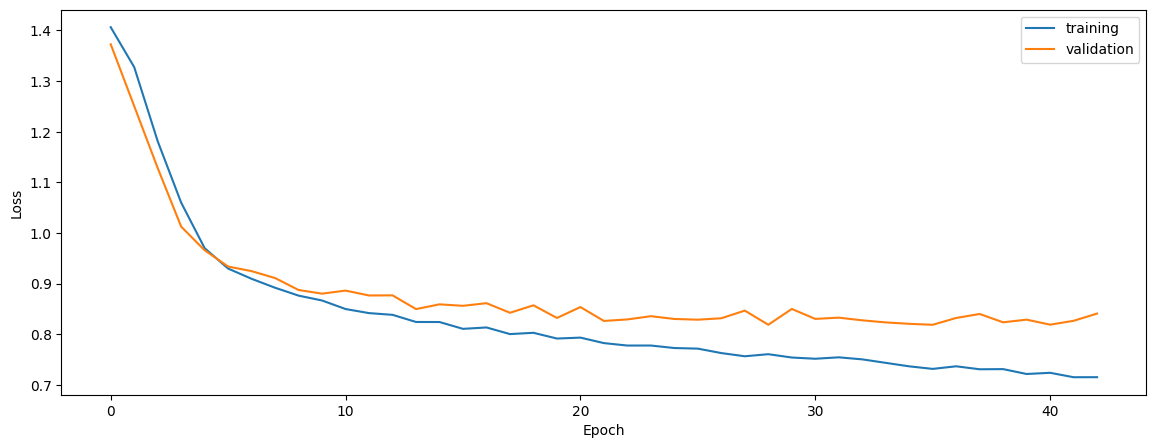

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.7079361425553811
0.6847209788122949
0.7072303794850584


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.7079361425553811
0.6847209788122949
0.7072303794850584


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.711784075746873
0.7008945350672781
0.7220649458784346


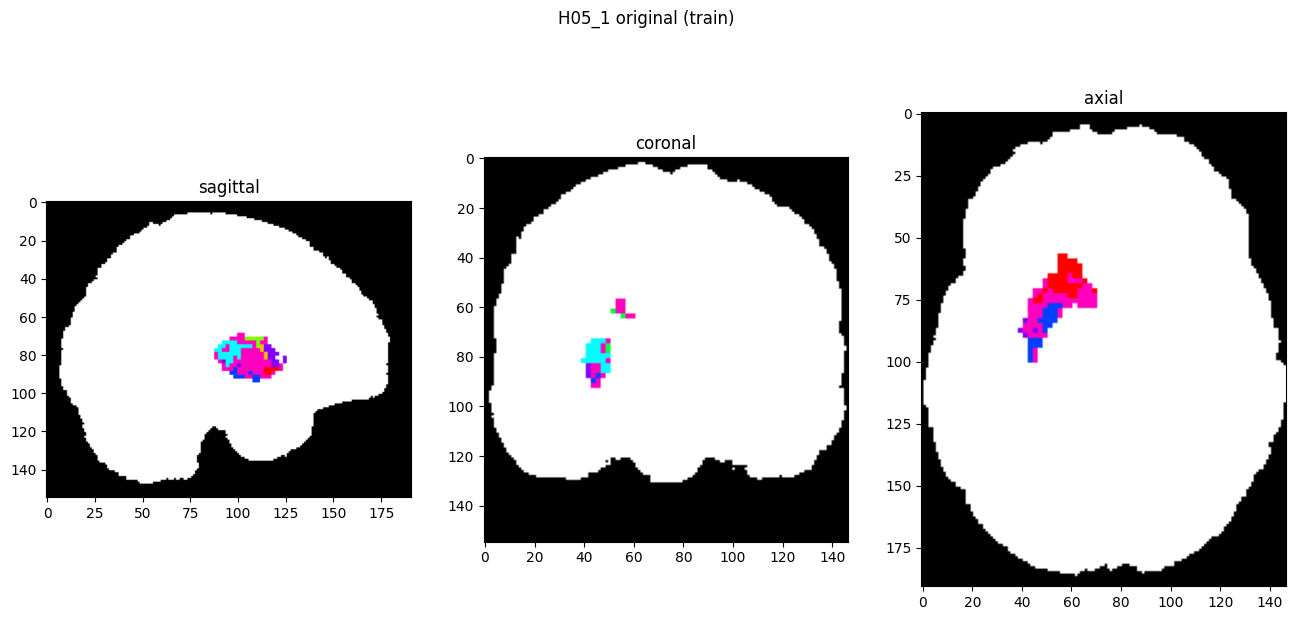

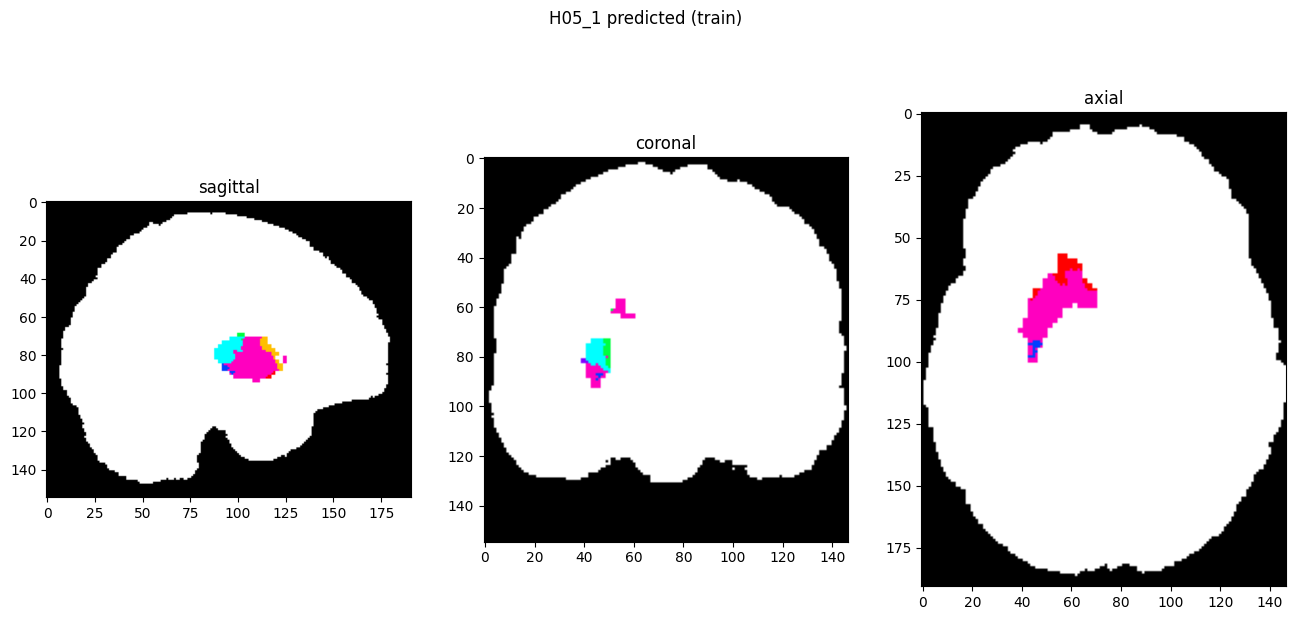

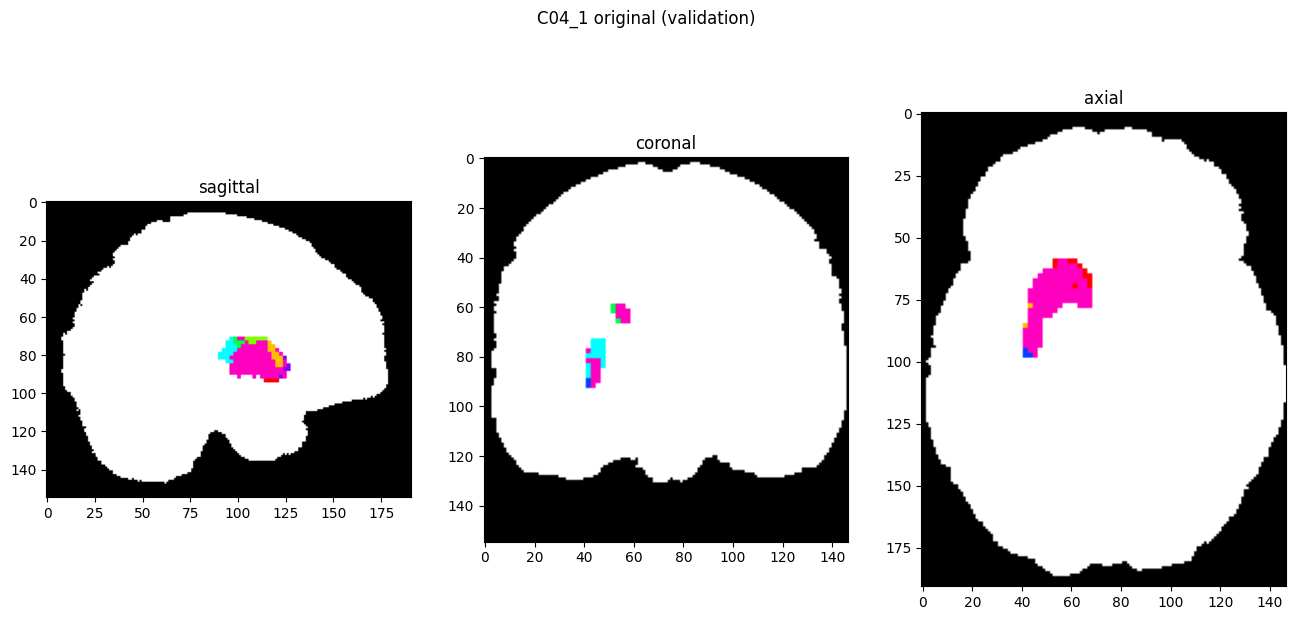

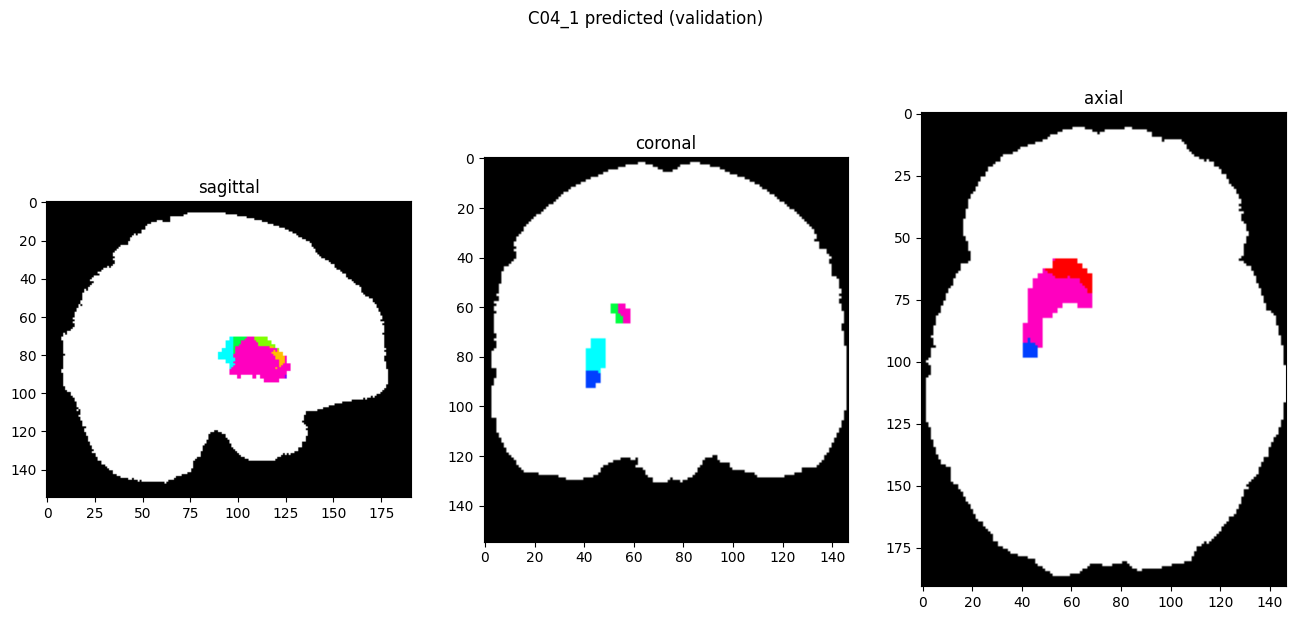

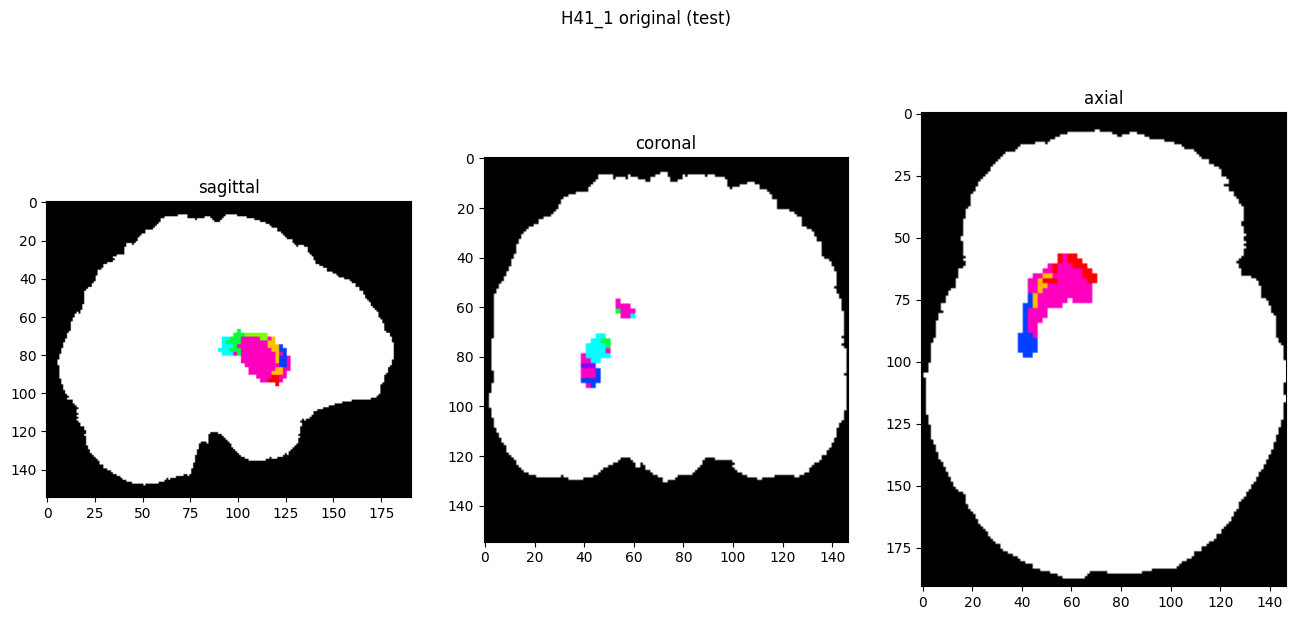

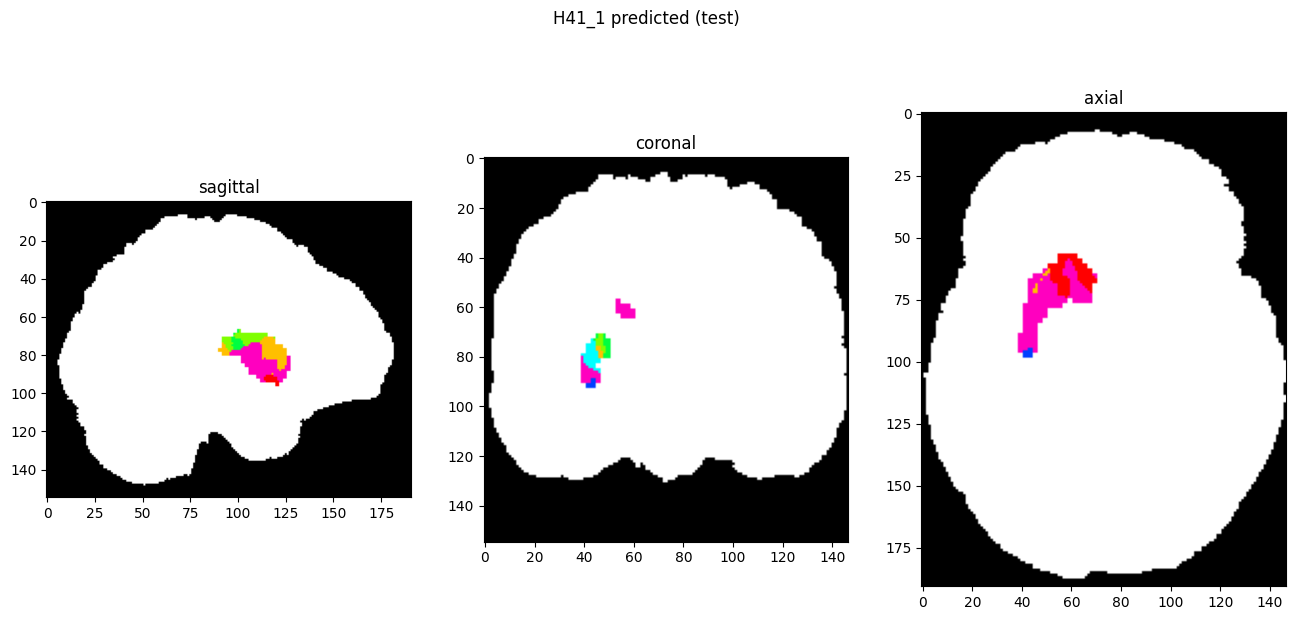

In [10]:
showResults(model, gen, threshold=0)